# Table of Contents


## [Libraries](#libraries)
<a href='#libraries'></a>

## [Data Loading](#data)
<a href='#data'></a>

## [Analyses](#analyses)
<a href='#analyses'></a>
1. [Expression error between developmental stages](#exp_err_across_dev)
<a href='#exp_err_across_dev'></a>
2. [Clustering across developmental stages](#clust_across_dev)
<a href='#clust_across_dev'></a>
3. [Differential gene expression between developmental stages](#deg_across_dev)
<a href='#deg_across_dev'></a>
4. [A general description of functional investment across development](#functional_description)
<a href='#functional_description'></a>
 - [Metabolism](#metabolism_across_dev)
<a href='#metabolism_across_dev'></a>
 - [Genetic Information Processing](#genetic_information_processing_across_dev)
<a href='#genetic_information_processing_across_dev'></a>
 - [Organismal Systems](#org_systems)
<a href='#org_systems'></a>
 - [Cellular Processes](#cell_process)
<a href='#cell_process'></a>
5. [Expression correlations  across development](#de_coupling)
<a href='#de_coupling'></a>

<hr style="border-color:black">

<a id='libraries'>

## Libraries

In [1]:
#import packages for analysis
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
from matplotlib.lines import Line2D
from numpy import log10
import numpy as np
import matplotlib.patches as mpatches
import scipy.stats
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score 
import numpy as np

from gnat import misc_utils
from gnat import error_calculator
from gnat import rarefaction
from gnat import gtf_tools
from gnat import kegg_tools

<hr style="border-color:black">

<a id='data'>

## Data Loading

In [88]:
# load data and analysis metadata
data = pd.read_csv('data/counts_tables/dpl_tpm_counts_kallisto.csv')
data.rename(columns={data.columns[0]: "sample-id" }, inplace = True)
metadata = pd.read_csv('data/mtstp_analysis_metadata.tsv', sep="\t")

In [3]:
data

sample-id  lcl|KZ248545.1_cds_OWR45966.1_1  \
0   mtstpEii125                         0.004381   
1    mtstp3ci13                       121.394000   
2    mtstpEci42                         0.646201   
3    mtstp5iu98                        40.307900   
4     mtstp3cu2                       117.197000   
..          ...                              ...   
91  mtstpAii153                        46.375600   
92   mtstpAci77                         1.684830   
93   mtstpLcu52                         0.043105   
94  mtstp5ii107                        53.877000   
95  mtstp5ii109                        35.321300   

    lcl|KZ248545.1_cds_OWR42929.1_2  lcl|KZ248545.1_cds_OWR42930.1_3  \
0                          0.039196                          85.4555   
1                        144.737000                         428.6490   
2                          1.008030                         166.6050   
3                         56.571700                        1108.7200   
4                        158.977000                         473.1770   
..                              ...                              ...   
91                        61.749900                         810.2900   
92                         5.399350                         755.1430   
93                         0.010688                         565.6320   
94                        65.076400                        1386.1200   
95                        54.494000                         951.2720   

    lcl|KZ248545.1_cds_OWR42931.1_4  lcl|KZ248545.1_cds_OWR42932.1_5  \
0                          0.508671                          2.38295   
1                         42.716800                         61.33330   
2                          1.263900                          5.06978   
3                        161.260000                          3.71412   
4                         50.214300                         51.89600   
..                              ...                              ...   
91                         2.772070                         25.28060   
92                         4.621490                         29.59380   
93                        11.630800                          0.67764   
94                        98.326700                          7.20435   
95                        40.695900                          6.25390   

    lcl|KZ248545.1_cds_OWR42933.1_6  lcl|KZ248545.1_cds_OWR42934.1_7  \
0                          0.410526                         0.053315   
1                          0.000000                         0.021915   
2                          1.455550                         0.021649   
3                          1.121030                         0.000000   
4                          1.055150                         0.024980   
..                              ...                              ...   
91                         2.462810                         0.188626   
92                         5.551320                         0.377091   
93                         0.408865                         0.057959   
94                         0.000000                         0.000000   
95                         0.000000                         0.000000   

    lcl|KZ248545.1_cds_OWR42935.1_8  lcl|KZ248545.1_cds_OWR42936.1_9  ...  \
0                           0.00000                         0.000000  ...   
1                           5.74457                        46.056200  ...   
2                           0.00000                         0.274288  ...   
3                           4.42744                        80.614100  ...   
4                           3.66607                        47.019600  ...   
..                              ...                              ...  ...   
91                          2.10779                         1.622320  ...   
92                          1.28787                         2.265960  ...   
93                          2.67938                         0.000000  ...   
94              

In [89]:
metadata

sample-id        plant infection-status developmental-stage lineage
0    mtstp3ci10  curassavica         infected        third-instar      EJ
1    mtstp3ci11  curassavica         infected        third-instar      EJ
2    mtstp3ci12  curassavica         infected        third-instar      AT
3    mtstp3ci13  curassavica         infected        third-instar      AT
4     mtstp3ci9  curassavica         infected        third-instar      EJ
..          ...          ...              ...                 ...     ...
91  mtstpLiu129    incarnata       uninfected           late-pupa      EJ
92  mtstpLiu130    incarnata       uninfected           late-pupa      EJ
93  mtstpLiu131    incarnata       uninfected           late-pupa      EJ
94  mtstpLiu133    incarnata       uninfected           late-pupa      AT
95  mtstpLiu135    incarnata       uninfected           late-pupa      AT

[96 rows x 5 columns]

In [3]:
#since this analysis will onyl deal with uninfected individuals, I'll filter out all infected samples
uninfected_samples = list(metadata.loc[metadata['infection-status'] != 'infected']['sample-id'])
uninfected_data = data[data['sample-id'].isin(uninfected_samples)]
uninfected_data.set_index("sample-id", inplace = True)
uninfected_data

lcl|KZ248545.1_cds_OWR45966.1_1  lcl|KZ248545.1_cds_OWR42929.1_2  \
sample-id                                                                       
mtstp5iu98                         40.307900                        56.571700   
mtstp3cu2                         117.197000                       158.977000   
mtstp5cu17                         53.580300                        72.488100   
mtstpLiu130                         0.036026                         0.000000   
mtstpLiu133                         0.025680                         0.091779   
mtstpEcu38                          0.000000                         0.011409   
mtstpAiu148                        20.759100                        32.852500   
mtstp5iu100                        32.551700                        40.219300   
mtstpLiu131                         1.578640                         1.649300   
mtstpAiu147                         2.604970                         6.297790   
mtstpEiu115                         0.000000                         0.000000   
mtstp3cu8                          29.974400                        40.601000   
mtstp3iu83                         98.823300                       132.963000   
mtstpLcu53                          0.359256                         0.396010   
mtstpAcu66                          2.011540                         6.906670   
mtstp5cu18                         15.945100                        21.193000   
mtstpEcu36                          0.000000                         0.034802   
mtstp5cu21                         63.247600                        68.294400   
mtstp3iu84                         86.734200                       121.443000   
mtstp3iu82                        111.970000                       150.068000   
mtstpAiu146                        32.254300                        39.683100   
mtstp3cu3                          96.000300                       127.566000   
mtstpAcu69                          2.906280                         5.415690   
mtstpAcu68                          7.294400                        15.827300   
mtstp3iu81                        121.609000                       144.497000   
mtstpEiu117                         0.015341                         0.056988   
mtstpLcu49                          0.089929                         0.084084   
mtstpAcu67                          1.999000                         6.472130   
mtstpEiu114                         0.032319                         0.051407   
mtstpLcu56                          0.014319                         0.039896   
mtstpAiu145                        11.655100                        14.818700   
mtstp3cu4                          76.693100                       114.822000   
mtstpLcu50                          0.657602                         0.515515   
mtstp3cu5                          98.160300                       124.615000   
mtstpLiu135                         0.122114                         0.195979   
mtstpAiu149                         3.837900                         6.630940   
mtstp3iu85                         75.919800                        94.491300   
mtstpEcu34                          0.012480                         0.000000   
mtstp5cu19                         30.339000                        37.577300   
mtstpEcu33                          0.029435                         0.120144   
mtstp5cu20                         14.333500                        17.915000   
mtstp5iu97                          2.715540                         3.191940   
mtstpLiu129                         0.134982                         0.040984   
mtstp5iu99                         38.043600                        53.893300   
mtstp5iu101                        37.617100                        51.494600   
mtstpAcu65                          1.946100                         7.246220   
mtstpEcu35                          0.019743                         0.054945   
mtstpEiu116                         0.031047

<hr style="border-color:black">

<a id='analyses'>

## Analyses

<a id='exp_err_across_dev'>

### Expression error between developmental stages

To kick this analysis off, I figured I would start by comparing the error in expression between adjacent developmental stages. I figured that if samples are similar in their mRNA expression profiles, they will show less error in expression. Therefore, if samples are really different, they will show significantly more error. To quantify error, I'll use the root of the mean squared error (RMSE). Functionally, this will model the gene expression of one sample against the other as $y=x$ (1:1 expression), which expected if two samples are identical. Then I'll calculate the average squared error on a per gene basis, and then square root that to try to minimize heavy biases. 

In the context of this study, lower root mean squared error (RMSE) values indicate the global gene expression is more similar between developmental stages, and higher RMSE values indicate the global gene expression is more different between developmental stages.


In [6]:
#a function to get the relevant rmse comparisons
def get_rmse_data_by_transitions(data, metadata):
    
    #get possible comparisons list
    comparisons = misc_utils.get_pairwise_comparisons(data)
    
    #filter comparisons to only include relevant comparisons
    relevant_comparisons = []
    for comparison in comparisons:
        stage1 = comparison[0][5]
        stage2 = comparison[1][5]
        
        if stage1 == '3' and stage2 == '5' or stage1 == '5' and stage2 == '3':
            relevant_comparisons.append(comparison)
        elif stage1 == '5' and stage2 == 'E' or stage2 == 'E' and stage2 == '5':
            relevant_comparisons.append(comparison)
        elif stage1 == 'E' and stage2 == 'L' or stage1 == 'L' and stage2 == 'E':
            relevant_comparisons.append(comparison)
        elif stage1 == 'L' and stage2 == 'A' or stage1 == 'A' and stage2 == 'L':
            relevant_comparisons.append(comparison)
            
    rmse_results = error_calculator.pairwise_rmse(data, relevant_comparisons)
    
    return rmse_results

#and a function to get this info parsed to the form I want
def parse_rmse_by_transition_data(rmse_data):
    #redefine dataframe to perserve origional dataframe
    rmse_df = rmse_data
    
    #add plant and comparison metadata
    transition = []
    plant = []
    
    comparison1_values = list(rmse_data["comparison1"])
    comparison2_values = list(rmse_data["comparison2"])
    
    for i in range(len(comparison1_values)):
        sample1_id = comparison1_values[i]
        sample2_id = comparison2_values[i]
        
        if sample1_id[6] == sample2_id[6]:
            #define comparisons
            if sample1_id[5] == '3' and sample2_id[5] == '5' or sample1_id[5] == '5' and sample2_id[5] == '3':
                transition.append('3rd-instar : 5th-instar')
                if sample1_id[6] == 'c':
                    plant.append('A. curassavica')
                elif sample1_id[6] == 'i':
                    plant.append('A. incarnata')
            elif sample1_id[5] == '5' and sample2_id[5] == 'E' or sample1_id[5] == 'E' and sample2_id[5] == '5':
                transition.append('5th-instar : Early-pupa')
                if sample1_id[6] == 'c':
                    plant.append('A. curassavica')
                elif sample1_id[6] == 'i':
                    plant.append('A. incarnata')
            elif sample1_id[5] == 'E' and sample2_id[5] == 'L' or sample1_id[5] == 'L' and sample2_id[5] == 'E':
                transition.append('Early-pupa : Late-pupa')
                if sample1_id[6] == 'c':
                    plant.append('A. curassavica')
                elif sample1_id[6] == 'i':
                    plant.append('A. incarnata')
            elif sample1_id[5] == 'L' and sample2_id[5] == 'A' or sample1_id[5] == 'A' and sample2_id[5] == 'L':
                transition.append('Late-pupa : Adult')
                if sample1_id[6] == 'c':
                    plant.append('A. curassavica')
                elif sample1_id[6] == 'i':
                    plant.append('A. incarnata')
                    
        else:
            transition.append('NA')
            plant.append('NA')

    #add comparisons to dataframe
    rmse_df['transition'] = transition
    rmse_df['plant'] = plant
    
    #remove na values
    rmse_df = rmse_df.loc[rmse_df['transition'] != 'NA']
    
    #sort data by transition order
    transitions = ['3rd-instar : 5th-instar', '5th-instar : Early-pupa', 'Early-pupa : Late-pupa', 'Late-pupa : Adult']
    rmse_df['transition'] = pd.Categorical(rmse_df['transition'], categories = transitions)
    rmse_df = rmse_df.sort_values(by='transition')
    
    return rmse_df

In [7]:
#get rmse data
rmse_by_developmental_transition = get_rmse_data_by_transitions(uninfected_data, metadata)

In [8]:
#parse rmse data for relevant comparisons
rmse_data_by_transition_parsed = parse_rmse_by_transition_data(rmse_by_developmental_transition)
rmse_data_by_transition_parsed

/tmp/ipykernel_16543/481674484.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rmse_df['transition'] = pd.Categorical(rmse_df['transition'], categories = transitions)


comparison1  comparison2         rmse               transition  \
0    mtstp3iu84  mtstp5iu101   797.301130  3rd-instar : 5th-instar   
0    mtstp3iu83   mtstp5iu97   676.391968  3rd-instar : 5th-instar   
0    mtstp3iu85  mtstp5iu101   816.741645  3rd-instar : 5th-instar   
0    mtstp3iu85   mtstp5iu99   454.815130  3rd-instar : 5th-instar   
0    mtstp3iu85   mtstp5iu97   691.092726  3rd-instar : 5th-instar   
..          ...          ...          ...                      ...   
0    mtstpAcu66   mtstpLcu52  1422.740486        Late-pupa : Adult   
0    mtstpAcu67   mtstpLcu56  1883.868235        Late-pupa : Adult   
0    mtstpAcu67   mtstpLcu50  1765.604343        Late-pupa : Adult   
0   mtstpAiu148  mtstpLiu135   976.554070        Late-pupa : Adult   
0   mtstpAiu148  mtstpLiu129  1018.732615        Late-pupa : Adult   

             plant  
0     A. incarnata  
0     A. incarnata  
0     A. incarnata  
0     A. incarnata  
0     A. incarnata  
..             ...  
0   A. curassavica  
0   A. curassavica  
0   A. curassavica  
0     A. incarnata  
0     A. incarnata  

[171 rows x 5 columns]

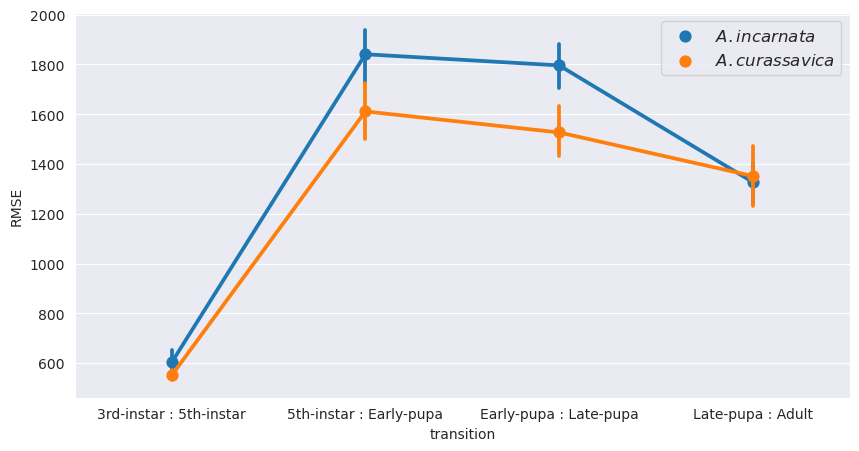

In [9]:
sns.set_style("darkgrid")

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax = sns.pointplot(data=rmse_data_by_transition_parsed, y="rmse", x="transition", hue="plant")

ax_legend=ax.legend(prop=fm.FontProperties(size=12))
ax_legend.get_texts()[1].set_text('$A. curassavica$')
ax_legend.get_texts()[0].set_text('$A. incarnata$')

ax.set_ylabel('RMSE')
#I'll stick this in supplemental for now. I'm just tyring to get at initial patterns
plt.savefig('../figures/supplemental/rmse_across_dev.pdf')

#### Comments

This is pretty interesting. It seems like the transition from third instar to fifth instar isn't super huge. But then the transition from fifth instar to early pupa is a huge jump. That's to be expected. What's even more interesting is that the transition from early pupa to late pupa is another huge jump, and there might be some variability by plant here. The the transition from pupa to adult is fairly large, but not quite as large as the subsequent two transitions. Also the variability in plant went away. 

<hr style="border-color:black">

<a id='clust_across_dev'>

### Clustering across developmental stages

There seem to be some interesting transitions going on, so now it's time to see how global mRNA expression profiles cluster by developmental stage. I'll try using several methods, as some metrics can be super sensitive (or not) to weird features of this type of data.

In [10]:
#I'll use R to get distance matricies because that's easier for me
#we'll focuse on Euclidian but get Manhattan for later if we want
!./scripts/get_distance_matricies.R

Warning message:
In dist(data, method = "euclidian") : NAs introduced by coercion
Warning message:
In dist(data, method = "manhattan") : NAs introduced by coercion


In [77]:
#and now to load the generated distance matricies
euclidian_distance_matrix = pd.read_csv('data/distance_matricies/euclidian.csv', index_col=0)
#remove infected samples
for sample in list(euclidian_distance_matrix.index):
    if sample[7] == 'i':
        euclidian_distance_matrix.drop(labels=sample, axis=0, inplace=True)
        euclidian_distance_matrix.drop(labels=sample, axis=1, inplace=True)

manhattan_distance_matrix = pd.read_csv('data/distance_matricies/manhattan.csv', index_col=0)
#remove infected samples
for sample in list(manhattan_distance_matrix):
    if sample[7] == 'i':
        manhattan_distance_matrix.drop(labels=sample, axis=0, inplace=True)
        manhattan_distance_matrix.drop(labels=sample, axis=1, inplace=True)
        
#and just to show what it looks like
manhattan_distance_matrix

mtstp5iu98     mtstp3cu2    mtstp5cu17   mtstpLiu130  \
mtstp5iu98   0.000000e+00  6.426752e+05  2.286926e+05  1.078922e+06   
mtstp3cu2    6.426752e+05  0.000000e+00  5.979471e+05  9.515716e+05   
mtstp5cu17   2.286926e+05  5.979471e+05  0.000000e+00  1.062890e+06   
mtstpLiu130  1.078922e+06  9.515716e+05  1.062890e+06  0.000000e+00   
mtstpLiu133  1.134690e+06  1.042427e+06  1.117610e+06  4.038509e+05   
mtstpEcu38   1.134211e+06  9.489249e+05  1.139535e+06  1.045078e+06   
mtstpAiu148  1.182343e+06  1.086479e+06  1.171671e+06  8.630307e+05   
mtstp5iu100  1.700550e+05  6.672010e+05  2.160826e+05  1.089418e+06   
mtstpLiu131  1.261923e+06  1.198556e+06  1.246581e+06  6.623950e+05   
mtstpAiu147  1.226553e+06  1.167345e+06  1.217463e+06  8.953339e+05   
mtstpEiu115  1.293683e+06  1.216496e+06  1.307597e+06  1.199837e+06   
mtstp3cu8    7.068420e+05  2.009556e+05  6.785166e+05  9.422137e+05   
mtstp3iu83   6.264054e+05  1.596307e+05  5.942060e+05  9.605370e+05   
mtstpLcu53   1.307517e+06  1.257860e+06  1.297892e+06  7.532950e+05   
mtstpAcu66   1.265976e+06  1.211396e+06  1.252123e+06  9.243329e+05   
mtstp5cu18   3.751370e+05  7.834630e+05  4.059745e+05  1.147473e+06   
mtstpEcu36   1.221577e+06  1.074905e+06  1.231925e+06  1.079568e+06   
mtstp5cu21   2.172902e+05  6.341380e+05  1.724547e+05  1.086567e+06   
mtstp3iu84   6.220660e+05  1.989814e+05  5.862975e+05  9.598914e+05   
mtstp3iu82   6.527186e+05  2.007067e+05  6.215237e+05  9.410892e+05   
mtstpAiu146  1.203157e+06  1.138895e+06  1.195701e+06  8.860417e+05   
mtstp3cu3    6.299592e+05  2.010775e+05  5.784172e+05  9.450596e+05   
mtstpEiu113  1.250345e+06  1.166823e+06  1.266604e+06  1.178511e+06   
mtstpAcu69   1.247290e+06  1.171513e+06  1.234550e+06  8.932516e+05   
mtstpAcu68   1.131257e+06  1.039046e+06  1.121451e+06  8.269373e+05   
mtstp3iu81   6.163399e+05  1.576967e+05  5.917987e+05  9.462657e+05   
mtstpEiu117  1.182729e+06  1.057204e+06  1.198999e+06  1.079857e+06   
mtstpLcu49   1.107398e+06  9.739646e+05  1.093237e+06  3.512000e+05   
mtstpAcu67   1.351743e+06  1.312061e+06  1.343637e+06  1.056694e+06   
mtstpEiu114  1.341299e+06  1.267734e+06  1.356793e+06  1.217486e+06   
mtstpLcu56   1.156767e+06  1.036458e+06  1.143543e+06  3.927716e+05   
mtstpAiu145  1.275023e+06  1.219458e+06  1.266723e+06  9.527452e+05   
mtstp3cu4    6.449708e+05  2.232170e+05  6.118088e+05  9.624530e+05   
mtstpLcu50   1.215542e+06  1.137364e+06  1.201004e+06  5.727157e+05   
mtstp3cu5    6.564330e+05  2.008895e+05  6.338809e+05  9.305630e+05   
mtstpLiu135  1.132365e+06  1.020549e+06  1.126076e+06  4.557176e+05   
mtstpAiu149  1.267223e+06  1.206098e+06  1.258478e+06  9.412430e+05   
mtstp3iu85   7.318229e+05  5.660900e+05  6.600955e+05  8.665604e+05   
mtstpEcu34   1.327660e+06  1.232772e+06  1.331941e+06  1.197025e+06   
mtstp5cu19   3.373930e+05  7.404538e+05  3.882944e+05  1.120637e+06   
mtstpEcu33   1.189898e+06  1.079091e+06  1.205001e+06  1.110124e+06   
mtstp5cu20   3.117172e+05  6.155830e+05  2.682016e+05  1.085223e+06   
mtstp5iu97   8.651491e+05  7.025823e+05  9.020709e+05  1.048122e+06   
mtstpLiu129  1.133902e+06  1.033630e+06  1.120075e+06  4.082133e+05   
mtstp5iu99   1.599916e+05  6.282068e+05  2.148110e+05  1.047166e+06   
mtstp5iu101  5.006798e+05  8.545225e+05  5.621627e+05  1.156559e+06   
mtstpAcu65   1.248776e+06  1.197669e+06  1.232048e+06  9.313284e+05   
mtstpEcu35   1.244533e+06  1.155056e+06  1.262083e+06  1.131718e+06   
mtstpEiu116  1.298038e+06  1.179329e+06  1.303150e+06  1.160288e+06   
mtstpLcu52   1.090546e+06  9.618667e+05  1.074719e+06  3.177836e+05   

              mtstpLiu133    mtstpEcu38   mtstpAiu148   mtstp5iu100  \
mtstp5iu98   1.134690e+06  1.134211e+06  1.182343e+06  1.700550e+05   
mtstp3cu2    1.042427e+06  9.489249e+05  1.086479e+06  6.672010e+05   
mtstp5cu17   1.117610e+06  1.139535e+06  1.171671e+06  2.160826e+05   
mtstpLiu130  4.038509e+05  1.045078e+06  8.630307e+05  1.089418e+06   
mtstpLiu133  0.000000e+00  1.109292e+0

In [194]:
#I'll use R to get distance matricies because that's easier for me
#we'll focuse on Euclidian but get Manhattan for later if we want
!./scripts/get_distance_matricies.R

Warning message:
In dist(data, method = "euclidian") : NAs introduced by coercion
Warning message:
In dist(data, method = "manhattan") : NAs introduced by coercion


In [26]:
#and now to load the generated distance matricies
euclidian_distance_matrix = pd.read_csv('data/distance_matricies/euclidian.csv', index_col=0)
#remove infected samples
for sample in list(euclidian_distance_matrix.index):
    if sample[7] == 'i':
        euclidian_distance_matrix.drop(labels=sample, axis=0, inplace=True)
        euclidian_distance_matrix.drop(labels=sample, axis=1, inplace=True)

manhattan_distance_matrix = pd.read_csv('data/distance_matricies/manhattan.csv', index_col=0)
#remove infected samples
for sample in list(manhattan_distance_matrix):
    if sample[7] == 'i':
        manhattan_distance_matrix.drop(labels=sample, axis=0, inplace=True)
        manhattan_distance_matrix.drop(labels=sample, axis=1, inplace=True)
        
#and just to show what it looks like
euclidian_distance_matrix

mtstp5iu98      mtstp3cu2     mtstp5cu17    mtstpLiu130  \
mtstp5iu98        0.000000   56252.444199   26344.686774   85892.027694   
mtstp3cu2     56252.444199       0.000000   59734.363870   70919.709743   
mtstp5cu17    26344.686774   59734.363870       0.000000   88556.343860   
mtstpLiu130   85892.027694   70919.709743   88556.343860       0.000000   
mtstpLiu133  112919.310823  102816.719063  115176.544640   62702.931572   
mtstpEcu38   136065.073392  128007.662117  139838.790841  128584.788457   
mtstpAiu148  130817.889215  121064.528132  133701.696252  115896.434806   
mtstp5iu100   15765.462026   62679.665800   20125.767182   90815.686166   
mtstpLiu131   96089.761045   81481.110541   99065.751677   62580.211831   
mtstpAiu147  162356.195103  154761.396281  164603.797190  148558.432332   
mtstpEiu115  247599.891434  244299.118491  250024.636091  238779.441259   
mtstp3cu8     57515.419880   17737.218423   62772.729707   68081.078619   
mtstp3iu83    64263.454454   24361.178326   67004.617168   79955.857081   
mtstpLcu53   137945.041399  129011.250171  140356.103422   94889.644735   
mtstpAcu66   180093.063095  173081.733555  182104.331953  166818.067494   
mtstp5cu18    36215.431700   74264.259205   48830.088126   99045.097414   
mtstpEcu36   179398.945725  173408.092561  182351.054049  170129.043341   
mtstp5cu21    19855.776549   60968.250467   15618.468251   88391.181800   
mtstp3iu84    62237.406879   20426.862243   64286.811831   78348.349089   
mtstp3iu82    64518.569731   24245.092438   66997.937456   78188.286028   
mtstpAiu146  194892.318505  188607.577587  196921.354508  184057.720458   
mtstp3cu3     65251.348461   26142.037551   66718.337383   80520.133358   
mtstpEiu113  159788.141014  155386.260763  164321.699797  148949.920585   
mtstpAcu69   160393.581492  152436.337847  162691.811527  146419.001277   
mtstpAcu68   107451.905430   94971.759437  110788.739680   94652.030328   
mtstp3iu81    58822.020524   13173.726877   62598.952648   73331.698537   
mtstpEiu117  182608.291223  177379.868480  185676.936456  174993.239890   
mtstpLcu49    93893.836479   79122.583657   97035.053293   39343.832119   
mtstpAcu67   239787.085567  234805.769321  241464.719348  228192.225842   
mtstpEiu114  243490.209572  239451.958261  245734.501181  231716.770790   
mtstpLcu56   101461.957712   88641.326752  104301.353247   43472.239362   
mtstpAiu145  191389.161629  185165.216439  193295.761208  178170.857312   
mtstp3cu4     64447.538091   25240.265386   66536.844030   80464.217142   
mtstpLcu50   102840.853664   89636.109418  105826.211516   57068.154659   
mtstp3cu5     55917.371898   19488.870961   61610.597152   67789.826336   
mtstpLiu135   93360.654134   80532.483174   96826.246762   39854.851517   
mtstpAiu149  186001.791912  179397.480400  188054.260852  173718.329071   
mtstp3iu85    57946.401169   46030.631453   51758.070545   71873.783694   
mtstpEcu34   241060.256088  236798.664582  243272.214592  229297.537594   
mtstp5cu19    32486.815692   69377.434010   48161.538188   94836.697056   
mtstpEcu33   177398.254182  172456.332469  180896.449083  168108.428061   
mtstp5cu20    33053.988637   59659.613106   25382.092673   88076.761675   
mtstp5iu97    74562.668656   74655.311740   86963.099565   94742.203119   
mtstpLiu129  104644.992153   91668.934057  107600.945564   51522.777976   
mtstp5iu99    13053.804054   57976.465630   20557.972092   86243.491108   
mtstp5iu101   60379.916219   94172.661634   74594.938784  112505.378513   
mtstpAcu65   186562.896144  180183.332708  188551.974593  170533.817550   
mtstpEcu35   201622.495971  196929.936417  204448.650340  191755.818399   
mtstpEiu116  226605.152941  222056.352482  228764.837036  216894.817463   
mtstpLcu52    98340.279819   84828.015620  101303.701370   42442.632375   

               mtstpLiu133     mtstpEcu38    mtstpAiu148    mtstp5iu100  \
mtstp5iu98   112919.310823  136065.073392  130817.889215   15765.462026   
mtstp3cu2    102816.719063  128007.66211

In [12]:
#and now to load and plot the data
pca_data = pd.read_csv('data/uninfected_pca.csv', index_col=0)[["PC1", "PC2"]]
#add metadata data
stage = []
plant = []

for sample in list(pca_data.index):
    if sample[5] == '3':
        stage.append('third-instar')
    elif sample[5] == '5':
        stage.append('fifth-instar')
    elif sample[5] == 'E':
        stage.append('early-pupa')
    elif sample[5] == 'L':
        stage.append('late-pupa')
    elif sample[5] == 'A':
        stage.append('adult')

    if sample[6] == 'i':
        plant.append('A. incarnata')
    elif sample[6] == 'c':
        plant.append('A. curassavica')
        
pca_data['developmental-stage'] = stage
pca_data['plant'] = plant

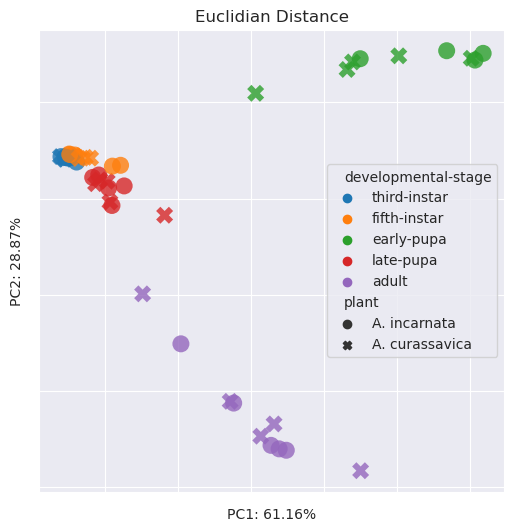

In [14]:
#and now to plot
sns.set_style('darkgrid')

fig, ax1 = plt.subplots(1, 1, figsize=(6, 6))
hue_order = ['third-instar', 'fifth-instar', 'early-pupa', 'late-pupa', 'adult']
sns.scatterplot(data=pca_data, x='PC1', y='PC2', ax=ax1, hue='developmental-stage', 
                style='plant', hue_order = hue_order,
                s=150, alpha=0.8, edgecolor = 'none')

ax1.set_xlabel('PC1: 61.16%')
ax1.set_ylabel('PC2: 28.87%')

ax1.set_xticklabels([])
ax1.set_yticklabels([])

ax1.set_title('Euclidian Distance')
plt.savefig('../figures/supplemental/euclidian_pca.pdf')

In [24]:
#define colors for cluster map
colors_by_stage = pd.DataFrame()
samples = []
colors = []
for sample in list(euclidian_distance_matrix.index):
    stage = sample[5]
    if stage == '3':
        colors.append('tab:blue')
    elif stage == '5':
        colors.append('tab:orange')
    elif stage == 'E':
        colors.append('tab:green')
    elif stage == 'L':
        colors.append('tab:red')
    elif stage == 'A':
        colors.append('tab:purple')
    samples.append(sample)
    
#assemble dataframe
colors_by_stage['sample'] = samples
colors_by_stage['Developmental Stage'] = colors
colors_by_stage = colors_by_stage.set_index('sample')

/home/gabe/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:624: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


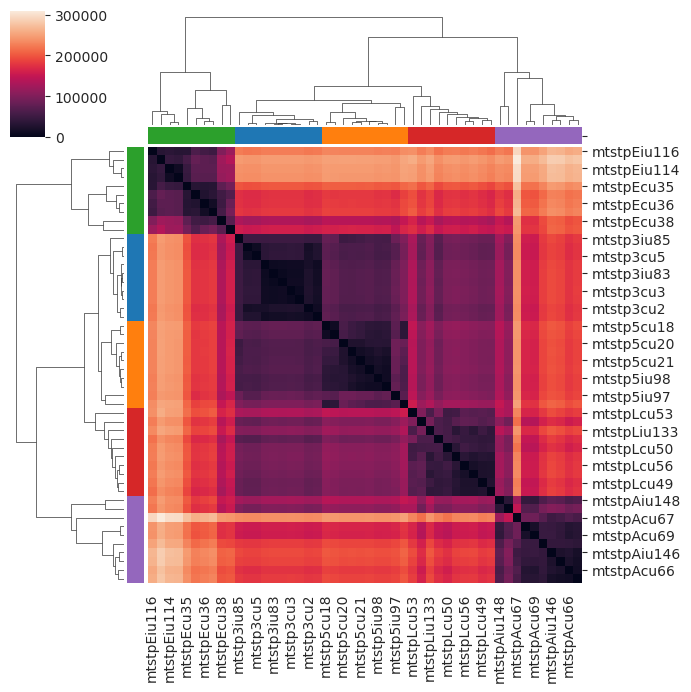

In [133]:
#and now for a heatmap + heirachical clustering
sns.clustermap(euclidian_distance_matrix, figsize=(7, 7), row_colors=colors_by_stage, col_colors=colors_by_stage)
plt.savefig('../figures/supplemental/euclidian_clustering.pdf')

Using Euclidian distances looks a little fuzzy. I don't completely understand why, but I have read that using Manhattan distances can be preferable for high deminsional data.

In [26]:
#run manhattan pca
!./scripts/manhattan_pca.R

Importance of components:
                             PC1       PC2       PC3       PC4       PC5
Standard deviation     1.766e+06 1.317e+06 8.175e+05 6.248e+05 2.691e+05
Proportion of Variance 5.074e-01 2.825e-01 1.088e-01 6.353e-02 1.179e-02
Cumulative Proportion  5.074e-01 7.899e-01 8.987e-01 9.622e-01 9.740e-01
                             PC6       PC7       PC8       PC9      PC10
Standard deviation     1.765e+05 1.500e+05 1.357e+05 1.174e+05 9.703e+04
Proportion of Variance 5.070e-03 3.660e-03 3.000e-03 2.240e-03 1.530e-03
Cumulative Proportion  9.791e-01 9.827e-01 9.857e-01 9.880e-01 9.895e-01
                            PC11      PC12      PC13      PC14      PC15
Standard deviation     9.074e+04 8.231e+04 7.016e+04 5.907e+04 5.783e+04
Proportion of Variance 1.340e-03 1.100e-03 8.000e-04 5.700e-04 5.400e-04
Cumulative Proportion  9.908e-01 9.919e-01 9.927e-01 9.933e-01 9.939e-01
                            PC16      PC17      PC18      PC19      PC20
Standard deviation     5.

In [27]:
#and now to load and plot the data
manhattan_pca_data = pd.read_csv('data/manhattan_uninfected_pca.csv', index_col=0)[["PC1", "PC2"]]
#add metadata data
stage = []
plant = []

for sample in list(manhattan_pca_data.index):
    if sample[5] == '3':
        stage.append('third-instar')
    elif sample[5] == '5':
        stage.append('fifth-instar')
    elif sample[5] == 'E':
        stage.append('early-pupa')
    elif sample[5] == 'L':
        stage.append('late-pupa')
    elif sample[5] == 'A':
        stage.append('adult')

    if sample[6] == 'i':
        plant.append('A. incarnata')
    elif sample[6] == 'c':
        plant.append('A. curassavica')
        
manhattan_pca_data['developmental-stage'] = stage
manhattan_pca_data['plant'] = plant

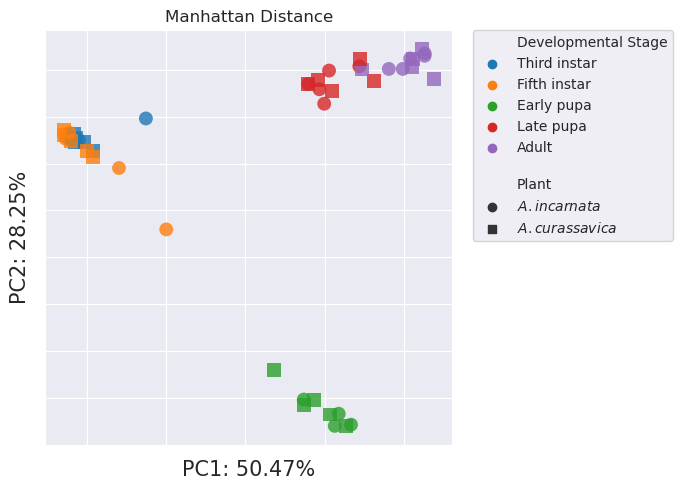

In [96]:
#and now to plot
sns.set_style('darkgrid')

fig, ax1 = plt.subplots(1, 1, figsize=(7, 5))
hue_order = ['third-instar', 'fifth-instar', 'early-pupa', 'late-pupa', 'adult']
sns.scatterplot(data=manhattan_pca_data, x='PC1', y='PC2', ax=ax1, hue='developmental-stage', 
                style='plant', hue_order = hue_order,
                s=100, alpha=0.8, edgecolor = 'none', markers=['o', 's'])

ax1.set_xlabel('PC1: 50.47%', size=15)
ax1.set_ylabel('PC2: 28.25%', size=15)
ax1.set_xticklabels([])
ax1.set_yticklabels([])

handles, previous_labels = ax1.get_legend_handles_labels()
ax1.legend(handles=handles, 
           labels=['Developmental Stage', 'Third instar', 'Fifth instar', 'Early pupa', 'Late pupa', 'Adult', '\nPlant', '$A. incarnata$', '$A. curassavica$'],
          bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

ax1.set_title("Manhattan Distance")
plt.tight_layout()
plt.savefig('../figures/primary/manhattan_pca.pdf')

In [173]:
#define colors for cluster map
colors_by_stage = pd.DataFrame()
samples = []
colors = []
for sample in list(manhattan_distance_matrix):
    stage = sample[5]
    if stage == '3':
        colors.append('tab:blue')
    elif stage == '5':
        colors.append('tab:orange')
    elif stage == 'E':
        colors.append('tab:green')
    elif stage == 'L':
        colors.append('tab:red')
    elif stage == 'A':
        colors.append('tab:purple')
    samples.append(sample)
    
#assemble dataframe
colors_by_stage['sample'] = samples
colors_by_stage[''] = colors
colors_by_stage = colors_by_stage.set_index('sample')

/home/gabe/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:624: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/tmp/ipykernel_129317/2935780651.py:19: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


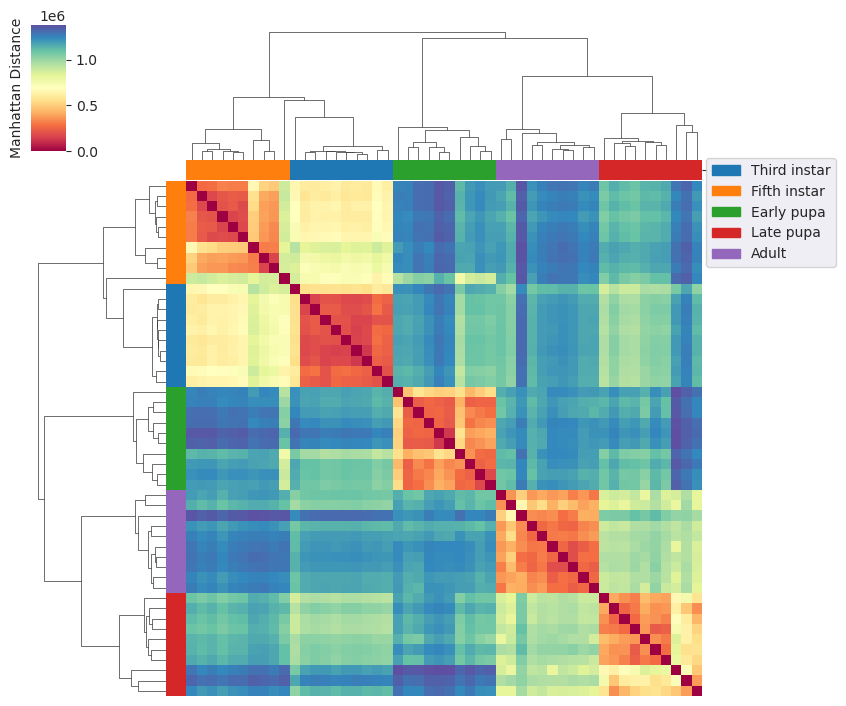

In [190]:
#and now for a heatmap + heirachical clustering

cluster = sns.clustermap(manhattan_distance_matrix, row_colors=colors_by_stage, 
               col_colors=colors_by_stage, yticklabels=False, xticklabels=False,
              figsize=(7, 7), cmap="Spectral")

third_lab = mpatches.Patch(color='tab:blue', label='Third instar')
fifth_lab = mpatches.Patch(color='tab:orange', label='Fifth instar')
early_lab = mpatches.Patch(color='tab:green', label='Early pupa')
late_lab = mpatches.Patch(color='tab:red', label='Late pupa')
adult_lab = mpatches.Patch(color='tab:purple', label='Adult')

plt.legend(handles=[third_lab, fifth_lab, early_lab, late_lab, adult_lab], bbox_to_anchor=(22.7, -0.5, 0.5, 0.5))

cbar = cluster.ax_heatmap.collections[0].colorbar
cbar.set_label("Manhattan Distance", labelpad=5)
cbar.ax.yaxis.set_label_position('left')

plt.tight_layout()
plt.savefig('../figures/primary/manhattan_clustering.pdf', bbox_inches='tight')

In [147]:
#and a function to get this info parsed to the form I want
def parse_distance_data(distance_matrix):
    #redefine dataframe to perserve origional dataframe
    matrix = distance_matrix
    
    #add plant and comparison metadata
    transition = []
    plant = []
    
    comparison1_values = list(matrix["comp1"])
    comparison2_values = list(matrix["comp2"])
    
    for i in range(len(comparison1_values)):
        sample1_id = comparison1_values[i]
        sample2_id = comparison2_values[i]
        
        if sample1_id[6] == sample2_id[6]:
            #define comparisons
            if sample1_id[5] == '3' and sample2_id[5] == '5' or sample1_id[5] == '5' and sample2_id[5] == '3':
                transition.append('3rd-instar : 5th-instar')
                if sample1_id[6] == 'c':
                    plant.append('A. curassavica')
                elif sample1_id[6] == 'i':
                    plant.append('A. incarnata')
            elif sample1_id[5] == '5' and sample2_id[5] == 'E' or sample1_id[5] == 'E' and sample2_id[5] == '5':
                transition.append('5th-instar : Early-pupa')
                if sample1_id[6] == 'c':
                    plant.append('A. curassavica')
                elif sample1_id[6] == 'i':
                    plant.append('A. incarnata')
            elif sample1_id[5] == 'E' and sample2_id[5] == 'L' or sample1_id[5] == 'L' and sample2_id[5] == 'E':
                transition.append('Early-pupa : Late-pupa')
                if sample1_id[6] == 'c':
                    plant.append('A. curassavica')
                elif sample1_id[6] == 'i':
                    plant.append('A. incarnata')
            elif sample1_id[5] == 'L' and sample2_id[5] == 'A' or sample1_id[5] == 'A' and sample2_id[5] == 'L':
                transition.append('Late-pupa : Adult')
                if sample1_id[6] == 'c':
                    plant.append('A. curassavica')
                elif sample1_id[6] == 'i':
                    plant.append('A. incarnata')
            else:
                transition.append('NA')
                plant.append('NA')         
        else:
            transition.append('NA')
            plant.append('NA')

    
    #add comparisons to dataframe
    matrix['transition'] = transition
    matrix['plant'] = plant
    
    #remove na values
    matrix = matrix.loc[matrix['transition'] != 'NA']
    
    #sort data by transition order
    transitions = ['3rd-instar : 5th-instar', '5th-instar : Early-pupa', 'Early-pupa : Late-pupa', 'Late-pupa : Adult']
    matrix['transition'] = pd.Categorical(matrix['transition'], categories = transitions)
    matrix = matrix.sort_values(by='transition')
    
    return matrix

In [148]:
#convert data to long format
manhattan_matrix_long = manhattan_distance_matrix.stack().reset_index()
manhattan_matrix_long.columns = ['comp1', 'comp2', 'manhattan_distance']
manhattan_matrix_long = manhattan_matrix_long[manhattan_matrix_long['comp1'] != manhattan_matrix_long['comp2']]
#parse comparisons
manhattan_data = parse_distance_data(manhattan_matrix_long)

/tmp/ipykernel_129317/3707984517.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matrix['transition'] = pd.Categorical(matrix['transition'], categories = transitions)


In [149]:
manhattan_data

comp1       comp2  manhattan_distance               transition  \
2071  mtstp5cu20   mtstp3cu3       608509.753647  3rd-instar : 5th-instar   
2082  mtstp5cu20   mtstp3cu4       603349.186650  3rd-instar : 5th-instar   
1615   mtstp3cu4  mtstp5cu18       766064.534175  3rd-instar : 5th-instar   
751   mtstp5cu18   mtstp3cu2       783462.979706  3rd-instar : 5th-instar   
761   mtstp5cu18   mtstp3cu8       819008.740271  3rd-instar : 5th-instar   
...          ...         ...                 ...                      ...   
1364  mtstpLcu49  mtstpAcu66       932624.285448        Late-pupa : Adult   
1373  mtstpLcu49  mtstpAcu69       914374.991236        Late-pupa : Adult   
1374  mtstpLcu49  mtstpAcu68       810627.259629        Late-pupa : Adult   
1163  mtstpAcu69  mtstpLcu53       967089.782283        Late-pupa : Adult   
749   mtstpAcu66  mtstpLcu52       968634.390955        Late-pupa : Adult   

               plant  
2071  A. curassavica  
2082  A. curassavica  
1615  A. curassavica  
751   A. curassavica  
761   A. curassavica  
...              ...  
1364  A. curassavica  
1373  A. curassavica  
1374  A. curassavica  
1163  A. curassavica  
749   A. curassavica  

[400 rows x 5 columns]

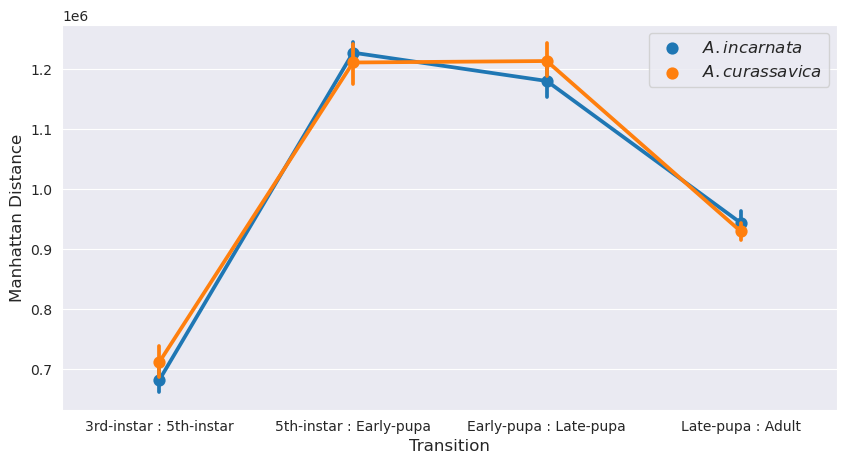

In [159]:
sns.set_style("darkgrid")

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax = sns.pointplot(data=manhattan_data, y="manhattan_distance", x="transition", hue="plant")

ax_legend=ax.legend(prop=fm.FontProperties(size=12))
ax_legend.get_texts()[1].set_text('$A. curassavica$')
ax_legend.get_texts()[0].set_text('$A. incarnata$')

ax.set_ylabel('Manhattan Distance', size=12)
ax.set_xlabel('Transition', size=12)
#I'll stick this in supplemental for now. I'm just tyring to get at initial patterns
plt.savefig('../figures/primary/manhattan_distance_pointplot.pdf')

#### Comments

The clustering results were really consistent with the error analysis. However, the revealed a really interesting aspect of what's going on. It seems like the transition from third to fifth isn't accompanied by a lot of changes in gene expression. However, it seems like a lot of expression changes occur throughout the transition from fifth instar to early pupa, and this is in a totally different trajectory from the transition from late pupa to adult. 

This pattern is for the most part replicated using different distance metrics and in clustering analyses, so I don't think it's a weird feature of the data. I think this pattern will be interesting to try and explain.

<hr style="border-color:black">

<a id='deg_across_dev'>

### Differential gene expression between developmental stages

Now I'll get at trying to explain some of these patterns. It might be telling to see what genes are being up and down regulated between developmental stages. I'm not sure how appropriate (or useful) this analysis is for this specific study. This data is kind of time-series data, but also the samples across stages are independent of each other, so maybe it's fine. I'm not particularly fond of these analyses because threshold selection seems a bit arbitrary, but it might help add something to the picture of what's going on. I'll see what the analysis says and go from there. 

In [134]:
#as usual, I like to do my stats in R. Plus I like the edgeR algorithm for DEG analysis. I've read it's more conservative
!./scripts/edgeR_across_development.R

Loading required package: limma
Using classic mode.
Using classic mode.
Using classic mode.
Using classic mode.
Using classic mode.
Using classic mode.
Using classic mode.
Using classic mode.


In [9]:
#Load the differential expression data that was just generated
def load_de_data(file):
    #read data
    df = pd.read_csv(file, index_col=0)
    #add column for significantly up or down
    df["regulation"] = df["FDR"]
    #if FDR is less than cutoff and logFC is greater than 0, regulation = up
    df.loc[(df['FDR'] < 0.01) & (df['logFC'] > 0), 'regulation'] = 'up'
    #if FDR is less than cutoff and logFC is less than 0, regulation = down
    df.loc[(df['FDR'] < 0.01) & (df['logFC'] < 0), 'regulation'] = 'down'
    #if FDR is greater than cutoff, regulation = NA
    df.loc[df['FDR'] > 0.01, 'regulation'] = 'NA'
    
    return df

#whoops, messed up my file names a bit. Ohh well
#3-5
third_to_fifth_inc = load_de_data('data/edgeR/across_development/third_to_fifth_inc_incarnata')
third_to_fifth_cur = load_de_data('data/edgeR/across_development/third_to_fifth_cur_curassavica')

#5-E
fifth_to_early_inc = load_de_data('data/edgeR/across_development/fifth_to_early_inc_incarnata')
fifth_to_early_cur = load_de_data('data/edgeR/across_development/fifth_to_early_cur_curassavica')

#E-L
early_to_late_inc = load_de_data('data/edgeR/across_development/early_to_late_inc_incarnata')
early_to_late_cur = load_de_data('data/edgeR/across_development/early_to_late_cur_curassavica')

#E-L
late_to_adult_inc = load_de_data('data/edgeR/across_development/late_to_adult_inc_incarnata')
late_to_adult_cur = load_de_data('data/edgeR/across_development/late_to_adult_cur_curassavica')

third_to_fifth_inc

logFC     logCPM        PValue  \
lcl.KZ248595.1_cds_OWR53164.1_5184   -5.118158   3.303146  1.031640e-54   
lcl.KZ248594.1_cds_OWR50184.1_5084   -9.565912   7.177425  4.564501e-42   
lcl.KZ248611.1_cds_OWR43054.1_6044  -15.387951  16.393639  2.788577e-39   
lcl.KZ248684.1_cds_OWR41437.1_8904   -5.117918   5.960070  2.518892e-34   
lcl.KZ248589.1_cds_OWR51228.1_4702    4.654063   1.531110  1.912098e-29   
...                                        ...        ...           ...   
lcl.KZ248725.1_cds_OWR47689.1_10245   0.000524   2.471329  1.000000e+00   
lcl.KZ248946.1_cds_OWR42807.1_14173   0.000483   1.471046  1.000000e+00   
lcl.KZ248554.1_cds_OWR53682.1_1523    0.000361   5.498090  1.000000e+00   
lcl.KZ248587.1_cds_OWR47022.1_4543    0.000239   3.600350  1.000000e+00   
lcl.KZ248571.1_cds_OWR45276.1_3226    0.000136   5.321073  1.000000e+00   

                                              FDR regulation  
lcl.KZ248595.1_cds_OWR53164.1_5184   1.138414e-50       down  
lcl.KZ248594.1_cds_OWR50184.1_5084   2.518464e-38       down  
lcl.KZ248611.1_cds_OWR43054.1_6044   1.025732e-35       down  
lcl.KZ248684.1_cds_OWR41437.1_8904   6.948994e-31       down  
lcl.KZ248589.1_cds_OWR51228.1_4702   3.724104e-26         up  
...                                           ...        ...  
lcl.KZ248725.1_cds_OWR47689.1_10245  1.000000e+00         NA  
lcl.KZ248946.1_cds_OWR42807.1_14173  1.000000e+00         NA  
lcl.KZ248554.1_cds_OWR53682.1_1523   1.000000e+00         NA  
lcl.KZ248587.1_cds_OWR47022.1_4543   1.000000e+00         NA  
lcl.KZ248571.1_cds_OWR45276.1_3226   1.000000e+00         NA  

[11035 rows x 5 columns]

In [10]:
#get number of up and down regulated genes for each stage
third_to_fifth_inc_up_count = len(third_to_fifth_inc.loc[third_to_fifth_inc['regulation'] == 'up'])
third_to_fifth_inc_down_count = len(third_to_fifth_inc.loc[third_to_fifth_inc['regulation'] == 'down'])
third_to_fifth_cur_up_count = len(third_to_fifth_cur.loc[third_to_fifth_cur['regulation'] == 'up'])
third_to_fifth_cur_down_count = len(third_to_fifth_cur.loc[third_to_fifth_cur['regulation'] == 'down'])

fifth_to_early_inc_up_count = len(fifth_to_early_inc.loc[fifth_to_early_inc['regulation'] == 'up'])
fifth_to_early_inc_down_count = len(fifth_to_early_inc.loc[fifth_to_early_inc['regulation'] == 'down'])
fifth_to_early_cur_up_count = len(fifth_to_early_cur.loc[fifth_to_early_cur['regulation'] == 'up'])
fifth_to_early_cur_down_count = len(fifth_to_early_cur.loc[fifth_to_early_cur['regulation'] == 'down'])

early_to_late_inc_up_count = len(early_to_late_inc.loc[early_to_late_inc['regulation'] == 'up'])
early_to_late_inc_down_count = len(early_to_late_inc.loc[early_to_late_inc['regulation'] == 'down'])
early_to_late_cur_up_count = len(early_to_late_cur.loc[early_to_late_cur['regulation'] == 'up'])
early_to_late_cur_down_count = len(early_to_late_cur.loc[early_to_late_cur['regulation'] == 'down'])

late_to_adult_inc_up_count = len(late_to_adult_inc.loc[late_to_adult_inc['regulation'] == 'up'])
late_to_adult_inc_down_count = len(late_to_adult_inc.loc[late_to_adult_inc['regulation'] == 'down'])
late_to_adult_cur_up_count = len(late_to_adult_cur.loc[late_to_adult_cur['regulation'] == 'up'])
late_to_adult_cur_down_count = len(late_to_adult_cur.loc[late_to_adult_cur['regulation'] == 'down'])

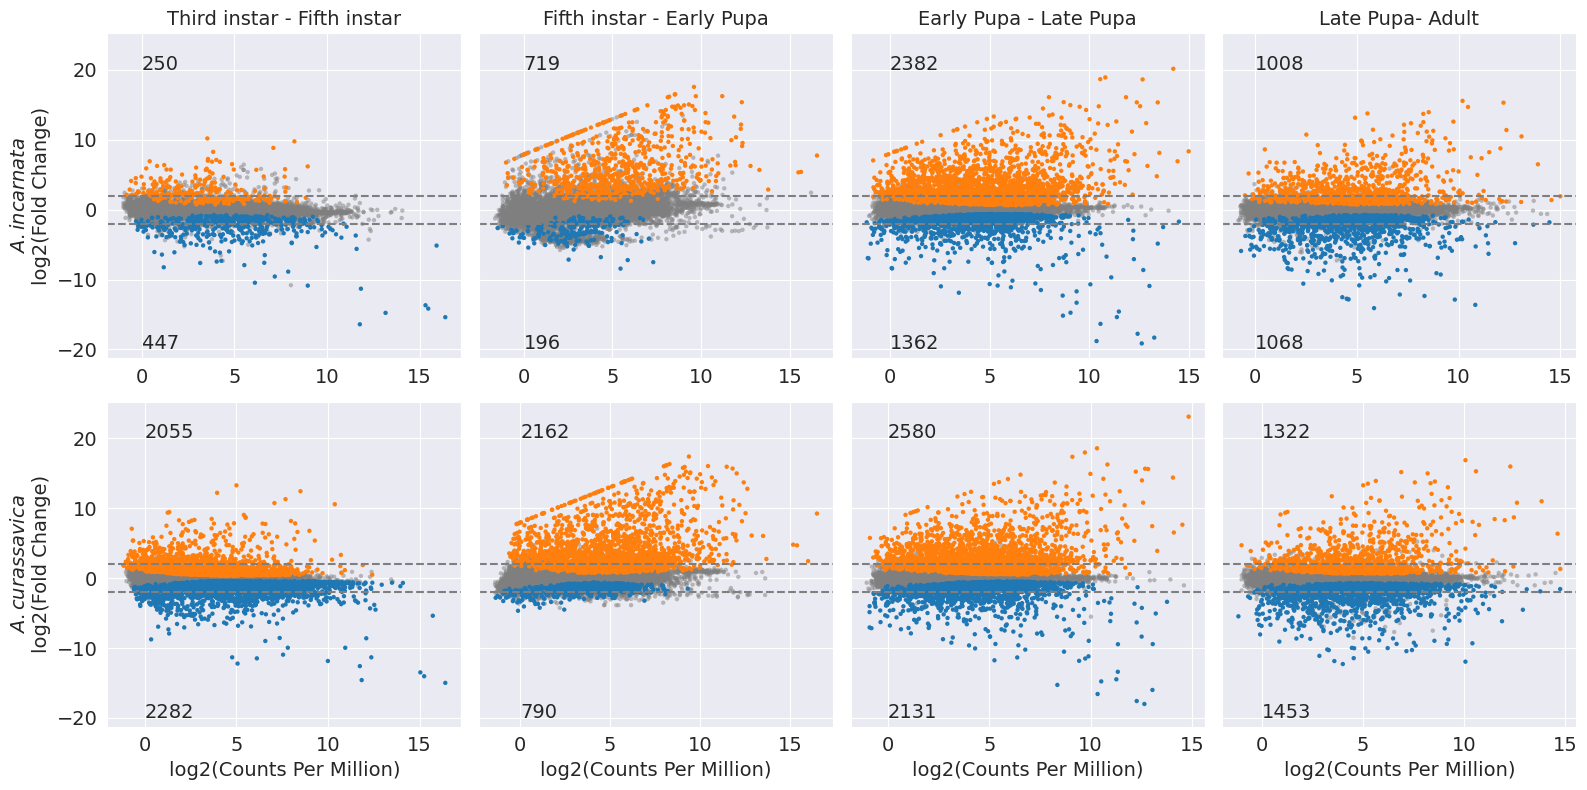

In [11]:
#Make expression plots
sns.set_style('darkgrid')
sns.set_palette("tab10")
size=10

fig, [[ax1, ax2, ax3, ax4], [ax5, ax6, ax7, ax8]] = plt.subplots(2, 4, figsize=(16, 8), sharey=True)

#inc first
#plot 3-5
#plot non-regulated
sns.scatterplot(data=third_to_fifth_inc.loc[third_to_fifth_inc["regulation"] == "NA"], 
                x="logCPM", y="logFC", ax=ax1, edgecolor = 'none', color = "tab:gray", alpha=0.5, s=size)
#plot up regulated
sns.scatterplot(data=third_to_fifth_inc.loc[third_to_fifth_inc["regulation"] == "up"], 
                x="logCPM", y="logFC", ax=ax1, edgecolor = 'none', color = "tab:orange", alpha=1, s=size)
#plot down regulated
sns.scatterplot(data=third_to_fifth_inc.loc[third_to_fifth_inc["regulation"] == "down"], 
                x="logCPM", y="logFC", ax=ax1, edgecolor = 'none', color = "tab:blue", alpha=1, s=size)

ax1.set_title("Third instar - Fifth instar", size=14)
ax1.set_ylabel('$A. incarnata$\nlog2(Fold Change)', size=14)
ax1.set_xlabel("")
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)

#plot 5-E
#plot non-regulated
sns.scatterplot(data=fifth_to_early_inc.loc[fifth_to_early_inc["regulation"] == "NA"], 
                x="logCPM", y="logFC", ax=ax2, edgecolor = 'none', color = "tab:gray", alpha=0.5, s=size)
#plot up regulated
sns.scatterplot(data=fifth_to_early_inc.loc[fifth_to_early_inc["regulation"] == "up"], 
                x="logCPM", y="logFC", ax=ax2, edgecolor = 'none', color = "tab:orange", alpha=1, s=size)
#plot down regulated
sns.scatterplot(data=fifth_to_early_inc.loc[fifth_to_early_inc["regulation"] == "down"], 
                x="logCPM", y="logFC", ax=ax2, edgecolor = 'none', color = "tab:blue", alpha=1, s=size)
ax2.set_title("Fifth instar - Early Pupa", size=14)
ax2.set_xlabel("")
ax2.tick_params(axis='x', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)

#plot E-L
#plot non-regulated
sns.scatterplot(data=early_to_late_inc.loc[early_to_late_inc["regulation"] == "NA"], 
                x="logCPM", y="logFC", ax=ax3, edgecolor = 'none', color = "tab:gray", alpha=0.5, s=size)
#plot up regulated
sns.scatterplot(data=early_to_late_inc.loc[early_to_late_inc["regulation"] == "up"], 
                x="logCPM", y="logFC", ax=ax3, edgecolor = 'none', color = "tab:orange", alpha=1, s=size)
#plot down regulated
sns.scatterplot(data=early_to_late_inc.loc[early_to_late_inc["regulation"] == "down"], 
                x="logCPM", y="logFC", ax=ax3, edgecolor = 'none', color = "tab:blue", alpha=1, s=size)

ax3.set_title("Early Pupa - Late Pupa", size=14)
ax3.set_xlabel("")
ax3.tick_params(axis='x', labelsize=14)
ax3.tick_params(axis='y', labelsize=14)

#plot L-A
#plot non-regulated
sns.scatterplot(data=late_to_adult_inc.loc[late_to_adult_inc["regulation"] == "NA"], 
                x="logCPM", y="logFC", ax=ax4, edgecolor = 'none', color = "tab:gray", alpha=0.5, s=size)
#plot up regulated
sns.scatterplot(data=late_to_adult_inc.loc[late_to_adult_inc["regulation"] == "up"], 
                x="logCPM", y="logFC", ax=ax4, edgecolor = 'none', color = "tab:orange", alpha=1, s=size)
#plot down regulated
sns.scatterplot(data=late_to_adult_inc.loc[late_to_adult_inc["regulation"] == "down"], 
                x="logCPM", y="logFC", ax=ax4, edgecolor = 'none', color = "tab:blue", alpha=1, s=size)

ax4.set_title("Late Pupa- Adult", size=14)
ax4.set_xlabel("")
ax4.tick_params(axis='x', labelsize=14)
ax4.tick_params(axis='y', labelsize=14)

#cur first
#plot 3-5
#plot non-regulated
sns.scatterplot(data=third_to_fifth_cur.loc[third_to_fifth_cur["regulation"] == "NA"], 
                x="logCPM", y="logFC", ax=ax5, edgecolor = 'none', color = "tab:gray", alpha=0.5, s=size)
#plot up regulated
sns.scatterplot(data=third_to_fifth_cur.loc[third_to_fifth_cur["regulation"] == "up"], 
                x="logCPM", y="logFC", ax=ax5, edgecolor = 'none', color = "tab:orange", alpha=1, s=size)
#plot down regulated
sns.scatterplot(data=third_to_fifth_cur.loc[third_to_fifth_cur["regulation"] == "down"], 
                x="logCPM", y="logFC", ax=ax5, edgecolor = 'none', color = "tab:blue", alpha=1, s=size)

ax5.set_ylabel('$A. curassavica$\nlog2(Fold Change)', size=14)
ax5.set_xlabel("log2(Counts Per Million)", size=14)
ax5.tick_params(axis='x', labelsize=14)
ax5.tick_params(axis='y', labelsize=14)

#plot 5-E
#plot non-regulated
sns.scatterplot(data=fifth_to_early_cur.loc[fifth_to_early_cur["regulation"] == "NA"], 
                x="logCPM", y="logFC", ax=ax6, edgecolor = 'none', color = "tab:gray", alpha=0.5, s=size)
#plot up regulated
sns.scatterplot(data=fifth_to_early_cur.loc[fifth_to_early_cur["regulation"] == "up"], 
                x="logCPM", y="logFC", ax=ax6, edgecolor = 'none', color = "tab:orange", alpha=1, s=size)
#plot down regulated
sns.scatterplot(data=fifth_to_early_cur.loc[fifth_to_early_cur["regulation"] == "down"], 
                x="logCPM", y="logFC", ax=ax6, edgecolor = 'none', color = "tab:blue", alpha=1, s=size)

ax6.set_xlabel("log2(Counts Per Million)", size=14)
ax6.tick_params(axis='x', labelsize=14)
ax6.tick_params(axis='y', labelsize=14)

#plot E-L
#plot non-regulated
sns.scatterplot(data=early_to_late_cur.loc[early_to_late_cur["regulation"] == "NA"], 
                x="logCPM", y="logFC", ax=ax7, edgecolor = 'none', color = "tab:gray", alpha=0.5, s=size)
#plot up regulated
sns.scatterplot(data=early_to_late_cur.loc[early_to_late_cur["regulation"] == "up"], 
                x="logCPM", y="logFC", ax=ax7, edgecolor = 'none', color = "tab:orange", alpha=1, s=size)
#plot down regulated
sns.scatterplot(data=early_to_late_cur.loc[early_to_late_cur["regulation"] == "down"], 
                x="logCPM", y="logFC", ax=ax7, edgecolor = 'none', color = "tab:blue", alpha=1, s=size)


ax7.set_xlabel("log2(Counts Per Million)", size=14)
ax7.tick_params(axis='x', labelsize=14)
ax7.tick_params(axis='y', labelsize=14)

#plot L-A
#plot non-regulated
sns.scatterplot(data=late_to_adult_cur.loc[late_to_adult_cur["regulation"] == "NA"], 
                x="logCPM", y="logFC", ax=ax8, edgecolor = 'none', color = "tab:gray", alpha=0.5, s=size)
#plot up regulated
sns.scatterplot(data=late_to_adult_cur.loc[late_to_adult_cur["regulation"] == "up"], 
                x="logCPM", y="logFC", ax=ax8, edgecolor = 'none', color = "tab:orange", alpha=1, s=size)
#plot down regulated
sns.scatterplot(data=late_to_adult_cur.loc[late_to_adult_cur["regulation"] == "down"], 
                x="logCPM", y="logFC", ax=ax8, edgecolor = 'none', color = "tab:blue", alpha=1, s=size)

ax8.set_xlabel("log2(Counts Per Million)", size=14)
ax8.tick_params(axis='x', labelsize=14)
ax8.tick_params(axis='y', labelsize=14)

ax1.text(0, 20, third_to_fifth_inc_up_count, size=14)
ax1.text(0, -20, third_to_fifth_inc_down_count, size=14)
ax2.text(0, 20, fifth_to_early_inc_up_count, size=14)
ax2.text(0, -20, fifth_to_early_inc_down_count, size=14)
ax3.text(0, 20, early_to_late_inc_up_count, size=14)
ax3.text(0, -20, early_to_late_inc_down_count, size=14)
ax4.text(0, 20, late_to_adult_inc_up_count, size=14)
ax4.text(0, -20, late_to_adult_inc_down_count, size=14)
ax5.text(0, 20, third_to_fifth_cur_up_count, size=14)
ax5.text(0, -20, third_to_fifth_cur_down_count, size=14)
ax6.text(0, 20, fifth_to_early_cur_up_count, size=14)
ax6.text(0, -20, fifth_to_early_cur_down_count, size=14)
ax7.text(0, 20, early_to_late_cur_up_count, size=14)
ax7.text(0, -20, early_to_late_cur_down_count, size=14)
ax8.text(0, 20, late_to_adult_cur_up_count, size=14)
ax8.text(0, -20, late_to_adult_cur_down_count, size=14)

ax1.axhline(2, color='tab:gray', linestyle ="--")
ax1.axhline(-2, color='tab:gray', linestyle ="--")
ax2.axhline(2, color='tab:gray', linestyle ="--")
ax2.axhline(-2, color='tab:gray', linestyle ="--")
ax3.axhline(2, color='tab:gray', linestyle ="--")
ax3.axhline(-2, color='tab:gray', linestyle ="--")
ax4.axhline(2, color='tab:gray', linestyle ="--")
ax4.axhline(-2, color='tab:gray', linestyle ="--")
ax5.axhline(2, color='tab:gray', linestyle ="--")
ax5.axhline(-2, color='tab:gray', linestyle ="--")
ax6.axhline(2, color='tab:gray', linestyle ="--")
ax6.axhline(-2, color='tab:gray', linestyle ="--")
ax7.axhline(2, color='tab:gray', linestyle ="--")
ax7.axhline(-2, color='tab:gray', linestyle ="--")
ax8.axhline(2, color='tab:gray', linestyle ="--")
ax8.axhline(-2, color='tab:gray', linestyle ="--")

plt.tight_layout()
plt.savefig('../figures/primary/dges_across_development.pdf')

#### Comments

I don't think this is super helpful. Sure we see that there are a lot of things being up and down regulated between all of the stages, but I think taking a stage-biased expression approach to this data will be more telling. I'll throw it in the supplemental figures, but I think I need a better approach for getting at the clustering patterns.

<hr style="border-color:black">

<a id='functional_description'>

### A general description of functional investment across development

Now that I've identified some interesting differences in gene expression across developmental stages, it's time to dig into how the functions and processes that the Monarch invests in change throughout development. This should give a general sense of what functional changes drive this metamorphosis and if there is variation between plants. I think my primary two analyses will be to just look at how the relative investment in different functions change across development, and then try to cluster genes by their chagnes in expression and then functionally annotate those.

In [8]:
#The origional KEGG brite JSON file is structured in a way that will be difficult to work with.
#I'd basically need to use a non-uniform tree traversal algorithm to get the functional herirarchies I 
#need for each gene, which would probably take a really long time. Instead, I added a function to gnat that 
#parses a KEGG BRITE JSON file and returns the heirarchy information in a format that allows you to querry
#gene ids (GenBank).

dpl_kegg_dict = kegg_tools.parse_brite_json('/home/gabe/Desktop/mtstp/analysis/data/dpl00001.json')

#and I guess I'll show what this looks for one gene id (for documntation purposes)
dpl_kegg_dict['KGM_209159']

[{'ko_number': 'K00844',
  'description_1': 'Hexokinase',
  'description_2': 'hexokinase [EC:2.7.1.1]',
  'functional_heirarcy': {'functional_group_level1': 'Metabolism',
   'functional_group_level2': 'Carbohydrate metabolism',
   'functional_group_level3': 'Glycolysis / Gluconeogenesis'}},
 {'ko_number': 'K00844',
  'description_1': 'Hexokinase',
  'description_2': 'hexokinase [EC:2.7.1.1]',
  'functional_heirarcy': {'functional_group_level1': 'Metabolism',
   'functional_group_level2': 'Carbohydrate metabolism',
   'functional_group_level3': 'Fructose and mannose metabolism'}},
 {'ko_number': 'K00844',
  'description_1': 'Hexokinase',
  'description_2': 'hexokinase [EC:2.7.1.1]',
  'functional_heirarcy': {'functional_group_level1': 'Metabolism',
   'functional_group_level2': 'Carbohydrate metabolism',
   'functional_group_level3': 'Galactose metabolism'}},
 {'ko_number': 'K00844',
  'description_1': 'Hexokinase',
  'description_2': 'hexokinase [EC:2.7.1.1]',
  'functional_heirarcy': 

In [9]:
#since the gene ids in my counts matrix are in the standard Genbank CDS FASTA format, I need to 
#be able to get gene ids from protein ids inorder to cross reference to the kegg dictionary. So I just added a 
#function to gnat to make this nice and easy

protein_to_gene_dict = gtf_tools.get_gene_protein_id_dictionary('/home/gabe/Desktop/mtstp/analysis/data/dpl_genes.gtf')


In [6]:
#and just to show the data I'm working with from the importing
uninfected_data

lcl|KZ248545.1_cds_OWR45966.1_1  lcl|KZ248545.1_cds_OWR42929.1_2  \
sample-id                                                                       
mtstp5iu98                         40.307900                        56.571700   
mtstp3cu2                         117.197000                       158.977000   
mtstp5cu17                         53.580300                        72.488100   
mtstpLiu130                         0.036026                         0.000000   
mtstpLiu133                         0.025680                         0.091779   
mtstpEcu38                          0.000000                         0.011409   
mtstpAiu148                        20.759100                        32.852500   
mtstp5iu100                        32.551700                        40.219300   
mtstpLiu131                         1.578640                         1.649300   
mtstpAiu147                         2.604970                         6.297790   
mtstpEiu115                         0.000000                         0.000000   
mtstp3cu8                          29.974400                        40.601000   
mtstp3iu83                         98.823300                       132.963000   
mtstpLcu53                          0.359256                         0.396010   
mtstpAcu66                          2.011540                         6.906670   
mtstp5cu18                         15.945100                        21.193000   
mtstpEcu36                          0.000000                         0.034802   
mtstp5cu21                         63.247600                        68.294400   
mtstp3iu84                         86.734200                       121.443000   
mtstp3iu82                        111.970000                       150.068000   
mtstpAiu146                        32.254300                        39.683100   
mtstp3cu3                          96.000300                       127.566000   
mtstpAcu69                          2.906280                         5.415690   
mtstpAcu68                          7.294400                        15.827300   
mtstp3iu81                        121.609000                       144.497000   
mtstpEiu117                         0.015341                         0.056988   
mtstpLcu49                          0.089929                         0.084084   
mtstpAcu67                          1.999000                         6.472130   
mtstpEiu114                         0.032319                         0.051407   
mtstpLcu56                          0.014319                         0.039896   
mtstpAiu145                        11.655100                        14.818700   
mtstp3cu4                          76.693100                       114.822000   
mtstpLcu50                          0.657602                         0.515515   
mtstp3cu5                          98.160300                       124.615000   
mtstpLiu135                         0.122114                         0.195979   
mtstpAiu149                         3.837900                         6.630940   
mtstp3iu85                         75.919800                        94.491300   
mtstpEcu34                          0.012480                         0.000000   
mtstp5cu19                         30.339000                        37.577300   
mtstpEcu33                          0.029435                         0.120144   
mtstp5cu20                         14.333500                        17.915000   
mtstp5iu97                          2.715540                         3.191940   
mtstpLiu129                         0.134982                         0.040984   
mtstp5iu99                         38.043600                        53.893300   
mtstp5iu101                        37.617100                        51.494600   
mtstpAcu65                          1.946100                         7.246220   
mtstpEcu35                          0.019743                         0.054945   
mtstpEiu116                         0.031047

In [10]:
#I'll start with the highest functional level and go from there

#initialize dataframe
function_level1_df = pd.DataFrame(index=uninfected_data.index)

#list of groups to exclude
exclude = ['Human Diseases', 'Brite Hierarchies', 'Not Included in Pathway or Brite']

#iterate through gene ids
for gene_id in list(uninfected_data.columns):
    protein_id = gene_id.split('_')[2]
    gbid = protein_to_gene_dict[protein_id]
    
    #get function
    if gbid in dpl_kegg_dict:
        functions = dpl_kegg_dict[gbid]
    
        function_level_1_groups = []
        #get functionl level 1
        for function in functions:
            functional_heirarchy = function['functional_heirarcy']
            #just realized I mispelled heirarchy. Ohh well
            if functional_heirarchy['functional_group_level1'] not in function_level_1_groups:
                if functional_heirarchy['functional_group_level1'] not in exclude:
                    function_level_1_groups.append(functional_heirarchy['functional_group_level1'])
        
        #I'm not certain what the best way to handle genes that are involved in multiple functions is
        #If a gene is involved in multiple functions, we can't really tell which functions it's doing.
        #one option is to count it for both categories, and the other option is to exclude it all together.
        #I think excluding it is the best way. My overall question is just to get a general sense of 
        #what processes the organism is investing in across development, so if the signal is strong,
        #it should hold even if multi-purpus genes are removed. For now, I'll include everything that doesn't
        #map to a single pathway in an "Ambiguous" category
        if len(function_level_1_groups) == 1:
            functional_class = function_level_1_groups[0]
            #if function is not alread in dataframe, add it with empty 0s
            if functional_class not in list(function_level1_df.columns):
                function_level1_df[functional_class] = np.zeros(len(function_level1_df.index), dtype=int)
            
            #add values to appropriate column
            function_level1_df[functional_class] = function_level1_df[functional_class] + uninfected_data[gene_id]

In [11]:
#now I need to add metadata
plant = []
developmental_stage = []

for sample in list(function_level1_df.index):
    plant_type = sample[6]
    stage = sample[5]
    
    if plant_type == 'c':
        plant.append('A. curassavica')
    elif plant_type == 'i':
        plant.append('A. incarnata')
    
    if stage == '3':
        developmental_stage.append('3rd-instar')
    elif stage == '5':
        developmental_stage.append('5th-instar')
    elif stage == 'E':
        developmental_stage.append('Early-pupa')
    elif stage == 'L':
        developmental_stage.append('Late-pupa')
    elif stage == 'A':
        developmental_stage.append('Adult')

#add metadata to dataframe

function_level1_df['plant'] = plant
function_level1_df['developmental_stage'] = developmental_stage

In [12]:
#sort data by transition order
dev_order = ['3rd-instar', '5th-instar', 'Early-pupa', 'Late-pupa', 'Adult']
function_level1_df['developmental_stage'] = pd.Categorical(function_level1_df['developmental_stage'], categories = dev_order)
function_level1_df = function_level1_df.sort_values(by='developmental_stage')

In [14]:
function_level1_df.to_csv('data/function_tables/function_level1_nonredundant.csv')
#and now I'll show the new data frame, for documentation
function_level1_df

Metabolism  Cellular Processes  \
sample-id                                        
mtstp3iu81    90294.068590        30865.450640   
mtstp3cu2     85606.762960        31416.481161   
mtstp3iu85    77381.554456        25586.694823   
mtstp3cu5     88154.139730        32088.457610   
mtstp3cu4     87167.873196        28790.809674   
mtstp3cu3     86596.681008        29906.394452   
mtstp3cu8     82331.247272        32259.361854   
mtstp3iu83    88598.873919        29738.449203   
mtstp3iu82    81378.598278        32025.681059   
mtstp3iu84    86258.503374        29621.927363   
mtstp5iu101  115880.586408        21727.364298   
mtstp5iu99    97648.639826        20358.985148   
mtstp5iu97   100805.848522        29951.048373   
mtstp5cu20    88174.502687        17788.930478   
mtstp5cu19   104304.672688        20544.196328   
mtstp5cu21    91476.832151        18885.907493   
mtstp5iu98   100203.075899        19514.351668   
mtstp5cu18    98934.057286        19058.828684   
mtstp5cu17    89505.178769        19672.423010   
mtstp5iu100   92743.793592        19306.924896   
mtstpEcu35    40754.125187        19182.709332   
mtstpEiu115   42813.831947        16131.632464   
mtstpEiu116   32075.296962        21556.295784   
mtstpEiu117   39220.375017        23335.866015   
mtstpEcu38    40748.297099        22856.354569   
mtstpEcu33    54627.684228        19619.741274   
mtstpEiu114   33172.374349        14049.315908   
mtstpEcu34    28564.077929        15856.465188   
mtstpEcu36    35535.389788        21359.461619   
mtstpLiu130   82041.722498        32424.988370   
mtstpLiu129   77143.103940        30715.383449   
mtstpLiu133   61021.173900        26481.117372   
mtstpLiu135   61648.132474        31589.280858   
mtstpLcu50    84838.164187        31752.456497   
mtstpLcu56    59867.077696        31365.431342   
mtstpLcu49    77822.364953        32740.914795   
mtstpLcu53    54128.988980        25371.928582   
mtstpLiu131  141325.547707        35480.046443   
mtstpLcu52    71666.716081        30556.968562   
mtstpAiu147  115804.591664        19558.072362   
mtstpAiu149  108220.488265        22337.707357   
mtstpAiu145   92905.069317        20406.979250   
mtstpAiu148  108527.754895        27288.993793   
mtstpAcu67    86331.061407        15347.091455   
mtstpAcu68   131421.743623        24306.168802   
mtstpAcu69   105866.941578        26300.585917   
mtstpAiu146   90207.860926        18039.516551   
mtstpAcu65    82042.550608        19247.170308   
mtstpAcu66   120618.536167        20942.561277   

             Genetic Information Processing  \
sample-id                                     
mtstp3iu81                    236779.060348   
mtstp3cu2                     236164.910932   
mtstp3iu85                    223882.133121   
mtstp3cu5                     240499.900138   
mtstp3cu4                     232435.833189   
mtstp3cu3                     228323.338437   
mtstp3cu8                     262466.807959   
mtstp3iu83                    230692.595211   
mtstp3iu82                    242645.807914   
mtstp3iu84                    231453.189932   
mtstp5iu101                   140319.800260   
mtstp5iu99                    184158.053117   
mtstp5iu97                    240834.558714   
mtstp5cu20                    203555.467399   
mtstp5cu19                    159117.100227   
mtstp5cu21                    189056.312207   
mtstp5iu98                    179237.549236   
mtstp5cu18                    150792.121804   
mtstp5cu17                    183972.934894   
mtstp5iu100                   181620.609690   
mtstpEcu35                    143364.864372   
mtstpEiu115                   120448.998382   
mtstpEiu116                   127305.101650   
mtstpEiu117                   162968.583224   
mtstpEcu38                    195273.015861   
mtstpEcu33                    165040.615917   
mtstpEiu114                   117580.202758   
mtstpEcu34                    121594.385251   
mtstpEcu36                    153234.640117   
mtstpLiu

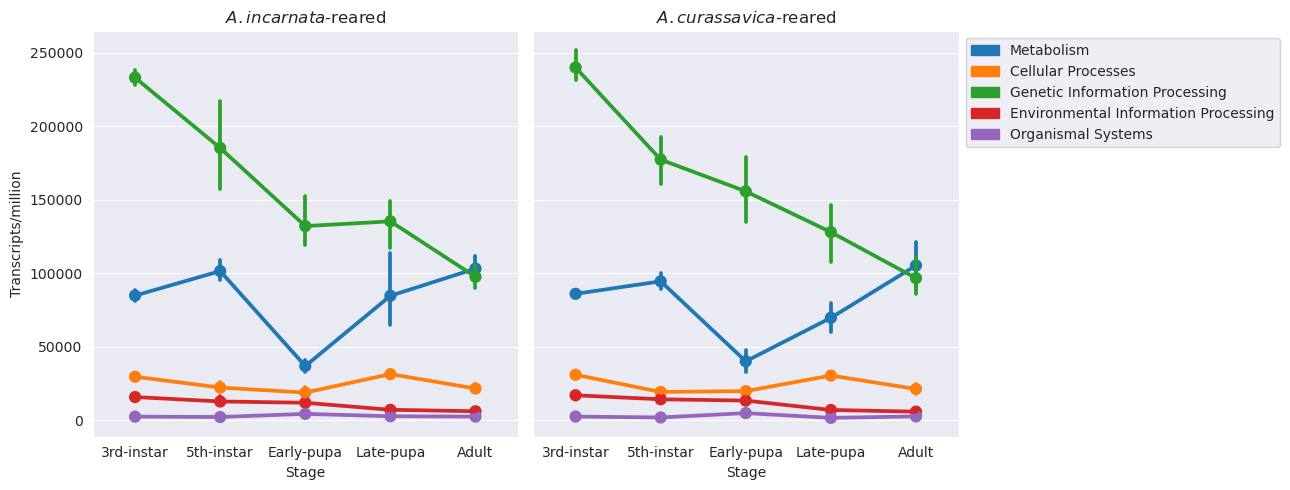

In [28]:
#separate cur and inc data

cur_function_level1_df = function_level1_df.loc[function_level1_df['plant'] == 'A. curassavica']
inc_function_level1_df = function_level1_df.loc[function_level1_df['plant'] == 'A. incarnata']

processes = list(function_level1_df.columns)[0:-2]

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(13, 5), sharey=True)

#define colors
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
#plot incarnata
for i in range(len(processes)):
    process = processes[i]
    sns.pointplot(data=inc_function_level1_df, x='developmental_stage', y=process, ax=ax1, color=colors[i])

ax1.set_title('$A. incarnata$-reared')
ax1.set_ylabel('Transcripts/million')
ax1.set_xlabel('Stage')

#plot curassavica
for i in range(len(processes)):
    process = processes[i]
    sns.pointplot(data=cur_function_level1_df, x='developmental_stage', y=process, ax=ax2, color=colors[i])

ax2.set_title('$A. curassavica$-reared')
ax2.set_ylabel('')
ax2.set_xlabel('Stage')

legend_cols = []
for i in range(len(processes)):
    process = processes[i]
    color = colors[i]
    patch = mpatches.Patch(color=color, label=process)
    legend_cols.append(patch)
    

plt.legend(handles=legend_cols, bbox_to_anchor=(1,1,0,0))

plt.tight_layout()

Interesting. It seems that cellular processes, environmental information processing, and organismal systems are relatively constant throughout development. This is interesting because things like the immune system are included in organismal systems.

It also seems like the relative investment in metabolism drops way down at the onset of pupation. There's also a pretty steady decline in genetic information processing. I think it will be interesting to look at each function individually now.

<a id='metabolism_across_dev'>

#### Metabolism

In [13]:
#initialize dataframes
#I'll do two separate dataframes. One that has genes that are explicitely related to metabolism and
#another for genes that are implied in other functions
metabolism_df = pd.DataFrame(index=uninfected_data.index)
metabolism_df_multi = pd.DataFrame(index=uninfected_data.index)
metabolism_exclusive_genes = []
multi_metabolism_genes = []

#list of groups to exclude
exclude = ['Human Diseases', 'Brite Hierarchies', 'Not Included in Pathway or Brite']

#iterate through gene ids
for gene_id in list(uninfected_data.columns):
    protein_id = gene_id.split('_')[2]
    gbid = protein_to_gene_dict[protein_id]
    
    #get function
    if gbid in dpl_kegg_dict:
        functions = dpl_kegg_dict[gbid]
        
        metabolism_groups = []
        for function in functions:
            functional_heirarchy = function['functional_heirarcy']
            level1 = functional_heirarchy['functional_group_level1']
            if level1 == 'Metabolism':
                level2 = functional_heirarchy['functional_group_level2']
                if level2 not in metabolism_groups:
                    metabolism_groups.append(level2)
            
        #add to explicit dataframe
        if len(metabolism_groups) == 1:
            metabolism_class = metabolism_groups[0]
            
            #if function is not alread in dataframe, add it with empty 0s
            if metabolism_class not in list(metabolism_df):
                metabolism_df[metabolism_class] = np.zeros(len(metabolism_df.index), dtype=int)
                
            #add values to appropriate column
            metabolism_df[metabolism_class] = metabolism_df[metabolism_class] + uninfected_data[gene_id]
            
            #add gene to list of metabolism only genes
            metabolism_exclusive_genes.append(gene_id)
            
        #add to multi group dataframe
        if len(metabolism_groups) > 0:
            #if function is not alread in dataframe, add it with empty 0s
            for metabolism_subclass in metabolism_groups:
                if metabolism_subclass not in list(metabolism_df_multi):
                    metabolism_df_multi[metabolism_subclass] = np.zeros(len(metabolism_df_multi.index), dtype=int)

                #add values to appropriate column
                metabolism_df_multi[metabolism_subclass] = metabolism_df_multi[metabolism_subclass] + uninfected_data[gene_id]
                multi_metabolism_genes.append(gene_id)

In [14]:
#now I need to add metadata
plant = []
developmental_stage = []

for sample in list(metabolism_df.index):
    plant_type = sample[6]
    stage = sample[5]
    
    if plant_type == 'c':
        plant.append('A. curassavica')
    elif plant_type == 'i':
        plant.append('A. incarnata')
    
    if stage == '3':
        developmental_stage.append('3rd-instar')
    elif stage == '5':
        developmental_stage.append('5th-instar')
    elif stage == 'E':
        developmental_stage.append('Early-pupa')
    elif stage == 'L':
        developmental_stage.append('Late-pupa')
    elif stage == 'A':
        developmental_stage.append('Adult')

#add metadata to dataframe

metabolism_df['plant'] = plant
metabolism_df['developmental_stage'] = developmental_stage

#sort data by transition order
dev_order = ['3rd-instar', '5th-instar', 'Early-pupa', 'Late-pupa', 'Adult']
metabolism_df['developmental_stage'] = pd.Categorical(metabolism_df['developmental_stage'], categories = dev_order)
metabolism_df = metabolism_df.sort_values(by='developmental_stage')

metabolism_df

Lipid metabolism  Carbohydrate metabolism  \
sample-id                                                
mtstp3iu81        5952.294547             12018.641592   
mtstp3cu2         6236.465088             11140.473485   
mtstp3iu85        5124.389511              7222.280528   
mtstp3cu5         5905.641110             10448.851167   
mtstp3cu4         5278.920380             10312.088652   
mtstp3cu3         5442.046934             10188.094571   
mtstp3cu8         5260.706426              9251.830131   
mtstp3iu83        5775.584010             12473.456481   
mtstp3iu82        5721.523620             10746.901054   
mtstp3iu84        5396.748578             11597.855826   
mtstp5iu101       5296.118919             14983.478687   
mtstp5iu99        4491.308217             14273.140208   
mtstp5iu97        4876.278240              7586.824546   
mtstp5cu20        4346.405885             13196.304422   
mtstp5cu19        5446.341742             14968.625578   
mtstp5cu21        4449.852524             13352.414410   
mtstp5iu98        5085.456712             15346.761848   
mtstp5cu18        5457.710438             12268.974648   
mtstp5cu17        4713.094961             13314.274319   
mtstp5iu100       5110.179178             14259.518062   
mtstpEcu35        2062.109791              4248.004131   
mtstpEiu115       1892.072956              3919.432660   
mtstpEiu116       2304.083005              3788.198018   
mtstpEiu117       2434.320239              4295.703053   
mtstpEcu38        2554.109757              4596.328683   
mtstpEcu33        2248.976177              4367.678851   
mtstpEiu114       1676.263767              3342.766099   
mtstpEcu34        1924.723508              3848.692310   
mtstpEcu36        2413.660844              4306.631874   
mtstpLiu130       2809.820796              9580.481761   
mtstpLiu129       3487.742510              8623.732829   
mtstpLiu133       2681.075454              7574.543822   
mtstpLiu135       2983.858443              6725.150649   
mtstpLcu50        3828.418305              9504.578917   
mtstpLcu56        2712.619174              7492.263056   
mtstpLcu49        3405.811705              9004.845231   
mtstpLcu53        3506.791690              6246.798645   
mtstpLiu131       4187.847674             15576.864744   
mtstpLcu52        3182.424921              8963.102265   
mtstpAiu147       5126.242593             14245.973336   
mtstpAiu149       5673.033482             14293.980997   
mtstpAiu145       4938.570851             11497.299191   
mtstpAiu148       5613.569318             12865.921483   
mtstpAcu67        3589.492791              9082.831699   
mtstpAcu68        6973.515986             15655.625822   
mtstpAcu69        5354.165056             13552.219894   
mtstpAiu146       5320.329553             13248.921645   
mtstpAcu65        4606.911699             10914.691188   
mtstpAcu66        5229.496963             14965.227942   

             Glycan biosynthesis and metabolism  Amino acid metabolism  \
sample-id                                                                
mtstp3iu81                          4215.968990            6445.788655   
mtstp3cu2                           4737.693273            5715.007765   
mtstp3iu85                          1513.426732            3850.653832   
mtstp3cu5                           4561.913317            5727.915512   
mtstp3cu4                           4012.171479            5710.434293   
mtstp3cu3                           3970.572142            5869.757691   
mtstp3cu8                           5014.918144            5219.376290   
mtstp3iu83                          4430.287987            6242.329403   
mtstp3iu82                          4237.524782            5998.496834   
mtstp3iu84                          3937.677996            6363.233727   
mtstp5iu101                         1365.357715            6780.587791   
mtstp5iu99                          2494.438074            7102.257309   
mtstp5iu97        

In [18]:
metabolism_df.to_csv('data/function_tables/metabolism_nonredundant.csv')

In [196]:
#now I need to add metadata
plant = []
developmental_stage = []

for sample in list(metabolism_df_multi.index):
    plant_type = sample[6]
    stage = sample[5]
    
    if plant_type == 'c':
        plant.append('A. curassavica')
    elif plant_type == 'i':
        plant.append('A. incarnata')
    
    if stage == '3':
        developmental_stage.append('3rd-instar')
    elif stage == '5':
        developmental_stage.append('5th-instar')
    elif stage == 'E':
        developmental_stage.append('Early-pupa')
    elif stage == 'L':
        developmental_stage.append('Late-pupa')
    elif stage == 'A':
        developmental_stage.append('Adult')

#add metadata to dataframe

metabolism_df_multi['plant'] = plant
metabolism_df_multi['developmental_stage'] = developmental_stage

#sort data by transition order
dev_order = ['3rd-instar', '5th-instar', 'Early-pupa', 'Late-pupa', 'Adult']
metabolism_df_multi['developmental_stage'] = pd.Categorical(metabolism_df_multi['developmental_stage'], categories = dev_order)
metabolism_df_multi = metabolism_df_multi.sort_values(by='developmental_stage')

metabolism_df_multi

Lipid metabolism  Carbohydrate metabolism  \
sample-id                                                
mtstp3iu81       13525.720741             22473.376246   
mtstp3cu2        13302.153366             20669.778482   
mtstp3iu85        9689.094532             13822.951060   
mtstp3cu5        14079.812268             19585.960564   
mtstp3cu4        13534.961160             19752.401820   
mtstp3cu3        12827.403885             19630.048075   
mtstp3cu8        11888.904362             17594.410348   
mtstp3iu83       13360.434953             22230.745063   
mtstp3iu82       12157.349577             19958.405779   
mtstp3iu84       13264.706684             21797.576028   
mtstp5iu101      60420.742929             29025.756425   
mtstp5iu99       20677.669100             26340.310271   
mtstp5iu97       59778.149397             13795.136267   
mtstp5cu20       15327.620119             25729.978085   
mtstp5cu19       40611.205572             29202.946098   
mtstp5cu21       18825.679378             27038.154211   
mtstp5iu98       22215.941923             28764.150590   
mtstp5cu18       42504.407797             25997.127998   
mtstp5cu17       16494.772088             25736.261801   
mtstp5iu100      20662.298036             27102.194350   
mtstpEcu35       19656.192007              7183.619452   
mtstpEiu115      23161.135992              6533.343253   
mtstpEiu116      10721.651585              6803.610424   
mtstpEiu117      14940.470929              7622.183113   
mtstpEcu38       16214.658713              7851.867432   
mtstpEcu33       31789.995448              7339.936489   
mtstpEiu114      16770.799031              5475.946896   
mtstpEcu34       10817.342074              6303.923295   
mtstpEcu36       12588.922015              7363.131223   
mtstpLiu130       7192.806257             14653.189278   
mtstpLiu129       7553.276306             13609.804551   
mtstpLiu133       6975.760329             12304.256416   
mtstpLiu135       7672.436078             12033.576568   
mtstpLcu50        6285.138977             14952.885046   
mtstpLcu56        6281.711747             12520.367228   
mtstpLcu49        6626.529418             14685.359728   
mtstpLcu53        5244.888284              9836.483965   
mtstpLiu131       7746.518036             23223.352321   
mtstpLcu52        8067.023074             14303.007402   
mtstpAiu147       8597.471685             21567.630810   
mtstpAiu149       9143.031172             22142.166263   
mtstpAiu145       7998.580678             17644.255169   
mtstpAiu148       9380.394538             20561.182131   
mtstpAcu67        6066.711894             14198.453862   
mtstpAcu68       10669.789162             23537.649242   
mtstpAcu69        8763.883393             21126.903270   
mtstpAiu146       8713.221052             19932.745676   
mtstpAcu65        7664.277834             16531.701434   
mtstpAcu66        8434.865597             22311.271943   

             Glycan biosynthesis and metabolism  Amino acid metabolism  \
sample-id                                                                
mtstp3iu81                          4817.419260           16193.682631   
mtstp3cu2                           5452.382353           14168.832442   
mtstp3iu85                          1648.114802           10641.664471   
mtstp3cu5                           5129.690867           14123.534512   
mtstp3cu4                           4719.042757           14219.811552   
mtstp3cu3                           4534.089082           14472.974664   
mtstp3cu8                           5725.151794           12788.667974   
mtstp3iu83                          5074.322917           15204.407575   
mtstp3iu82                          4852.324552           14296.443216   
mtstp3iu84                          4661.277546           15346.600561   
mtstp5iu101                         6089.936335           16441.445483   
mtstp5iu99                          3256.531497           18438.606786   
mtstp5iu97        

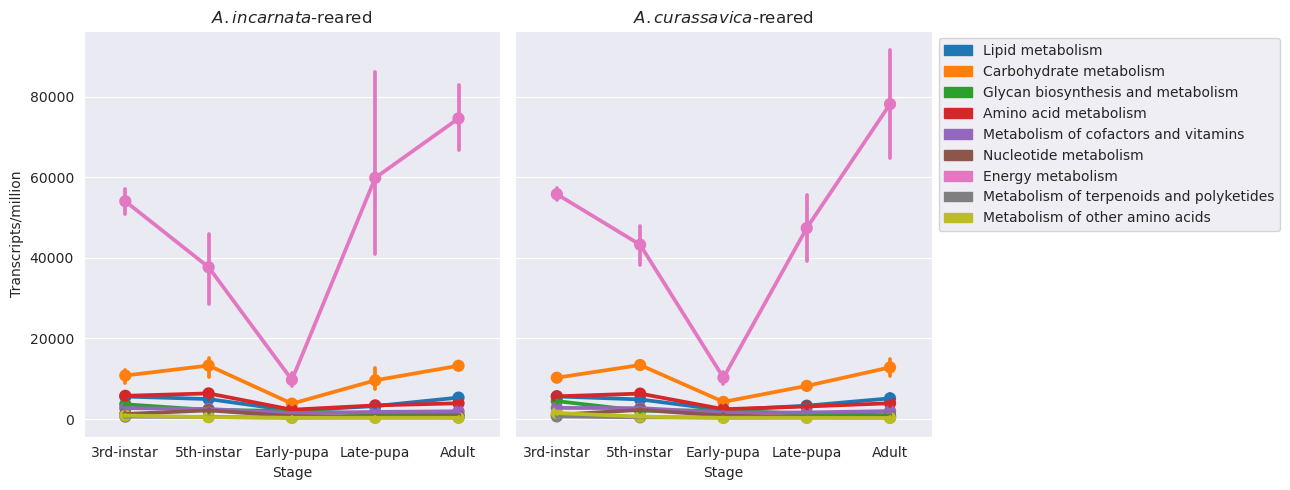

In [201]:
#separate cur and inc data

cur_metabolism_df = metabolism_df.loc[metabolism_df['plant'] == 'A. curassavica']
inc_metabolism_df = metabolism_df.loc[metabolism_df['plant'] == 'A. incarnata']

processes = list(metabolism_df.columns)[0:-2]

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(13, 5), sharey=True)

#define colors
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'black']
#plot incarnata
for i in range(len(processes)):
    process = processes[i]
    sns.pointplot(data=inc_metabolism_df, x='developmental_stage', y=process, ax=ax1, color=colors[i])

ax1.set_title('$A. incarnata$-reared')
ax1.set_ylabel('Transcripts/million')
ax1.set_xlabel('Stage')

#plot curassavica
for i in range(len(processes)):
    process = processes[i]
    sns.pointplot(data=cur_metabolism_df, x='developmental_stage', y=process, ax=ax2, color=colors[i])

ax2.set_title('$A. curassavica$-reared')
ax2.set_ylabel('')
ax2.set_xlabel('Stage')

legend_cols = []
for i in range(len(processes)):
    process = processes[i]
    color = colors[i]
    patch = mpatches.Patch(color=color, label=process)
    legend_cols.append(patch)
    

plt.legend(handles=legend_cols, bbox_to_anchor=(1,1,0,0))

plt.tight_layout()

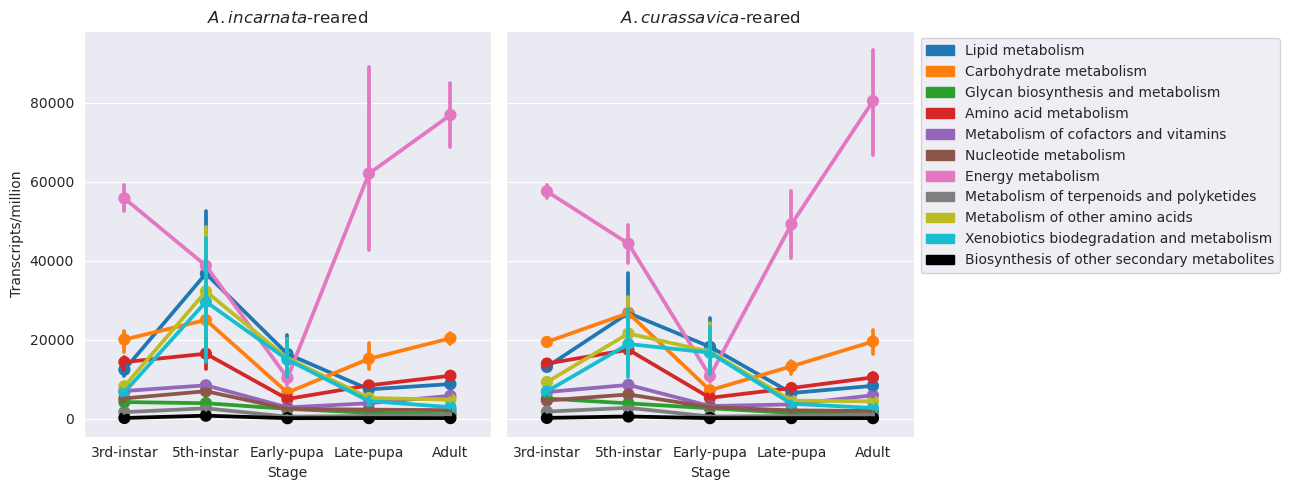

In [200]:
#separate cur and inc data

cur_metabolism_df = metabolism_df_multi.loc[metabolism_df_multi['plant'] == 'A. curassavica']
inc_metabolism_df = metabolism_df_multi.loc[metabolism_df_multi['plant'] == 'A. incarnata']

processes = list(metabolism_df_multi.columns)[0:-2]

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(13, 5), sharey=True)

#define colors
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'black']
#plot incarnata
for i in range(len(processes)):
    process = processes[i]
    sns.pointplot(data=inc_metabolism_df, x='developmental_stage', y=process, ax=ax1, color=colors[i])

ax1.set_title('$A. incarnata$-reared')
ax1.set_ylabel('Transcripts/million')
ax1.set_xlabel('Stage')

#plot curassavica
for i in range(len(processes)):
    process = processes[i]
    sns.pointplot(data=cur_metabolism_df, x='developmental_stage', y=process, ax=ax2, color=colors[i])

ax2.set_title('$A. curassavica$-reared')
ax2.set_ylabel('')
ax2.set_xlabel('Stage')

legend_cols = []
for i in range(len(processes)):
    process = processes[i]
    color = colors[i]
    patch = mpatches.Patch(color=color, label=process)
    legend_cols.append(patch)
    

plt.legend(handles=legend_cols, bbox_to_anchor=(1,1,0,0))

plt.tight_layout()

The metabolism exclusive and multi-functional metabolism results show largely the same thing. The same general trend in energy metabolism is the most apparent.

In [39]:
#sort data by transition order
sorted_df = uninfected_data

#now I need to add metadata
plant = []
developmental_stage = []

for sample in list(sorted_df.index):
    plant_type = sample[6]
    stage = sample[5]
    
    if plant_type == 'c':
        plant.append('A. curassavica')
    elif plant_type == 'i':
        plant.append('A. incarnata')
    
    if stage == '3':
        developmental_stage.append('3rd-instar')
    elif stage == '5':
        developmental_stage.append('5th-instar')
    elif stage == 'E':
        developmental_stage.append('Early-pupa')
    elif stage == 'L':
        developmental_stage.append('Late-pupa')
    elif stage == 'A':
        developmental_stage.append('Adult')

#add metadata to dataframe

sorted_df['plant'] = plant
sorted_df['developmental_stage'] = developmental_stage

dev_order = ['3rd-instar', '5th-instar', 'Early-pupa', 'Late-pupa', 'Adult']
sorted_df['developmental_stage'] = pd.Categorical(sorted_df['developmental_stage'], categories = dev_order)
sorted_df = sorted_df.sort_values(by='developmental_stage')

/tmp/ipykernel_80333/168309081.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sorted_df['plant'] = plant
/tmp/ipykernel_80333/168309081.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sorted_df['plant'] = plant
/tmp/ipykernel_80333/168309081.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = 

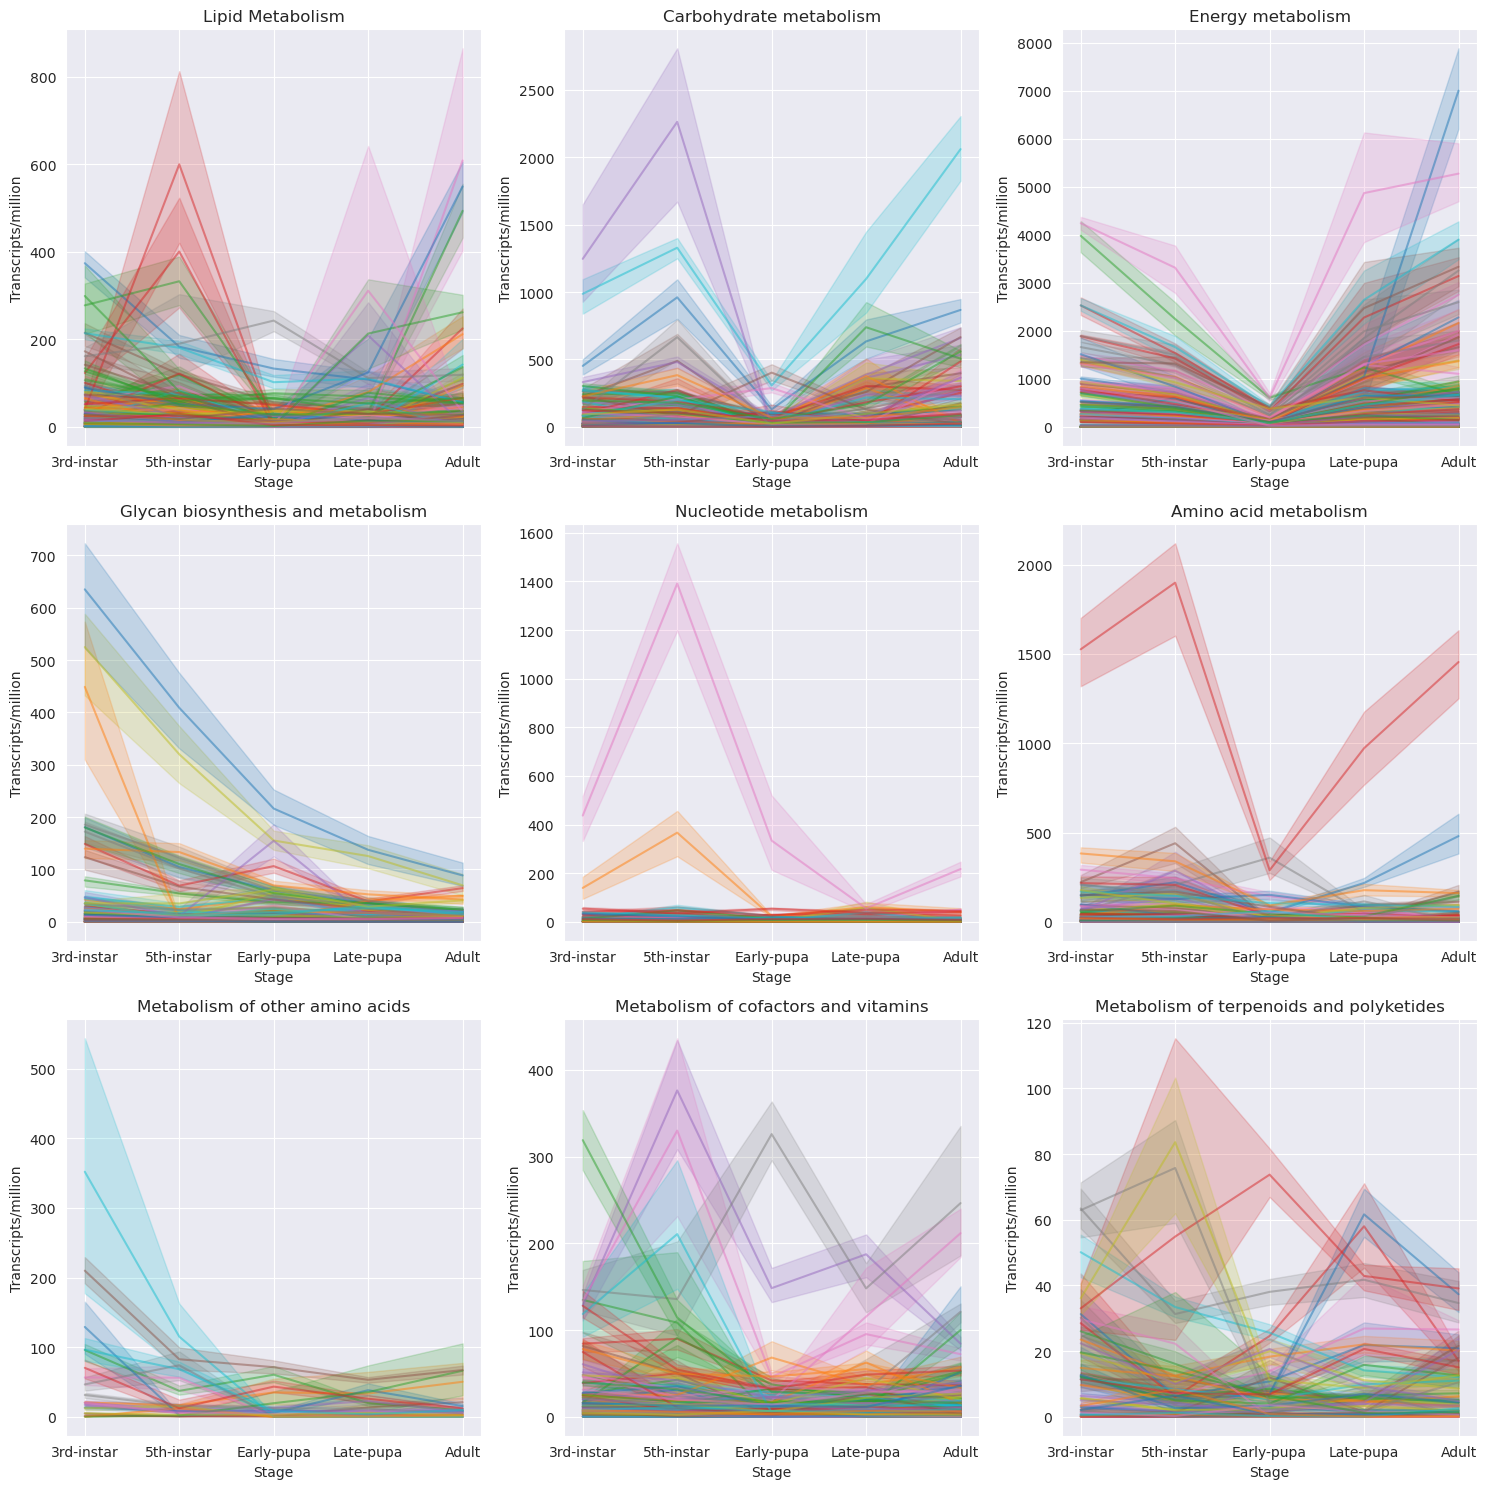

In [203]:
#and now to plot the actual expression of metabolism genes
fig, [[ax1,ax2,ax3], [ax4,ax5,ax6], [ax7,ax8,ax9]] = plt.subplots(3, 3, figsize=(15, 15))

for gene_id in metabolism_exclusive_genes:
    protein_id = gene_id.split('_')[2]
    gbid = protein_to_gene_dict[protein_id]
    
    #get function
    if gbid in dpl_kegg_dict:
        functions = dpl_kegg_dict[gbid]
        
        metabolism_groups = []
        for function in functions:
            functional_heirarchy = function['functional_heirarcy']
            level1 = functional_heirarchy['functional_group_level1']
            if level1 == 'Metabolism':
                level2 = functional_heirarchy['functional_group_level2']
                if level2 not in metabolism_groups:
                    metabolism_groups.append(level2)
            
        #add to explicit dataframe
        if len(metabolism_groups) == 1:
            metabolism_class = metabolism_groups[0]
            
            if metabolism_class == 'Lipid metabolism':
                sns.lineplot(data = sorted_df, x='developmental_stage', y=gene_id, ax=ax1, alpha=0.5)
            elif metabolism_class == 'Carbohydrate metabolism':
                sns.lineplot(data = sorted_df, x='developmental_stage', y=gene_id, ax=ax2, alpha=0.5)
            elif metabolism_class == 'Energy metabolism':
                sns.lineplot(data = sorted_df, x='developmental_stage', y=gene_id, ax=ax3, alpha=0.5)
            elif metabolism_class == 'Glycan biosynthesis and metabolism':
                sns.lineplot(data = sorted_df, x='developmental_stage', y=gene_id, ax=ax4, alpha=0.5)
            elif metabolism_class == 'Nucleotide metabolism':
                sns.lineplot(data = sorted_df, x='developmental_stage', y=gene_id, ax=ax5, alpha=0.5)              
            elif metabolism_class == 'Amino acid metabolism':
                sns.lineplot(data = sorted_df, x='developmental_stage', y=gene_id, ax=ax6, alpha=0.5)
            elif metabolism_class == 'Metabolism of other amino acids':
                sns.lineplot(data = sorted_df, x='developmental_stage', y=gene_id, ax=ax7, alpha=0.5)
            elif metabolism_class == 'Metabolism of cofactors and vitamins':
                sns.lineplot(data = sorted_df, x='developmental_stage', y=gene_id, ax=ax8, alpha=0.5)
            elif metabolism_class == 'Metabolism of terpenoids and polyketides':
                sns.lineplot(data = sorted_df, x='developmental_stage', y=gene_id, ax=ax9, alpha=0.5)

ax1.set_ylabel('Transcripts/million')
ax1.set_xlabel('Stage')
ax1.set_title('Lipid Metabolism')

ax2.set_ylabel('Transcripts/million')
ax2.set_xlabel('Stage')
ax2.set_title('Carbohydrate metabolism')

ax3.set_ylabel('Transcripts/million')
ax3.set_xlabel('Stage')
ax3.set_title('Energy metabolism')

ax4.set_ylabel('Transcripts/million')
ax4.set_xlabel('Stage')
ax4.set_title('Glycan biosynthesis and metabolism')

ax5.set_ylabel('Transcripts/million')
ax5.set_xlabel('Stage')
ax5.set_title('Nucleotide metabolism')

ax6.set_ylabel('Transcripts/million')
ax6.set_xlabel('Stage')
ax6.set_title('Amino acid metabolism')

ax7.set_ylabel('Transcripts/million')
ax7.set_xlabel('Stage')
ax7.set_title('Metabolism of other amino acids')

ax8.set_ylabel('Transcripts/million')
ax8.set_xlabel('Stage')
ax8.set_title('Metabolism of cofactors and vitamins')

ax9.set_ylabel('Transcripts/million')
ax9.set_xlabel('Stage')
ax9.set_title('Metabolism of terpenoids and polyketides')

plt.tight_layout()

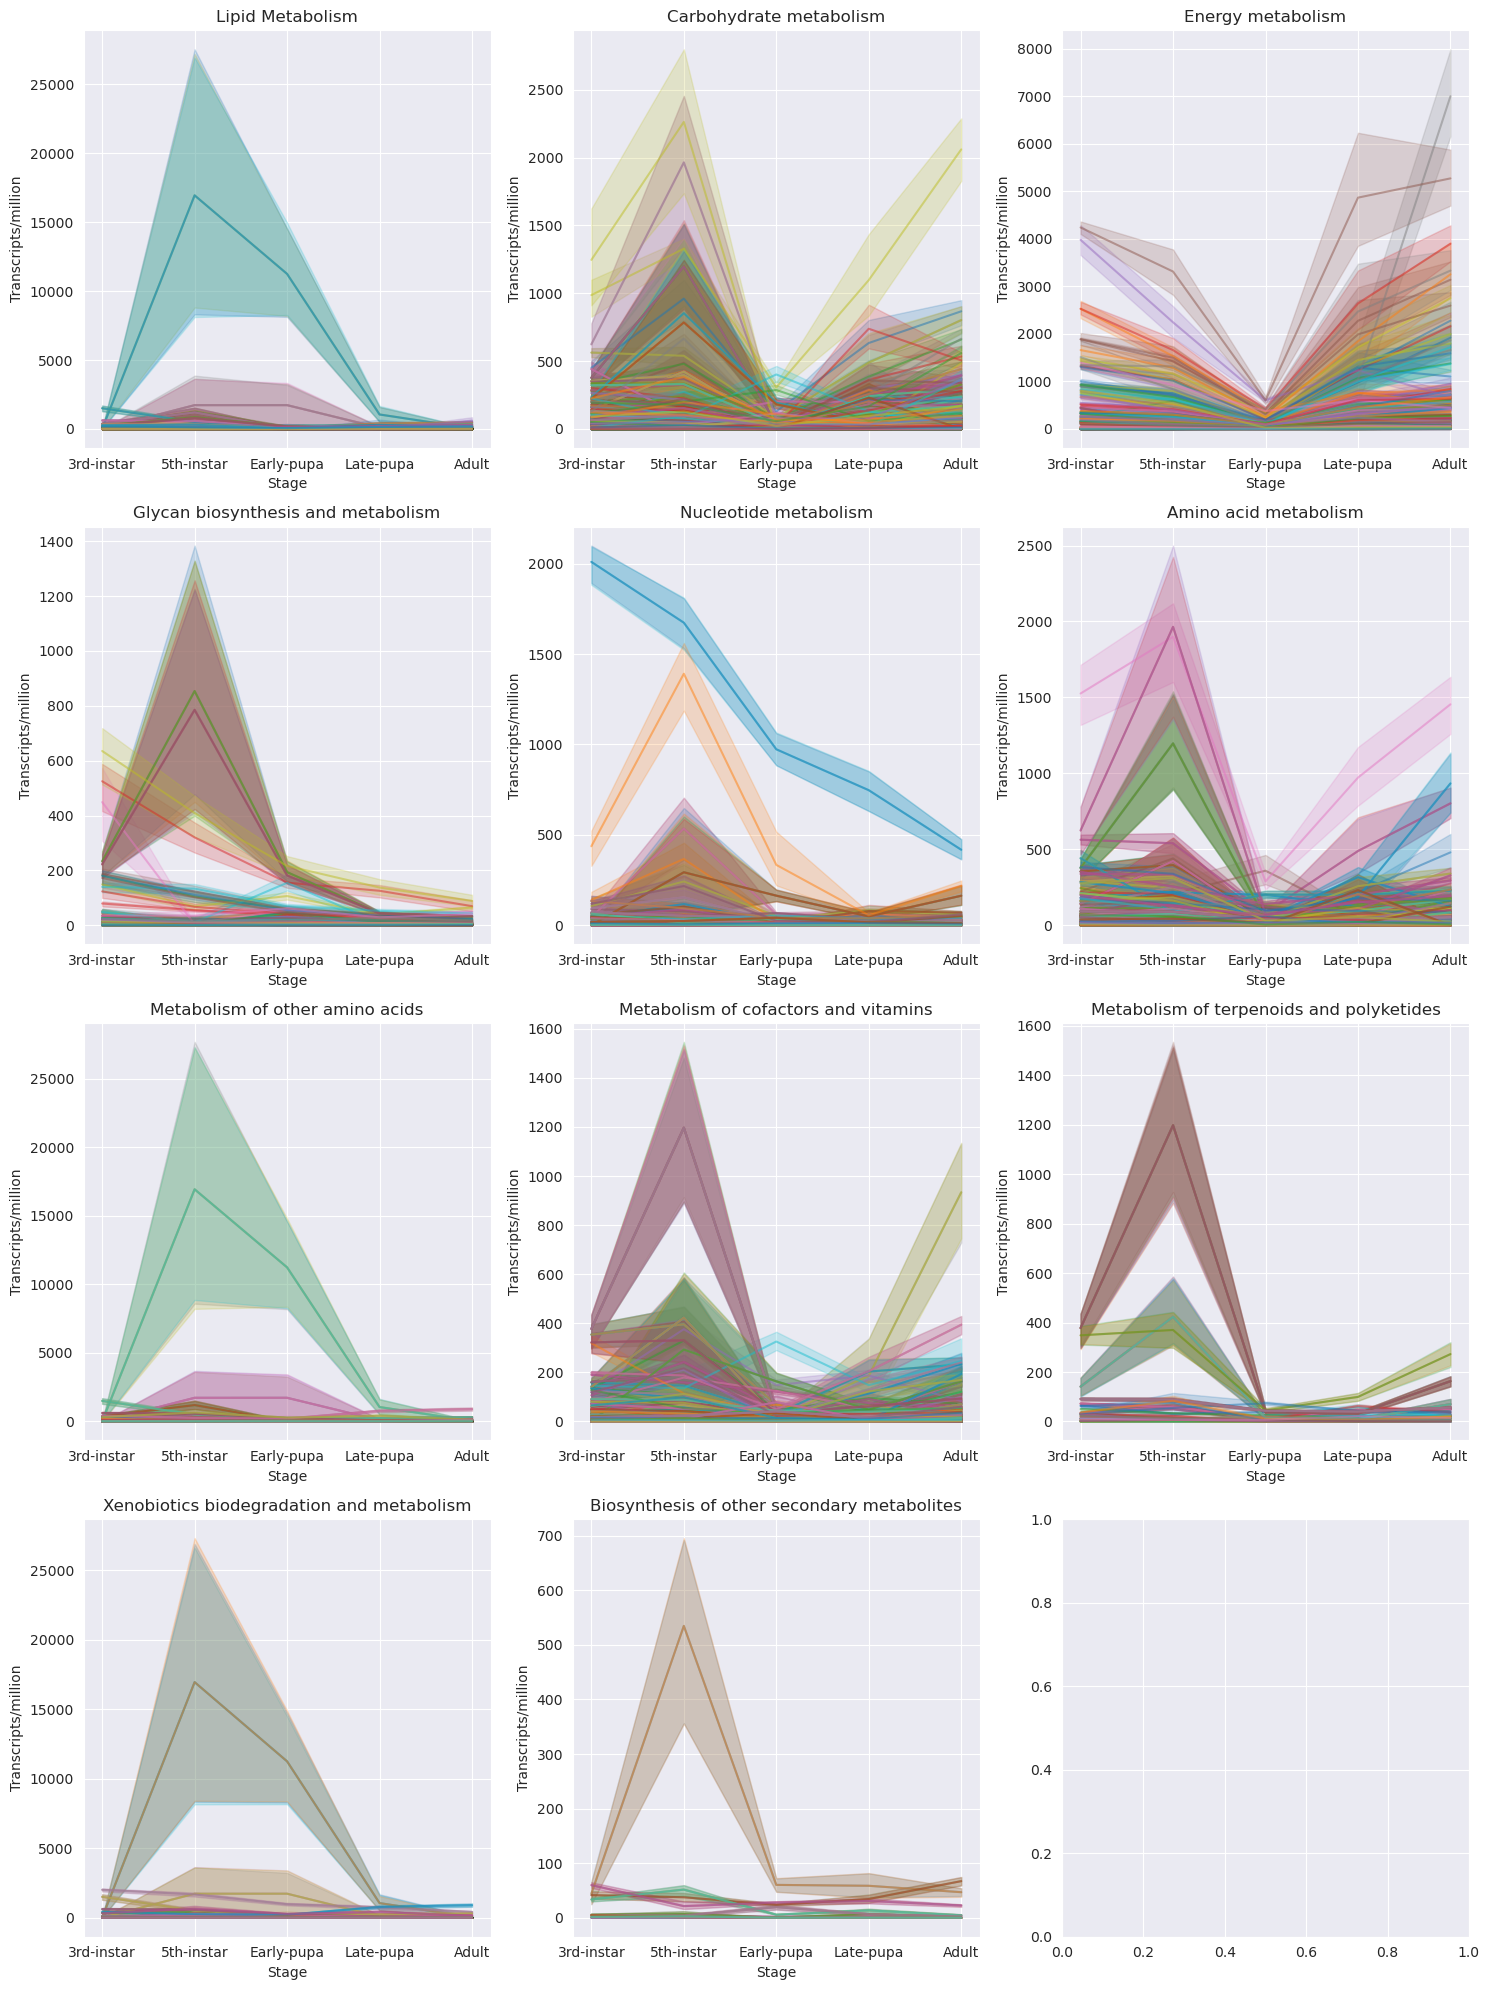

In [205]:
#and now to plot the actual expression of metabolism genes (that are implied in multiple types of metabolism)
fig, [[ax1,ax2,ax3], [ax4,ax5,ax6], [ax7,ax8,ax9], [ax10, ax11, ax12]] = plt.subplots(4, 3, figsize=(15, 20))

for gene_id in multi_metabolism_genes:
    protein_id = gene_id.split('_')[2]
    gbid = protein_to_gene_dict[protein_id]
    
    #get function
    if gbid in dpl_kegg_dict:
        functions = dpl_kegg_dict[gbid]
        
        metabolism_groups = []
        for function in functions:
            functional_heirarchy = function['functional_heirarcy']
            level1 = functional_heirarchy['functional_group_level1']
            if level1 == 'Metabolism':
                level2 = functional_heirarchy['functional_group_level2']
                if level2 not in metabolism_groups:
                    metabolism_groups.append(level2)
            
        #add to explicit dataframe
        if len(metabolism_groups) >= 1:
            for subclass in metabolism_groups:
                metabolism_class = subclass
            
                if metabolism_class == 'Lipid metabolism':
                    sns.lineplot(data = sorted_df, x='developmental_stage', y=gene_id, ax=ax1, alpha=0.5)
                elif metabolism_class == 'Carbohydrate metabolism':
                    sns.lineplot(data = sorted_df, x='developmental_stage', y=gene_id, ax=ax2, alpha=0.5)
                elif metabolism_class == 'Energy metabolism':
                    sns.lineplot(data = sorted_df, x='developmental_stage', y=gene_id, ax=ax3, alpha=0.5)
                elif metabolism_class == 'Glycan biosynthesis and metabolism':
                    sns.lineplot(data = sorted_df, x='developmental_stage', y=gene_id, ax=ax4, alpha=0.5)
                elif metabolism_class == 'Nucleotide metabolism':
                    sns.lineplot(data = sorted_df, x='developmental_stage', y=gene_id, ax=ax5, alpha=0.5)              
                elif metabolism_class == 'Amino acid metabolism':
                    sns.lineplot(data = sorted_df, x='developmental_stage', y=gene_id, ax=ax6, alpha=0.5)
                elif metabolism_class == 'Metabolism of other amino acids':
                    sns.lineplot(data = sorted_df, x='developmental_stage', y=gene_id, ax=ax7, alpha=0.5)
                elif metabolism_class == 'Metabolism of cofactors and vitamins':
                    sns.lineplot(data = sorted_df, x='developmental_stage', y=gene_id, ax=ax8, alpha=0.5)
                elif metabolism_class == 'Metabolism of terpenoids and polyketides':
                    sns.lineplot(data = sorted_df, x='developmental_stage', y=gene_id, ax=ax9, alpha=0.5)
                elif metabolism_class == 'Xenobiotics biodegradation and metabolism':
                    sns.lineplot(data = sorted_df, x='developmental_stage', y=gene_id, ax=ax10, alpha=0.5)
                elif metabolism_class == 'Biosynthesis of other secondary metabolites':
                    sns.lineplot(data = sorted_df, x='developmental_stage', y=gene_id, ax=ax11, alpha=0.5)

ax1.set_ylabel('Transcripts/million')
ax1.set_xlabel('Stage')
ax1.set_title('Lipid Metabolism')

ax2.set_ylabel('Transcripts/million')
ax2.set_xlabel('Stage')
ax2.set_title('Carbohydrate metabolism')

ax3.set_ylabel('Transcripts/million')
ax3.set_xlabel('Stage')
ax3.set_title('Energy metabolism')

ax4.set_ylabel('Transcripts/million')
ax4.set_xlabel('Stage')
ax4.set_title('Glycan biosynthesis and metabolism')

ax5.set_ylabel('Transcripts/million')
ax5.set_xlabel('Stage')
ax5.set_title('Nucleotide metabolism')

ax6.set_ylabel('Transcripts/million')
ax6.set_xlabel('Stage')
ax6.set_title('Amino acid metabolism')

ax7.set_ylabel('Transcripts/million')
ax7.set_xlabel('Stage')
ax7.set_title('Metabolism of other amino acids')

ax8.set_ylabel('Transcripts/million')
ax8.set_xlabel('Stage')
ax8.set_title('Metabolism of cofactors and vitamins')

ax9.set_ylabel('Transcripts/million')
ax9.set_xlabel('Stage')
ax9.set_title('Metabolism of terpenoids and polyketides')

ax10.set_ylabel('Transcripts/million')
ax10.set_xlabel('Stage')
ax10.set_title('Xenobiotics biodegradation and metabolism')

ax11.set_ylabel('Transcripts/million')
ax11.set_xlabel('Stage')
ax11.set_title('Biosynthesis of other secondary metabolites')

plt.tight_layout()

<a id='genetic_information_processing_across_dev'>

#### Genetic Information Processing

In [15]:
#initialize dataframe
genetic_df = pd.DataFrame(index=uninfected_data.index)
genetic_df_multi = pd.DataFrame(index=uninfected_data.index)
genetic_genes = []
multi_genetic_genes = []

#list of groups to exclude
exclude = ['Human Diseases', 'Brite Hierarchies', 'Not Included in Pathway or Brite']

#iterate through gene ids
for gene_id in list(uninfected_data.columns):
    protein_id = gene_id.split('_')[2]
    gbid = protein_to_gene_dict[protein_id]
    
    #get function
    if gbid in dpl_kegg_dict:
        functions = dpl_kegg_dict[gbid]
        
        genetic_groups = []
        for function in functions:
            functional_heirarchy = function['functional_heirarcy']
            level1 = functional_heirarchy['functional_group_level1']
            if level1 == 'Genetic Information Processing':
                level2 = functional_heirarchy['functional_group_level2']
                if level2 not in genetic_groups:
                    genetic_groups.append(level2)
            
        #as with before, we'll exclude genes that hit to multiple categories. This should
        #still give us a relative idea of what's going on
        if len(genetic_groups) == 1:
            genetic_class = genetic_groups[0]
            
            #if function is not alread in dataframe, add it with empty 0s
            if genetic_class not in list(genetic_df):
                genetic_df[genetic_class] = np.zeros(len(genetic_df.index), dtype=int)
                
            #add values to appropriate column
            genetic_df[genetic_class] = genetic_df[genetic_class] + uninfected_data[gene_id]
            genetic_genes.append(gene_id)
            
        if len(genetic_groups) > 0:
            for genetic_subclass in genetic_groups:
                
                if genetic_class not in list(genetic_df):
                    genetic_df[genetic_class] = np.zeros(len(genetic_df.index), dtype=int)
                    
                    #add values to appropriate column
                    genetic_df[genetic_class] = genetic_df[genetic_class] + uninfected_data[gene_id]
                    multi_genetic_genes.append(gene_id)


In [16]:
#now I need to add metadata
plant = []
developmental_stage = []

for sample in list(genetic_df.index):
    plant_type = sample[6]
    stage = sample[5]
    
    if plant_type == 'c':
        plant.append('A. curassavica')
    elif plant_type == 'i':
        plant.append('A. incarnata')
    
    if stage == '3':
        developmental_stage.append('3rd-instar')
    elif stage == '5':
        developmental_stage.append('5th-instar')
    elif stage == 'E':
        developmental_stage.append('Early-pupa')
    elif stage == 'L':
        developmental_stage.append('Late-pupa')
    elif stage == 'A':
        developmental_stage.append('Adult')

#add metadata to dataframe

genetic_df['plant'] = plant
genetic_df['developmental_stage'] = developmental_stage

#sort data by transition order
dev_order = ['3rd-instar', '5th-instar', 'Early-pupa', 'Late-pupa', 'Adult']
genetic_df['developmental_stage'] = pd.Categorical(genetic_df['developmental_stage'], categories = dev_order)
genetic_df = genetic_df.sort_values(by='developmental_stage')

genetic_df

Folding, sorting and degradation    Translation  \
sample-id                                                      
mtstp3iu81                       36476.795670  203048.102627   
mtstp3cu2                        38626.627705  199932.414612   
mtstp3iu85                       17798.814442  205538.759761   
mtstp3cu5                        49562.953686  199764.675745   
mtstp3cu4                        46861.529712  193742.987502   
mtstp3cu3                        39272.798937  193202.102659   
mtstp3cu8                        41785.895676  223273.880730   
mtstp3iu83                       36731.776922  196232.516816   
mtstp3iu82                       39367.851335  206549.298360   
mtstp3iu84                       37609.664083  197554.914429   
mtstp5iu101                      20608.722786  125499.007399   
mtstp5iu99                       28455.646959  163658.551608   
mtstp5iu97                       34378.884224  208168.121815   
mtstp5cu20                       29407.323005  182098.631145   
mtstp5cu19                       23870.604462  143054.685753   
mtstp5cu21                       28534.076148  169793.829147   
mtstp5iu98                       29365.360963  158939.888798   
mtstp5cu18                       26901.434435  133489.017554   
mtstp5cu17                       27070.382506  165217.077422   
mtstp5iu100                      25431.857231  163436.154157   
mtstpEcu35                       15928.825779  125569.193934   
mtstpEiu115                      14512.952149  103314.542142   
mtstpEiu116                      17986.404989  107775.976991   
mtstpEiu117                      19417.988703  141435.768895   
mtstpEcu38                       21628.355597  170134.599240   
mtstpEcu33                       16508.123194  145824.589325   
mtstpEiu114                      13245.703722  102391.162230   
mtstpEcu34                       14072.119295  105668.166893   
mtstpEcu36                       20413.208111  129890.179571   
mtstpLiu130                      15259.405849  140568.981539   
mtstpLiu129                      12969.940729  124722.250746   
mtstpLiu133                      13947.882279  127147.459988   
mtstpLiu135                      16742.497210  125155.017474   
mtstpLcu50                       11290.392021   96846.797149   
mtstpLcu56                       15171.091461  122006.686796   
mtstpLcu49                       15194.841610  131492.562061   
mtstpLcu53                        9385.468273   84311.275695   
mtstpLiu131                      10045.556070   91840.138301   
mtstpLcu52                       15618.367476  140070.753821   
mtstpAiu147                      12794.036227   90694.427666   
mtstpAiu149                      11409.217874   75467.509799   
mtstpAiu145                      11214.039946   78590.132281   
mtstpAiu148                      15779.229486   91665.897080   
mtstpAcu67                        8769.461766   73244.817358   
mtstpAcu68                       16557.031833  109344.039861   
mtstpAcu69                       13198.793844   81176.861223   
mtstpAiu146                      13203.446106   95000.037540   
mtstpAcu65                       14723.834216   84362.012403   
mtstpAcu66                       10500.681037   83628.697542   

             Replication and repair   Chromosome  Transcription  \
sample-id                                                         
mtstp3iu81               851.252546  5619.960520    5308.711144   
mtstp3cu2                906.755295  6327.484482    5955.513578   
mtstp3iu85               498.044109  2994.950819    3755.835303   
mtstp3cu5                776.951720  5236.644132    5495.472870   
mtstp3cu4                828.696540  5966.675437    5352.080780   
mtstp3cu3                822.982526  5825.832770    5067.344978   
mtstp3cu8                922.773478  6563.609386    6020.336127   
mtstp3iu83               915.807502  5617.834742    5677.567500   
mtstp3iu82               797.704316  5141.316735    5429.672872   
mtstp3iu84 

In [21]:
genetic_df.to_csv('data/function_tables/genetic_information_processing_nonredundant.csv')

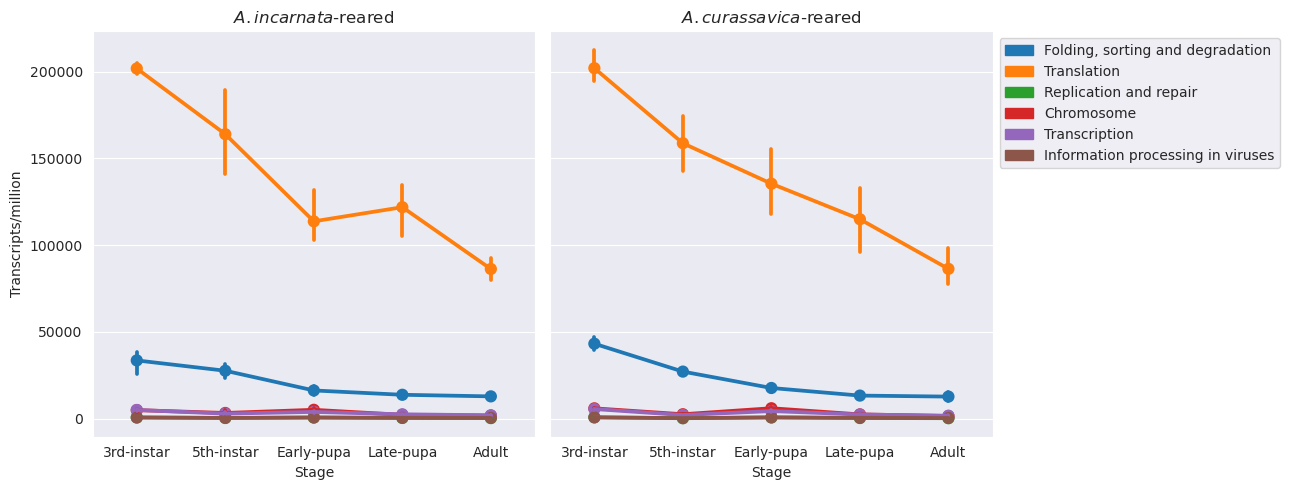

In [23]:
#separate cur and inc data
sns.set_style('darkgrid')
cur_genetic_df = genetic_df.loc[genetic_df['plant'] == 'A. curassavica']
inc_genetic_df = genetic_df.loc[genetic_df['plant'] == 'A. incarnata']

processes = list(genetic_df.columns)[0:-2]

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(13, 5), sharey=True)

#define colors
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive']
#plot incarnata
for i in range(len(processes)):
    process = processes[i]
    sns.pointplot(data=inc_genetic_df, x='developmental_stage', y=process, ax=ax1, color=colors[i])

ax1.set_title('$A. incarnata$-reared')
ax1.set_ylabel('Transcripts/million')
ax1.set_xlabel('Stage')

#plot curassavica
for i in range(len(processes)):
    process = processes[i]
    sns.pointplot(data=cur_genetic_df, x='developmental_stage', y=process, ax=ax2, color=colors[i])

ax2.set_title('$A. curassavica$-reared')
ax2.set_ylabel('')
ax2.set_xlabel('Stage')

legend_cols = []
for i in range(len(processes)):
    process = processes[i]
    color = colors[i]
    patch = mpatches.Patch(color=color, label=process)
    legend_cols.append(patch)

plt.legend(handles=legend_cols, bbox_to_anchor=(1,1,0,0))

plt.tight_layout()

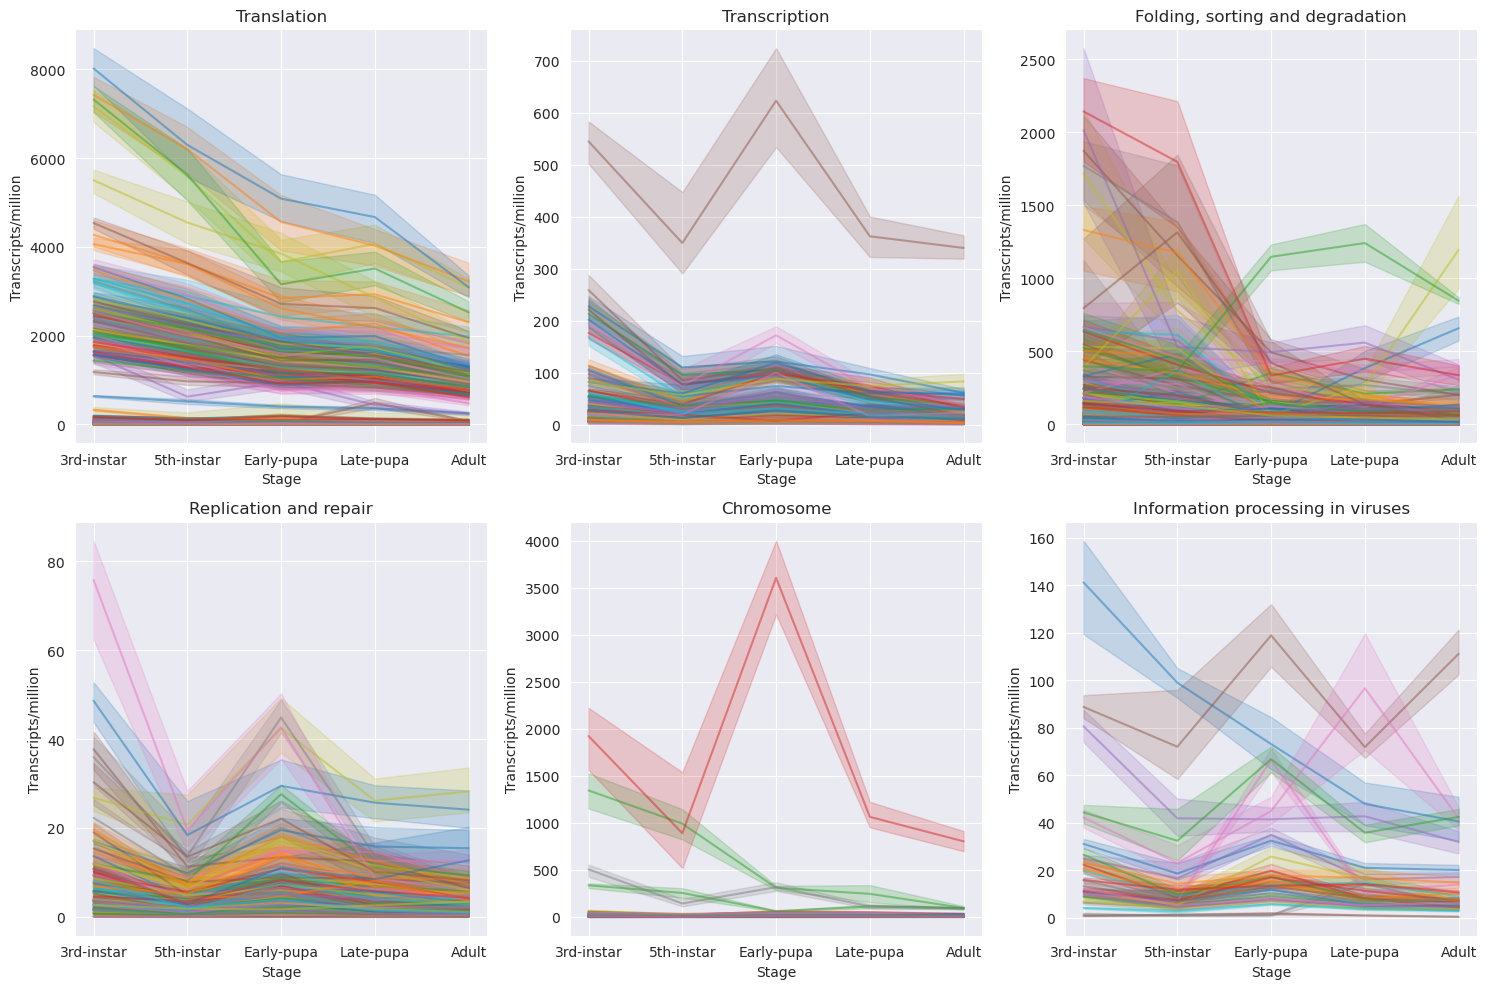

In [237]:
#and now to plot the actual expression of genetic processing genes
fig, [[ax1,ax2,ax3], [ax4,ax5,ax6]] = plt.subplots(2, 3, figsize=(15, 10))

for gene_id in genetic_genes:
    protein_id = gene_id.split('_')[2]
    gbid = protein_to_gene_dict[protein_id]
    
    #get function
    if gbid in dpl_kegg_dict:
        functions = dpl_kegg_dict[gbid]
        
        genetic_groups = []
        for function in functions:
            functional_heirarchy = function['functional_heirarcy']
            level1 = functional_heirarchy['functional_group_level1']
            if level1 == 'Genetic Information Processing':
                level2 = functional_heirarchy['functional_group_level2']
                if level2 not in genetic_groups:
                    genetic_groups.append(level2)
            
        #add to explicit dataframe
        if len(genetic_groups) > 0:
            
            for genetic_class in genetic_groups:
                if genetic_class == 'Translation':
                    sns.lineplot(data = sorted_df, x='developmental_stage', y=gene_id, ax=ax1, alpha=0.5)
                elif genetic_class == 'Transcription':
                    sns.lineplot(data = sorted_df, x='developmental_stage', y=gene_id, ax=ax2, alpha=0.5)
                elif genetic_class == 'Folding, sorting and degradation':
                    sns.lineplot(data = sorted_df, x='developmental_stage', y=gene_id, ax=ax3, alpha=0.5)
                elif genetic_class == 'Replication and repair':
                    sns.lineplot(data = sorted_df, x='developmental_stage', y=gene_id, ax=ax4, alpha=0.5)
                elif genetic_class == 'Chromosome':
                    sns.lineplot(data = sorted_df, x='developmental_stage', y=gene_id, ax=ax5, alpha=0.5)              
                elif genetic_class == 'Information processing in viruses':
                    sns.lineplot(data = sorted_df, x='developmental_stage', y=gene_id, ax=ax6, alpha=0.5)

ax1.set_ylabel('Transcripts/million')
ax1.set_xlabel('Stage')
ax1.set_title('Translation')

ax2.set_ylabel('Transcripts/million')
ax2.set_xlabel('Stage')
ax2.set_title('Transcription')

ax3.set_ylabel('Transcripts/million')
ax3.set_xlabel('Stage')
ax3.set_title('Folding, sorting and degradation')

ax4.set_ylabel('Transcripts/million')
ax4.set_xlabel('Stage')
ax4.set_title('Replication and repair')

ax5.set_ylabel('Transcripts/million')
ax5.set_xlabel('Stage')
ax5.set_title('Chromosome')

ax6.set_ylabel('Transcripts/million')
ax6.set_xlabel('Stage')
ax6.set_title('Information processing in viruses')

plt.tight_layout()

<a id='org_systems'>

#### Organismal Systems

In [17]:
#initialize dataframe
organismal_df = pd.DataFrame(index=uninfected_data.index)
organismal_df_multi = pd.DataFrame(index=uninfected_data.index)
organismal_genes = []
multi_organismal_genes = []

#list of groups to exclude
exclude = ['Human Diseases', 'Brite Hierarchies', 'Not Included in Pathway or Brite']

#iterate through gene ids
for gene_id in list(uninfected_data.columns):
    protein_id = gene_id.split('_')[2]
    gbid = protein_to_gene_dict[protein_id]
    
    #get function
    if gbid in dpl_kegg_dict:
        functions = dpl_kegg_dict[gbid]
        
        organismal_groups = []
        for function in functions:
            functional_heirarchy = function['functional_heirarcy']
            level1 = functional_heirarchy['functional_group_level1']
            if level1 == 'Organismal Systems':
                level2 = functional_heirarchy['functional_group_level2']
                if level2 not in organismal_groups:
                    organismal_groups.append(level2)
            
        #as with before, we'll exclude genes that hit to multiple categories. This should
        #still give us a relative idea of what's going on
        if len(organismal_groups) == 1:
            organismal_class = organismal_groups[0]
            
            #if function is not alread in dataframe, add it with empty 0s
            if organismal_class not in list(organismal_df):
                organismal_df[organismal_class] = np.zeros(len(organismal_df.index), dtype=int)
                
            #add values to appropriate column
            organismal_df[organismal_class] = organismal_df[organismal_class] + uninfected_data[gene_id]
            organismal_genes.append(gene_id)
            
        if len(organismal_groups) > 0:
            for organismal_subclass in organismal_groups:
                
                if organismal_class not in list(organismal_df):
                    organismal_df[organismal_class] = np.zeros(len(organismal_df.index), dtype=int)
                    
                    #add values to appropriate column
                    organismal_df[organismal_class] = organismal_df[organismal_class] + uninfected_data[gene_id]
                    multi_organismal_genes.append(gene_id)

In [18]:
#now I need to add metadata
plant = []
developmental_stage = []

for sample in list(organismal_df.index):
    plant_type = sample[6]
    stage = sample[5]
    
    if plant_type == 'c':
        plant.append('A. curassavica')
    elif plant_type == 'i':
        plant.append('A. incarnata')
    
    if stage == '3':
        developmental_stage.append('3rd-instar')
    elif stage == '5':
        developmental_stage.append('5th-instar')
    elif stage == 'E':
        developmental_stage.append('Early-pupa')
    elif stage == 'L':
        developmental_stage.append('Late-pupa')
    elif stage == 'A':
        developmental_stage.append('Adult')

#add metadata to dataframe

organismal_df['plant'] = plant
organismal_df['developmental_stage'] = developmental_stage

#sort data by transition order
dev_order = ['3rd-instar', '5th-instar', 'Early-pupa', 'Late-pupa', 'Adult']
organismal_df['developmental_stage'] = pd.Categorical(organismal_df['developmental_stage'], categories = dev_order)
organismal_df = organismal_df.sort_values(by='developmental_stage')

organismal_df

Immune system  Environmental adaptation  \
sample-id                                              
mtstp3iu81     2517.027711                 221.01093   
mtstp3cu2      2525.955841                 239.19942   
mtstp3iu85     1827.893397                 247.34827   
mtstp3cu5      2632.837171                 292.83681   
mtstp3cu4      2424.394427                 226.16886   
mtstp3cu3      2368.202181                 209.82543   
mtstp3cu8      2527.538566                 287.09063   
mtstp3iu83     2472.193072                 232.24339   
mtstp3iu82     2549.327409                 235.26257   
mtstp3iu84     2452.972870                 247.64835   
mtstp5iu101    2106.513666                 128.09413   
mtstp5iu99     1728.570987                 130.80755   
mtstp5iu97     3061.813562                 396.86368   
mtstp5cu20     1978.264923                 129.09957   
mtstp5cu19     1686.098499                 101.24489   
mtstp5cu21     1719.551822                 132.26820   
mtstp5iu98     1647.115415                 129.99265   
mtstp5cu18     1929.982544                 112.95772   
mtstp5cu17     1552.414979                 126.11195   
mtstp5iu100    1674.921703                 126.20987   
mtstpEcu35     4417.163466                 338.19433   
mtstpEiu115    4199.864154                 315.95350   
mtstpEiu116    4180.319357                 362.41361   
mtstpEiu117    4357.019206                 356.71529   
mtstpEcu38     4406.519621                 384.62355   
mtstpEcu33     4506.213128                 310.90522   
mtstpEiu114    3446.222928                 276.49574   
mtstpEcu34     4285.199881                 327.93366   
mtstpEcu36     4993.849130                 392.80148   
mtstpLiu130    1749.107892                 223.78077   
mtstpLiu129    1379.639403                 243.57813   
mtstpLiu133    1515.143814                 193.94550   
mtstpLiu135    1475.756315                 218.20349   
mtstpLcu50     1179.585626                 211.68815   
mtstpLcu56     1702.064312                 204.52949   
mtstpLcu49     1645.010838                 241.73711   
mtstpLcu53      931.495527                 167.03126   
mtstpLiu131    1154.740170                 174.09020   
mtstpLcu52     1838.692233                 229.40050   
mtstpAiu147    1365.490986                 170.81999   
mtstpAiu149    1252.288705                 160.35546   
mtstpAiu145    1132.615058                 149.89297   
mtstpAiu148    1712.885920                 193.79647   
mtstpAcu67      905.091923                 109.98082   
mtstpAcu68     1578.164697                 206.73715   
mtstpAcu69     1251.561700                 164.85286   
mtstpAiu146    1561.240402                 178.56320   
mtstpAcu65     1842.017903                 145.71576   
mtstpAcu66     1236.684860                 153.95704   

             Development and regeneration         Aging  Sensory system  \
sample-id                                                                 
mtstp3iu81                    1067.348925   5454.548785     6579.976286   
mtstp3cu2                     1121.725892   5312.146451     7513.925341   
mtstp3iu85                     677.561566   5104.421601     4169.435082   
mtstp3cu5                     1016.253298  11166.564494     6628.021604   
mtstp3cu4                      997.820121  11407.974878     7403.956163   
mtstp3cu3                      935.012688   6704.635290     7381.990571   
mtstp3cu8                     1177.206594   5412.006152     7740.411231   
mtstp3iu83                    1093.668571   5254.388829     6192.046644   
mtstp3iu82                     999.860438   5936.055308     5457.022724   
mtstp3iu84                     954.581729   6748.401022     6931.294413   
mtstp5iu101                    430.226356  13154.728302     2764.643476   
mtstp5iu99                     357.604774   7792.298728     3095.324046   
mtstp5iu97                    1123.539453   8858.036955     7147.793844   
mtstp5cu20                     

In [27]:
organismal_df.to_csv('data/function_tables/organismal_systems_nonredundant.csv')

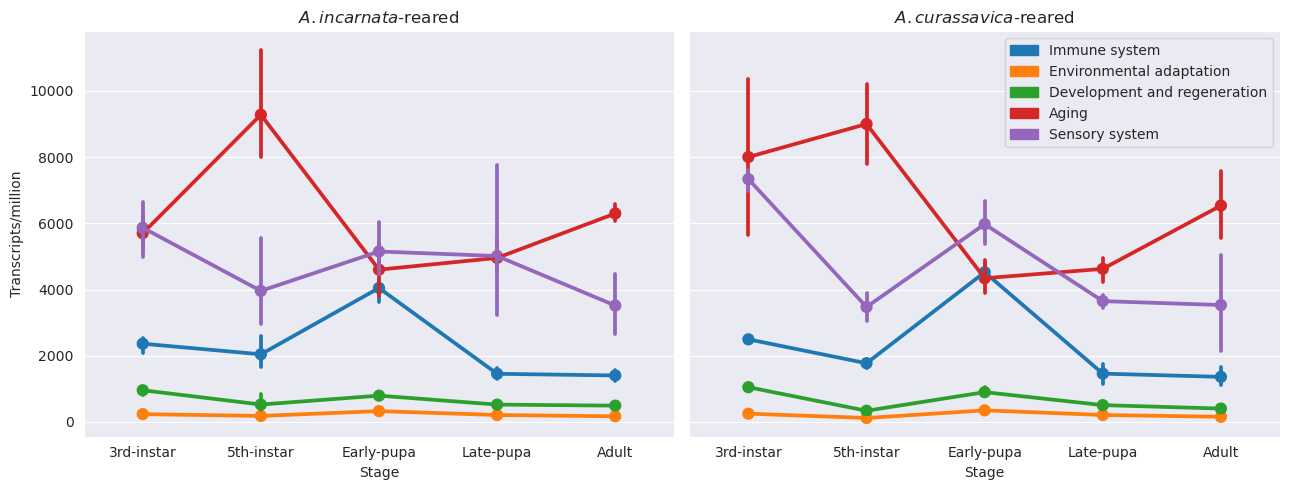

In [233]:
#separate cur and inc data

cur_organismal_df = organismal_df.loc[organismal_df['plant'] == 'A. curassavica']
inc_organismal_df = organismal_df.loc[organismal_df['plant'] == 'A. incarnata']

processes = list(organismal_df.columns)[0:-2]

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(13, 5), sharey=True)

#define colors
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive']
#plot incarnata
for i in range(len(processes)):
    process = processes[i]
    sns.pointplot(data=inc_organismal_df, x='developmental_stage', y=process, ax=ax1, color=colors[i])

ax1.set_title('$A. incarnata$-reared')
ax1.set_ylabel('Transcripts/million')
ax1.set_xlabel('Stage')

#plot curassavica
for i in range(len(processes)):
    process = processes[i]
    sns.pointplot(data=cur_organismal_df, x='developmental_stage', y=process, ax=ax2, color=colors[i])

ax2.set_title('$A. curassavica$-reared')
ax2.set_ylabel('')
ax2.set_xlabel('Stage')

legend_cols = []
for i in range(len(processes)):
    process = processes[i]
    color = colors[i]
    patch = mpatches.Patch(color=color, label=process)
    legend_cols.append(patch)

plt.legend(handles=legend_cols, bbox_to_anchor=(1,1,0,0))

plt.tight_layout()

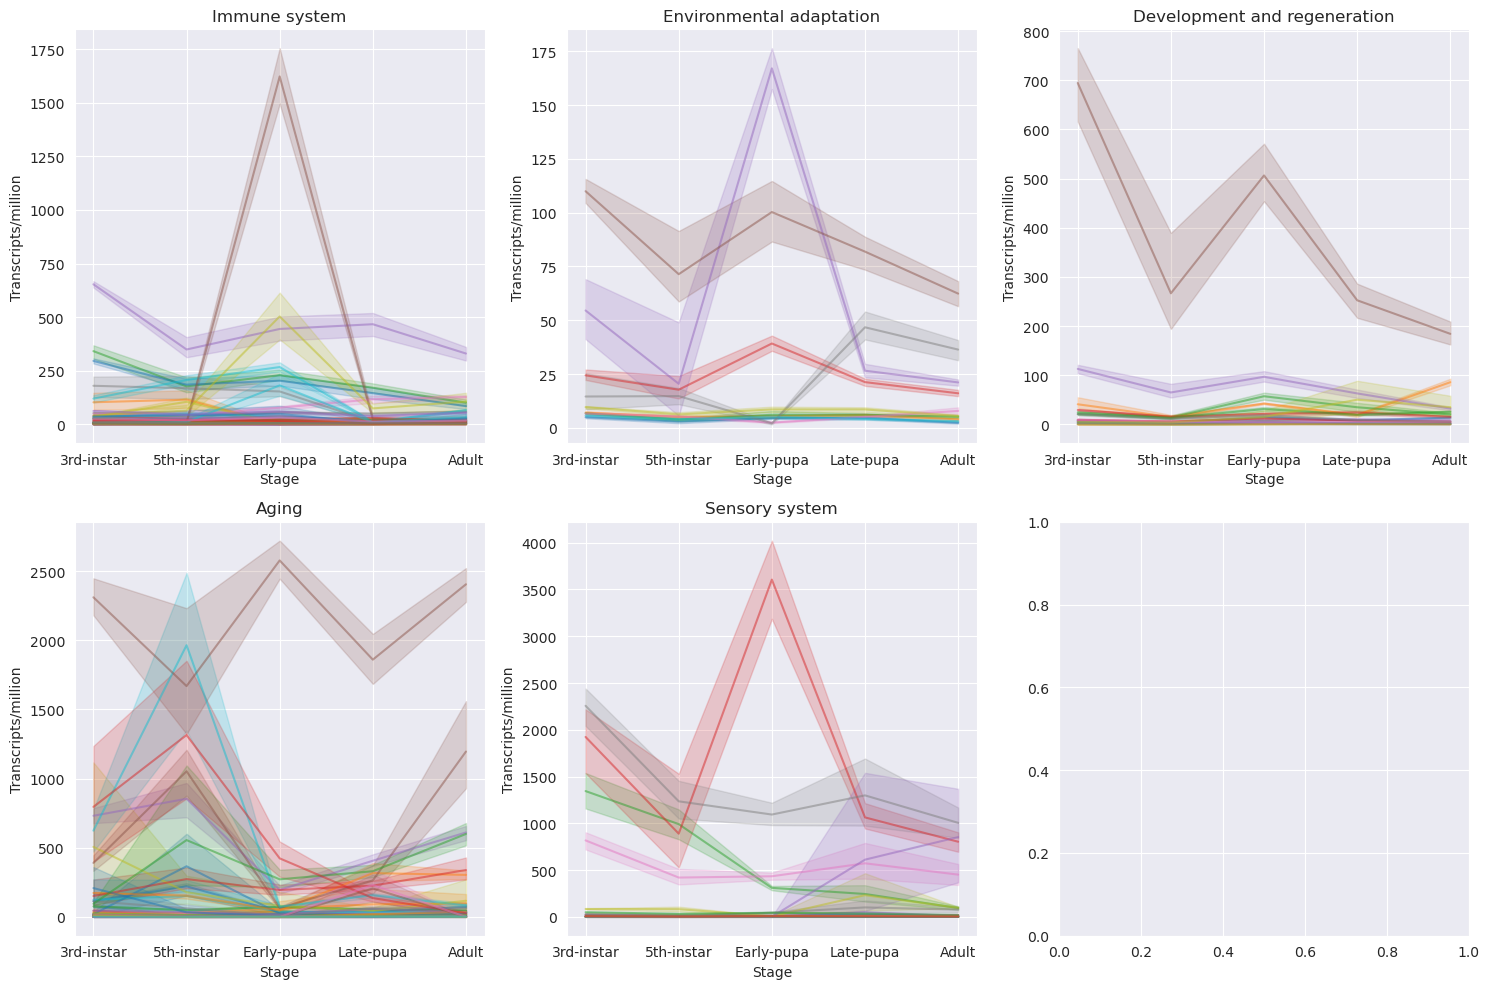

In [243]:
#and now to plot the actual expression of genetic processing genes
fig, [[ax1,ax2,ax3], [ax4,ax5,ax6]] = plt.subplots(2, 3, figsize=(15, 10))

for gene_id in organismal_genes:
    protein_id = gene_id.split('_')[2]
    gbid = protein_to_gene_dict[protein_id]
    
    #get function
    if gbid in dpl_kegg_dict:
        functions = dpl_kegg_dict[gbid]
        
        organismal_groups = []
        for function in functions:
            functional_heirarchy = function['functional_heirarcy']
            level1 = functional_heirarchy['functional_group_level1']
            if level1 == 'Organismal Systems':
                level2 = functional_heirarchy['functional_group_level2']
                if level2 not in organismal_groups:
                    organismal_groups.append(level2)
            
        organismal_class = organismal_groups[0]
        if organismal_class == 'Immune system':
            sns.lineplot(data = sorted_df, x='developmental_stage', y=gene_id, ax=ax1, alpha=0.5)
        elif organismal_class == 'Environmental adaptation':
            sns.lineplot(data = sorted_df, x='developmental_stage', y=gene_id, ax=ax2, alpha=0.5)
        elif organismal_class == 'Development and regeneration':
            sns.lineplot(data = sorted_df, x='developmental_stage', y=gene_id, ax=ax3, alpha=0.5)
        elif organismal_class == 'Aging':
            sns.lineplot(data = sorted_df, x='developmental_stage', y=gene_id, ax=ax4, alpha=0.5)
        elif organismal_class == 'Sensory system':
            sns.lineplot(data = sorted_df, x='developmental_stage', y=gene_id, ax=ax5, alpha=0.5)              


ax1.set_ylabel('Transcripts/million')
ax1.set_xlabel('Stage')
ax1.set_title('Immune system')

ax2.set_ylabel('Transcripts/million')
ax2.set_xlabel('Stage')
ax2.set_title('Environmental adaptation')

ax3.set_ylabel('Transcripts/million')
ax3.set_xlabel('Stage')
ax3.set_title('Development and regeneration')

ax4.set_ylabel('Transcripts/million')
ax4.set_xlabel('Stage')
ax4.set_title('Aging')

ax5.set_ylabel('Transcripts/million')
ax5.set_xlabel('Stage')
ax5.set_title('Sensory system')

plt.tight_layout()

<a id='cell_process'>

### Cellular Processes

In [19]:
#initialize dataframe
cellular_df = pd.DataFrame(index=uninfected_data.index)
cellular_df_multi = pd.DataFrame(index=uninfected_data.index)
cellular_genes = []
multi_cellular_genes = []

#list of groups to exclude
exclude = ['Human Diseases', 'Brite Hierarchies', 'Not Included in Pathway or Brite']

#iterate through gene ids
for gene_id in list(uninfected_data.columns):
    protein_id = gene_id.split('_')[2]
    gbid = protein_to_gene_dict[protein_id]
    
    #get function
    if gbid in dpl_kegg_dict:
        functions = dpl_kegg_dict[gbid]
        
        cellular_groups = []
        for function in functions:
            functional_heirarchy = function['functional_heirarcy']
            level1 = functional_heirarchy['functional_group_level1']
            if level1 == 'Cellular Processes':
                level2 = functional_heirarchy['functional_group_level2']
                if level2 not in organismal_groups:
                    cellular_groups.append(level2)
            
        #as with before, we'll exclude genes that hit to multiple categories. This should
        #still give us a relative idea of what's going on
        if len(cellular_groups) == 1:
            cellular_class = cellular_groups[0]
            
            #if function is not already in dataframe, add it with empty 0s
            if cellular_class not in list(cellular_df):
                cellular_df[cellular_class] = np.zeros(len(cellular_df.index), dtype=int)
                
            #add values to appropriate column
            cellular_df[cellular_class] = cellular_df[cellular_class] + uninfected_data[gene_id]
            cellular_genes.append(gene_id)
            
        if len(cellular_groups) > 0:
            for cellular_subclass in cellular_groups:
                
                if cellular_class not in list(cellular_df):
                    cellular_df[organismal_class] = np.zeros(len(cellular_df.index), dtype=int)
                    
                    #add values to appropriate column
                    cellular_df[cellular_class] = cellular_df[cellular_class] + uninfected_data[gene_id]
                    multi_cellular_genes.append(gene_id)

In [20]:
#now I need to add metadata
plant = []
developmental_stage = []

for sample in list(cellular_df.index):
    plant_type = sample[6]
    stage = sample[5]
    
    if plant_type == 'c':
        plant.append('A. curassavica')
    elif plant_type == 'i':
        plant.append('A. incarnata')
    
    if stage == '3':
        developmental_stage.append('3rd-instar')
    elif stage == '5':
        developmental_stage.append('5th-instar')
    elif stage == 'E':
        developmental_stage.append('Early-pupa')
    elif stage == 'L':
        developmental_stage.append('Late-pupa')
    elif stage == 'A':
        developmental_stage.append('Adult')

#add metadata to dataframe

cellular_df['plant'] = plant
cellular_df['developmental_stage'] = developmental_stage

#sort data by transition order
dev_order = ['3rd-instar', '5th-instar', 'Early-pupa', 'Late-pupa', 'Adult']
cellular_df['developmental_stage'] = pd.Categorical(cellular_df['developmental_stage'], categories = dev_order)
cellular_df = cellular_df.sort_values(by='developmental_stage')

cellular_df

Cell motility  Transport and catabolism  Cell growth and death  \
sample-id                                                                     
mtstp3iu81    11470.854822              33750.284328            1653.367721   
mtstp3cu2     10804.500151              34675.629966            1752.876550   
mtstp3iu85    13427.413217              25407.327798            1218.115537   
mtstp3cu5     11907.679592              35275.530632            1895.383546   
mtstp3cu4      9851.243832              34500.750049            1752.216050   
mtstp3cu3     11415.853470              32903.182507            1638.814350   
mtstp3cu8     10422.295849              34712.244101            1826.290410   
mtstp3iu83    10682.629420              34042.959272            1670.096132   
mtstp3iu82    13314.481266              31971.522934            1479.952570   
mtstp3iu84    11047.769999              32925.475336            1503.241070   
mtstp5iu101    9776.991169              25824.300440             885.143349   
mtstp5iu99     9243.869393              26316.662243             911.085553   
mtstp5iu97     6633.917898              27991.502836            1896.567200   
mtstp5cu20     6733.429608              28416.151475            1063.125311   
mtstp5cu19     9696.741921              25586.305835             888.911948   
mtstp5cu21     8048.178699              27815.102275             898.837004   
mtstp5iu98     7955.695913              26145.411883             930.934556   
mtstp5cu18     8225.455135              24903.188778             858.140344   
mtstp5cu17     8861.073918              26688.910259             947.870160   
mtstp5iu100    8139.381779              25980.618470             883.294513   
mtstpEcu35     3613.384825              16100.859815            1284.742330   
mtstpEiu115    2696.794109              15945.610791            1242.151786   
mtstpEiu116    4790.935433              16167.516476            1416.716290   
mtstpEiu117    4736.975771              18898.974786            1466.077580   
mtstpEcu38     3881.628419              21207.087425            1649.207100   
mtstpEcu33     3167.426393              18329.981951            1301.679680   
mtstpEiu114    2244.532209              13730.874479            1010.890770   
mtstpEcu34     2579.479327              15066.149530            1217.549378   
mtstpEcu36     3930.428089              18961.526231            1585.594490   
mtstpLiu130   19448.183377              16973.782728            1166.154481   
mtstpLiu129   17311.213878              17273.573587             955.556335   
mtstpLiu133   14484.338460              16039.461538            1018.771719   
mtstpLiu135   14258.115549              17385.569354            1199.828960   
mtstpLcu50    17744.709798              14188.711409             868.454416   
mtstpLcu56    16978.765363              16179.996362            1078.111669   
mtstpLcu49    17975.650383              18137.048549            1066.284868   
mtstpLcu53    11735.502432              11961.229485             711.529582   
mtstpLiu131   25002.302176              13630.062836             698.008232   
mtstpLcu52    17739.599958              17606.774913            1098.675994   
mtstpAiu147    9088.015473              15934.174660             818.448637   
mtstpAiu149   10203.938552              15239.746346             812.465516   
mtstpAiu145    8802.513160              14818.664009             811.013058   
mtstpAiu148   11847.388222              17472.868643            1046.959480   
mtstpAcu67     6663.267240              12415.375115             594.752702   
mtstpAcu68    10332.730719              18910.760465             873.643102   
mtstpAcu69    12433.702631              15576.406584             945.491702   
mtstpAiu146    6941.187446              16970.524726             793.921820   
mtstpAcu65     8976.003830              15742.159390             738.149903   
mtstpAcu66    11188.543619              13976.292419           

In [35]:
cellular_df.to_csv('data/function_tables/cellular_processes_nonredundant.csv')

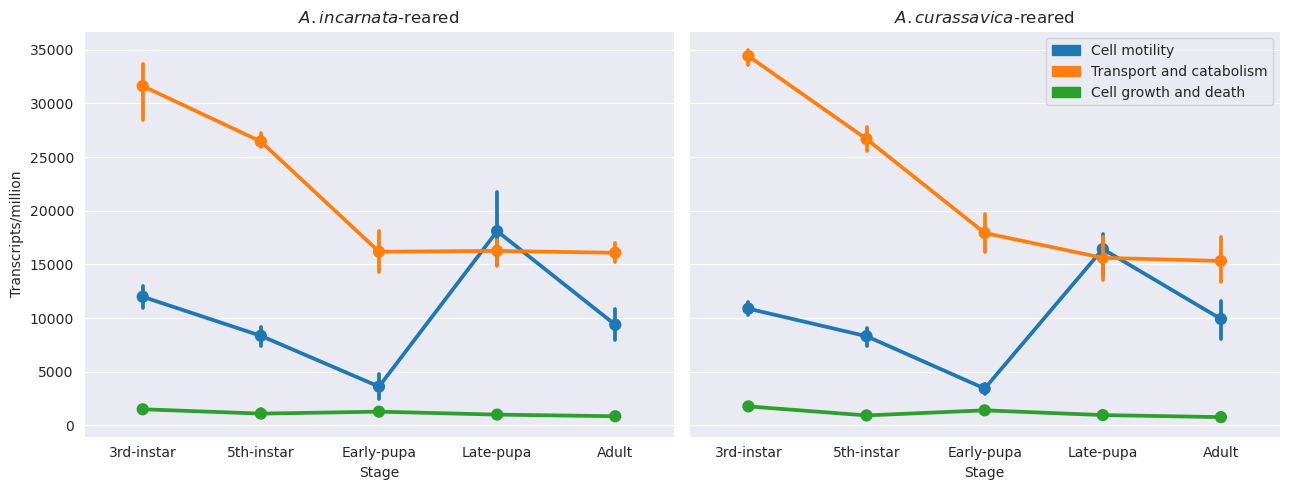

In [37]:
#separate cur and inc data

cur_cellular_df = cellular_df.loc[cellular_df['plant'] == 'A. curassavica']
inc_cellular_df = cellular_df.loc[cellular_df['plant'] == 'A. incarnata']

processes = list(cellular_df.columns)[0:-2]

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(13, 5), sharey=True)

#define colors
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive']
#plot incarnata
for i in range(len(processes)):
    process = processes[i]
    sns.pointplot(data=inc_cellular_df, x='developmental_stage', y=process, ax=ax1, color=colors[i])

ax1.set_title('$A. incarnata$-reared')
ax1.set_ylabel('Transcripts/million')
ax1.set_xlabel('Stage')

#plot curassavica
for i in range(len(processes)):
    process = processes[i]
    sns.pointplot(data=cur_cellular_df, x='developmental_stage', y=process, ax=ax2, color=colors[i])

ax2.set_title('$A. curassavica$-reared')
ax2.set_ylabel('')
ax2.set_xlabel('Stage')

legend_cols = []
for i in range(len(processes)):
    process = processes[i]
    color = colors[i]
    patch = mpatches.Patch(color=color, label=process)
    legend_cols.append(patch)

plt.legend(handles=legend_cols, bbox_to_anchor=(1,1,0,0))

plt.tight_layout()

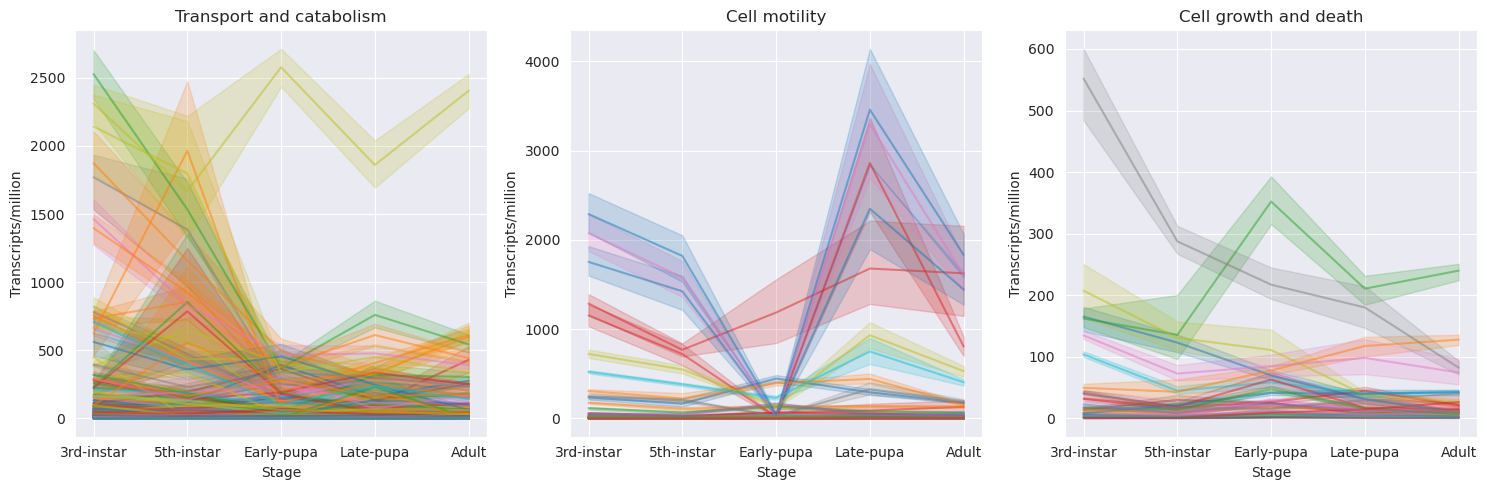

In [40]:
#and now to plot the actual expression of genetic processing genes
fig, [ax1,ax2,ax3] = plt.subplots(1, 3, figsize=(15, 5))

for gene_id in cellular_genes:
    protein_id = gene_id.split('_')[2]
    gbid = protein_to_gene_dict[protein_id]
    
    #get function
    if gbid in dpl_kegg_dict:
        functions = dpl_kegg_dict[gbid]
        
        cellular_groups = []
        for function in functions:
            functional_heirarchy = function['functional_heirarcy']
            level1 = functional_heirarchy['functional_group_level1']
            if level1 == 'Cellular Processes':
                level2 = functional_heirarchy['functional_group_level2']
                if level2 not in cellular_groups:
                    cellular_groups.append(level2)
            
        cellular_class = cellular_groups[0]
        if cellular_class == 'Transport and catabolism':
            sns.lineplot(data = sorted_df, x='developmental_stage', y=gene_id, ax=ax1, alpha=0.5)
        elif cellular_class == 'Cell motility':
            sns.lineplot(data = sorted_df, x='developmental_stage', y=gene_id, ax=ax2, alpha=0.5)
        elif cellular_class == 'Cell growth and death':
            sns.lineplot(data = sorted_df, x='developmental_stage', y=gene_id, ax=ax3, alpha=0.5)        


ax1.set_ylabel('Transcripts/million')
ax1.set_xlabel('Stage')
ax1.set_title('Transport and catabolism')

ax2.set_ylabel('Transcripts/million')
ax2.set_xlabel('Stage')
ax2.set_title('Cell motility')

ax3.set_ylabel('Transcripts/million')
ax3.set_xlabel('Stage')
ax3.set_title('Cell growth and death')


plt.tight_layout()

<a id='de_coupling'>

### Expression correlations across development

It would be interesting to look for evidence of coupling/decoupling across development. I'll start by looking at how the expression of various genes correlate within stages adn across stages.

In [44]:
#using the cor() function in R to generate correlations
!./scripts/functional_correlations.R

In [3]:
#and now to load said data
functional_correlations = pd.read_csv('data/function_tables/functional_correlations.csv', index_col=0)
functional_correlations.index = functional_correlations.index.str.replace('.', ' ')
functional_correlations.columns = functional_correlations.columns.str.replace('.', ' ')
functional_correlations

/tmp/ipykernel_138304/3813766682.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  functional_correlations.index = functional_correlations.index.str.replace('.', ' ')
/tmp/ipykernel_138304/3813766682.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  functional_correlations.columns = functional_correlations.columns.str.replace('.', ' ')


Lipid metabolism  \
Lipid metabolism                                  1.000000   
Carbohydrate metabolism                           0.811972   
Glycan biosynthesis and metabolism                0.321620   
Amino acid metabolism                             0.739544   
Metabolism of cofactors and vitamins              0.734805   
Nucleotide metabolism                             0.362906   
Energy metabolism                                 0.668313   
Metabolism of terpenoids and polyketides          0.504811   
Metabolism of other amino acids                   0.494864   
Immune system                                    -0.515936   
Environmental adaptation                         -0.493814   
Development and regeneration                     -0.036012   
Aging                                             0.558813   
Sensory system                                   -0.006397   
Folding  sorting and degradation                  0.487044   
Translation                                       0.308754   
Replication and repair                           -0.118006   
Chromosome                                       -0.161905   
Transcription                                     0.012207   
Information processing in viruses                -0.175293   
Cell motility                                     0.228830   
Transport and catabolism                          0.572120   
Cell growth and death                             0.029797   

                                          Carbohydrate metabolism  \
Lipid metabolism                                         0.811972   
Carbohydrate metabolism                                  1.000000   
Glycan biosynthesis and metabolism                      -0.028772   
Amino acid metabolism                                    0.746881   
Metabolism of cofactors and vitamins                     0.576116   
Nucleotide metabolism                                    0.473821   
Energy metabolism                                        0.750044   
Metabolism of terpenoids and polyketides                 0.156417   
Metabolism of other amino acids                          0.154475   
Immune system                                           -0.703878   
Environmental adaptation                                -0.780132   
Development and regeneration                            -0.475726   
Aging                                                    0.537546   
Sensory system                                          -0.309158   
Folding  sorting and degradation                         0.174156   
Translation                                              0.012052   
Replication and repair                                  -0.517347   
Chromosome                                              -0.530782   
Transcription                                           -0.409109   
Information processing in viruses                       -0.550702   
Cell motility                                            0.355268   
Transport and catabolism                                 0.281013   
Cell growth and death                                   -0.391449   

                                          Glycan biosynthesis and metabolism  \
Lipid metabolism                                                    0.321620   
Carbohydrate metabolism                                            -0.028772   
Glycan biosynthesis and metabolism                                  1.000000   
Amino acid metabolism                                               0.508322   
Metabolism of cofactors and vitamins                                0.650171   
Nucleotide metabolism                                               0.318014   
Energy metabolism                                                  -0.168434   
Metabolism of terpenoids and polyketides                            0.767880   
Metabolism of other amino acids                                     0.856981   
Immune system                                                       0.355275   
Environmental ad

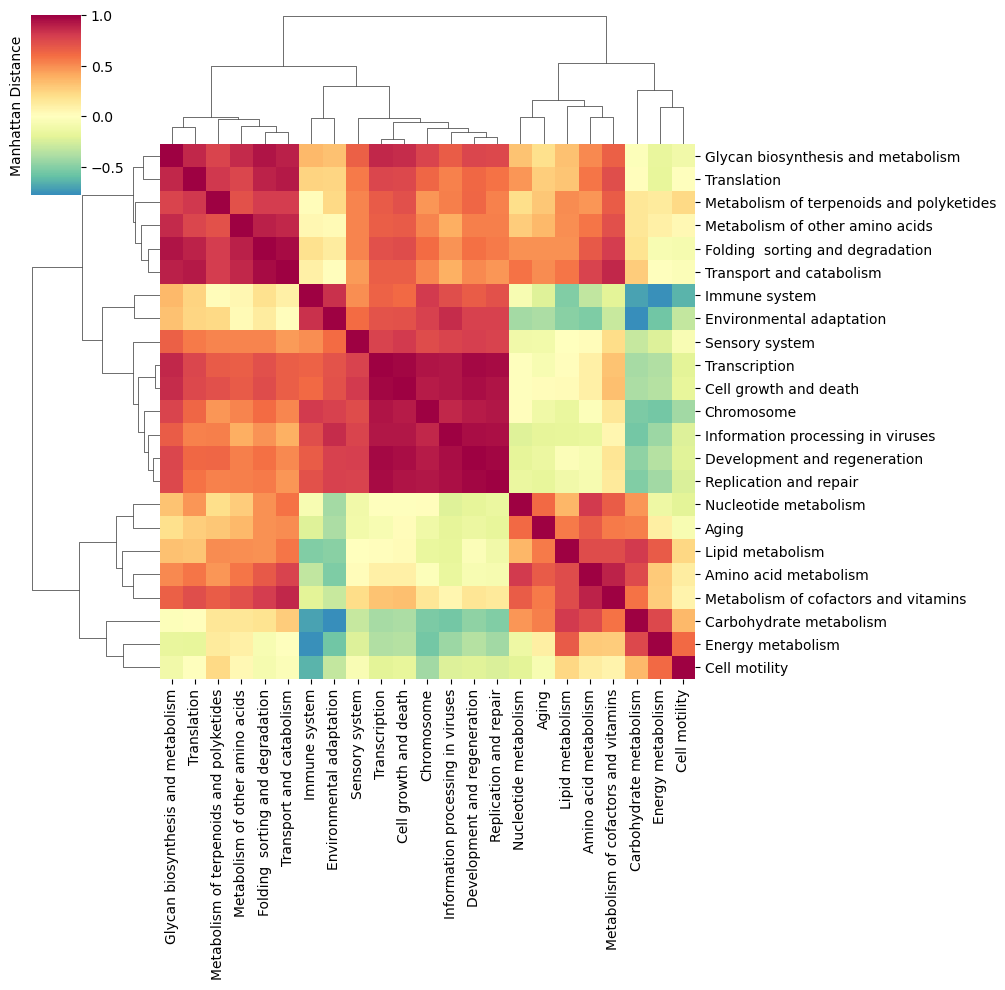

In [8]:
#and now for a heatmap + heirachical clustering
cluster = sns.clustermap(functional_correlations, figsize=(10, 10), cmap="Spectral_r", center=0, cbar_kws={'label': "Pearson's $r$"})

cbar = cluster.ax_heatmap.collections[0].colorbar
cbar.set_label("Manhattan Distance", labelpad=5)
cbar.ax.yaxis.set_label_position('left')

plt.savefig('../figures/primary/functional_correlations.pdf')

In [115]:
#it looks like energy metabolism and immunity are pretty heavily negatively correlated
#I'll try to plot these directly

samples = list(organismal_df.index)
immunity_metabolism_data = pd.DataFrame(index=samples)

plant = list(organismal_df["plant"])
stage = list(organismal_df["developmental_stage"])
immune_expression = list(organismal_df["Immune system"])
energy_metabolism = list(metabolism_df["Energy metabolism"])
carbohydrate_metabolism = list(metabolism_df["Carbohydrate metabolism"])
cell_motility = list(cellular_df["Cell motility"])

immunity_metabolism_data['Immunity'] = immune_expression
immunity_metabolism_data['Energy_metabolism'] = energy_metabolism
immunity_metabolism_data['Carbohydrate_metabolism'] = carbohydrate_metabolism
immunity_metabolism_data['Cell_motility'] = cell_motility

immunity_metabolism_data['stage']= stage
immunity_metabolism_data['plant']= plant

In [114]:
#a quick stat
immune_vs_energy_stats = scipy.stats.pearsonr(immune_expression, energy_metabolism)
immune_vs_carb_stats = scipy.stats.pearsonr(immune_expression, carbohydrate_metabolism)
immune_vs_cell_stats = scipy.stats.pearsonr(immune_expression, cell_motility)

print(immune_vs_energy_stats)
print(immune_vs_carb_stats)
print(immune_vs_cell_stats)

PearsonRResult(statistic=-0.7641810950984583, pvalue=1.6735478945959803e-10)
PearsonRResult(statistic=-0.7038779137711202, pvalue=1.682036223408913e-08)
PearsonRResult(statistic=-0.6468514885783971, pvalue=5.123613830103483e-07)


In [116]:
immunity_metabolism_data['Immunity'] = immunity_metabolism_data['Immunity'] / 10000
immunity_metabolism_data['Energy_metabolism'] = immunity_metabolism_data['Energy_metabolism'] / 10000
immunity_metabolism_data['Carbohydrate_metabolism'] = immunity_metabolism_data['Carbohydrate_metabolism'] / 10000
immunity_metabolism_data['Cell_motility'] = immunity_metabolism_data['Cell_motility'] / 10000

Now I need to fit some models. Linear models don't seem to be doing the trick

In [250]:
# the exponential decay function
def exponential_decay(x, a, b, c):
    return a * np.exp(-b * x) + c

#a function to generate predictions and CI
def fit_exponential_decay(data, x_col, y_col):
    x = np.array(list(data[x_col]))
    y = np.array(list(data[y_col]))
    
    params, covariance = curve_fit(exponential_decay, x, y)
    a, b, c = params
    
    # Extract the fitted parameters and their standard errors
    sigma_a, sigma_b, sigma_c = np.sqrt(np.diag(covariance))
    
    # Generate the fitted curve using the parameters
    y_fit = exponential_decay(x, a, b, c)
    
    # Calculate the residuals
    residuals = y - y_fit
    
    x_obs, y_pred = zip(*sorted(zip(x, y_fit)))
    ci = 0.1 * np.std(y_pred) / np.mean(y_pred)
    
    output = {'y_pred' : y_pred, 'residuals' : residuals, 'x_values' : x_obs, 'ci' : ci}
    
    print("\nExponential Decay Model Fit Summary:\n")
    print(f"Fitted Parameters:\n"
      f"a = {a} (SE = {sigma_a})\n"
      f"b = {b} (SE = {sigma_b})\n"
      f"c = {c} (SE = {sigma_c})")

    sum_squared_residuals = np.sum(residuals**2)
    print(f"Sum of squared residuals: {sum_squared_residuals}")
    
    return output

In [383]:
# the exponential decay function
def exponential_growth(x, a, b, c):
    return a * np.exp(b * x) + c

#a function to generate predictions and CI
def fit_exponential_growth(data, x_col, y_col):
    x = np.array(list(data[x_col]))
    y = np.array(list(data[y_col]))
    
    params, covariance = curve_fit(exponential_growth, x, y, maxfev=5000)
    a, b, c = params
    
    # Extract the fitted parameters and their standard errors
    sigma_a, sigma_b, sigma_c = np.sqrt(np.diag(covariance))
    
    # Generate the fitted curve using the parameters
    y_fit = exponential_growth(x, a, b, c)
    
    # Calculate the residuals
    residuals = y - y_fit
    
    x_obs, y_pred = zip(*sorted(zip(x, y_fit)))
    ci = 0.1 * np.std(y_pred) / np.mean(y_pred)
    
    output = {'y_pred' : y_pred, 'residuals' : residuals, 'x_values' : x_obs, 'ci' : ci}
    
    print("\nExponential Growth Model Fit Summary:\n")
    print(f"Fitted Parameters:\n"
      f"a = {a} (SE = {sigma_a})\n"
      f"b = {b} (SE = {sigma_b})\n"
      f"c = {c} (SE = {sigma_c})")

    sum_squared_residuals = np.sum(residuals**2)
    print(f"Sum of squared residuals: {sum_squared_residuals}")
    
    return output

In [341]:
# the exponential decay function
def linear_model(x, m, b):
    return m*x+b

#a function to generate predictions and CI
def fit_linear_model(data, x_col, y_col):
    x = np.array(list(data[x_col]))
    y = np.array(list(data[y_col]))
    
    params, covariance = curve_fit(linear_model, x, y)
    m, b = params
    
    # Extract the fitted parameters and their standard errors
    sigma_m, sigma_b = np.sqrt(np.diag(covariance))
    
    # Generate the fitted curve using the parameters
    y_fit = linear_model(x,m,b)
    
    # Calculate the residuals
    residuals = y - y_fit
    
    x_obs, y_pred = zip(*sorted(zip(x, y_fit)))
    ci = 0.1 * np.std(y_pred) / np.mean(y_pred)
    
    output = {'y_pred' : y_pred, 'residuals' : residuals, 'x_values' : x_obs, 'ci' : ci}
    
    print("\nLinear Model Fit Summary:\n")
    print(f"Fitted Parameters:\n"
      f"m = {m} (SE = {sigma_m})\n"
      f"b = {b} (SE = {sigma_b})\n")

    sum_squared_residuals = np.sum(residuals**2)
    print(f"Sum of squared residuals: {sum_squared_residuals}")
    
    return output

In [253]:
#immunty vs energy metabolism model
immunity_vs_energy_exp_decay_model = fit_exponential_decay(data = immunity_metabolism_data, 
                                                x_col = 'Energy_metabolism', 
                                                y_col = 'Immunity')

immunity_vs_energy_linear_model = fit_linear_model(data = immunity_metabolism_data, 
                                                x_col = 'Energy_metabolism', 
                                                y_col = 'Immunity')


Exponential Decay Model Fit Summary:

Fitted Parameters:
a = 0.4631863209300618 (SE = 0.05364863040588776)
b = 0.5300443540812815 (SE = 0.13886141312097453)
c = 0.14799348406799223 (SE = 0.01963557208710015)
Sum of squared residuals: 0.12854736902333547

Linear Model Fit Summary:

Fitted Parameters:
m = -0.03400753750918304 (SE = 0.004186883344000011)
b = 0.38839164793450925 (SE = 0.022515421652200912)

Sum of squared residuals: 0.24334703017206152


In [254]:
#immunty vs carbohydrate metabolism model
immunity_vs_carb_exp_decay_model = fit_exponential_decay(data = immunity_metabolism_data, 
                                                x_col = 'Carbohydrate_metabolism', 
                                                y_col = 'Immunity')

immunity_vs_carb_linear_model = fit_linear_model(data = immunity_metabolism_data, 
                                                x_col = 'Carbohydrate_metabolism', 
                                                y_col = 'Immunity')


Exponential Decay Model Fit Summary:

Fitted Parameters:
a = 1.3869548624751986 (SE = 0.6888323475120687)
b = 4.326950902336774 (SE = 1.313681070182644)
c = 0.16622408202341354 (SE = 0.016183969750088692)
Sum of squared residuals: 0.19056602933384229

Linear Model Fit Summary:

Fitted Parameters:
m = -0.20374277132695792 (SE = 0.029990974378510404)
b = 0.4316220677204893 (SE = 0.032358845028679)

Sum of squared residuals: 0.2951301252843784


In [261]:
#immunty vs carbohydrate metabolism model
immunity_vs_cell_exp_decay_model = fit_exponential_decay(data = immunity_metabolism_data, 
                                                x_col = 'Cell_motility', 
                                                y_col = 'Immunity')

immunity_vs_cell_linear_model = fit_linear_model(data = immunity_metabolism_data, 
                                                x_col = 'Cell_motility', 
                                                y_col = 'Immunity')


Exponential Decay Model Fit Summary:

Fitted Parameters:
a = 0.611263068438924 (SE = 0.1233938913397701)
b = 2.6235801110365524 (SE = 0.7319314115264899)
c = 0.14586261383280688 (SE = 0.024310392041373197)
Sum of squared residuals: 0.20605056624005363

Linear Model Fit Summary:

Fitted Parameters:
m = -0.14709276400068125 (SE = 0.02529552564545338)
b = 0.37531554220587116 (SE = 0.028457945680903433)

Sum of squared residuals: 0.34018572448174256


Text(0, 0.5, '')

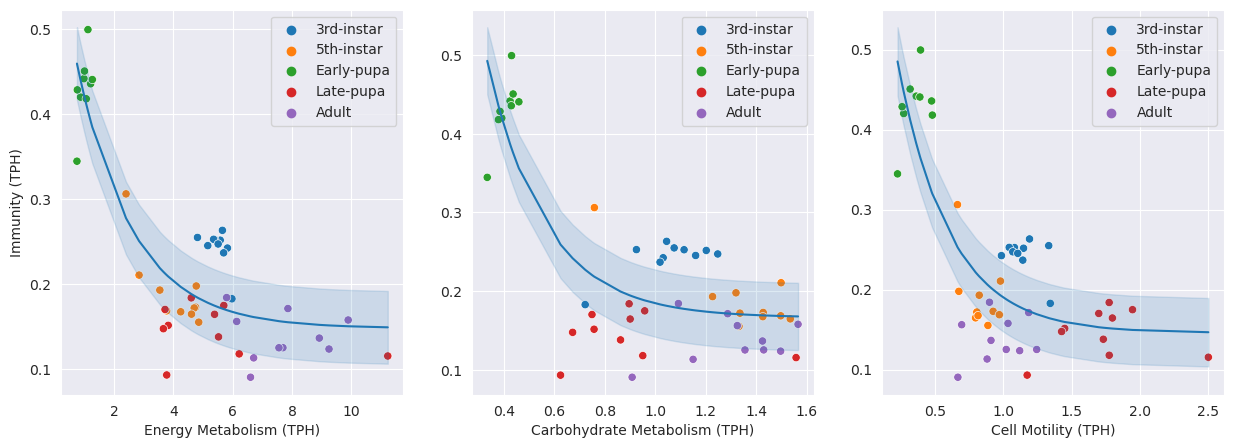

In [306]:
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(15, 5))

#plot immunity vs energy metabolism
sns.scatterplot(data=immunity_metabolism_data, y="Immunity", x="Energy_metabolism", hue="stage", ax=ax1)
sns.lineplot(x=immunity_vs_energy_exp_decay_model['x_values'], 
             y=immunity_vs_energy_exp_decay_model['y_pred'], ax=ax1)
ax1.fill_between(immunity_vs_energy_exp_decay_model['x_values'], 
                 (immunity_vs_energy_exp_decay_model['y_pred']-immunity_vs_energy_exp_decay_model['ci']), 
                 (immunity_vs_energy_exp_decay_model['y_pred']+immunity_vs_energy_exp_decay_model['ci']), 
                 color='tab:blue', alpha=0.15)
ax1.set_xlabel('Energy Metabolism (TPH)')
ax1.set_ylabel('Immunity (TPH)')

#plot immunity vs carbohydrate metabolism
sns.scatterplot(data=immunity_metabolism_data, y="Immunity", x="Carbohydrate_metabolism", hue="stage", ax=ax2)
sns.lineplot(x=immunity_vs_carb_exp_decay_model['x_values'], 
             y=immunity_vs_carb_exp_decay_model['y_pred'], ax=ax2)
ax2.fill_between(immunity_vs_carb_exp_decay_model['x_values'], 
                 (immunity_vs_carb_exp_decay_model['y_pred']-immunity_vs_energy_exp_decay_model['ci']), 
                 (immunity_vs_carb_exp_decay_model['y_pred']+immunity_vs_energy_exp_decay_model['ci']), 
                 color='tab:blue', alpha=0.15)
ax2.set_xlabel('Carbohydrate Metabolism (TPH)')
ax2.set_ylabel('')

#plot immunity vs cell motility
sns.scatterplot(data=immunity_metabolism_data, y="Immunity", x="Cell_motility", hue="stage", ax=ax3)
sns.lineplot(x=immunity_vs_cell_exp_decay_model['x_values'], 
             y=immunity_vs_cell_exp_decay_model['y_pred'], ax=ax3)
ax3.fill_between(immunity_vs_cell_exp_decay_model['x_values'], 
                 (immunity_vs_cell_exp_decay_model['y_pred']-immunity_vs_energy_exp_decay_model['ci']), 
                 (immunity_vs_cell_exp_decay_model['y_pred']+immunity_vs_energy_exp_decay_model['ci']), 
                 color='tab:blue', alpha=0.15)
ax3.set_xlabel('Cell Motility (TPH)')
ax3.set_ylabel('')

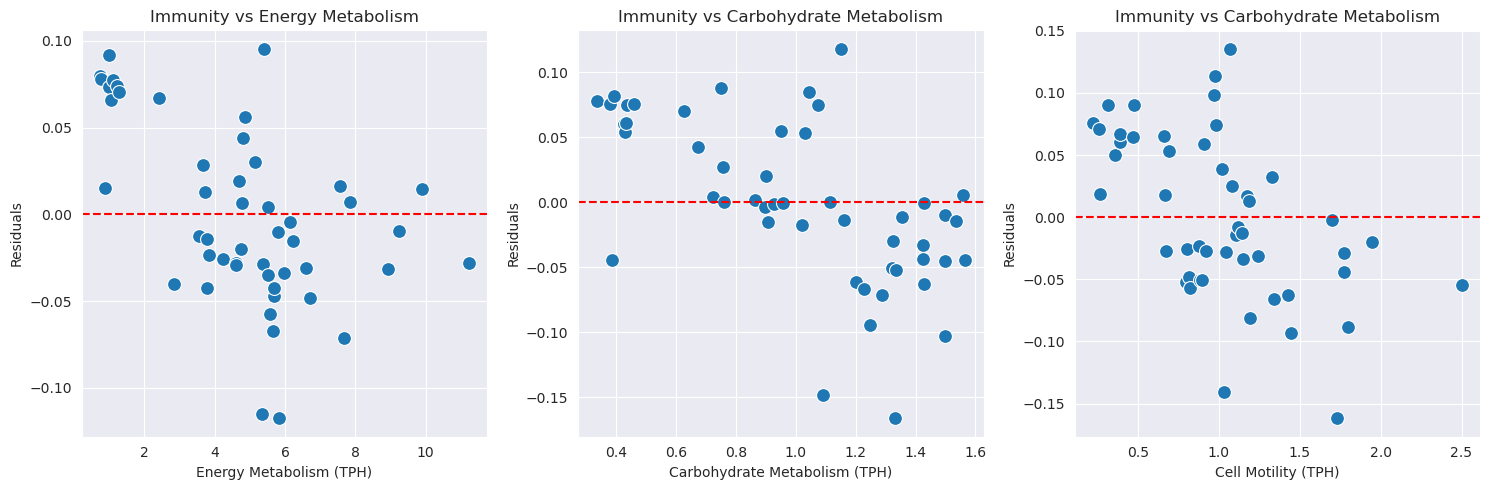

In [263]:
#and we'll plot the residuals
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(15, 5))

sns.scatterplot(y=immunity_vs_energy_exp_decay_model['residuals'], 
                x=immunity_vs_energy_exp_decay_model['x_values'], ax=ax1, s=100)
ax1.axhline(0, color='red', linestyle='--')
ax1.set_title('Immunity vs Energy Metabolism')
ax1.set_xlabel('Energy Metabolism (TPH)')
ax1.set_ylabel('Residuals')

sns.scatterplot(y=immunity_vs_carb_exp_decay_model['residuals'], 
                x=immunity_vs_carb_exp_decay_model['x_values'], ax=ax2, s=100)
ax2.axhline(0, color='red', linestyle='--')
ax2.set_title('Immunity vs Carbohydrate Metabolism')
ax2.set_xlabel('Carbohydrate Metabolism (TPH)')
ax2.set_ylabel('Residuals')

sns.scatterplot(y=immunity_vs_cell_exp_decay_model['residuals'], 
                x=immunity_vs_cell_exp_decay_model['x_values'], ax=ax3, s=100)
ax3.axhline(0, color='red', linestyle='--')
ax3.set_title('Immunity vs Carbohydrate Metabolism')
ax3.set_xlabel('Cell Motility (TPH)')
ax3.set_ylabel('Residuals')

plt.tight_layout()

And now to look at environmental adaptation (which is just Circadian rhythm), which seems to show similar correlations that immunity showed.

In [290]:
samples = list(organismal_df.index)
circadian_data = pd.DataFrame(index=samples)

plant = list(organismal_df["plant"])
stage = list(organismal_df["developmental_stage"])

circadian_expression = list(organismal_df["Environmental adaptation"])
energy_metabolism = list(metabolism_df["Energy metabolism"])
carbohydrate_metabolism = list(metabolism_df["Carbohydrate metabolism"])
cell_motility = list(cellular_df["Cell motility"])

circadian_data['Circadian'] = circadian_expression
circadian_data['Energy_metabolism'] = energy_metabolism
circadian_data['Carbohydrate_metabolism'] = carbohydrate_metabolism
circadian_data['Cell_motility'] = cell_motility

circadian_data['stage']= stage
circadian_data['plant']= plant

Text(0.5, 0, 'Cell Motility (TPM)')

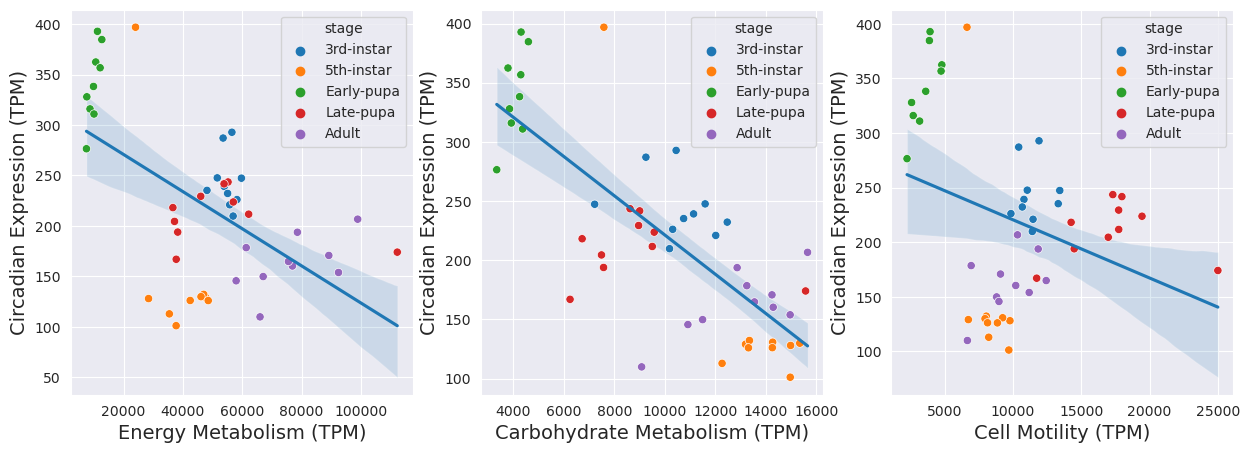

In [296]:
#a quick linear plot
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(15, 5))

sns.set_style('darkgrid')

sns.regplot(data=circadian_data, y="Circadian", x="Energy_metabolism", scatter=False, ax=ax1)
sns.scatterplot(data=circadian_data, y="Circadian", x="Energy_metabolism", hue="stage", ax=ax1)
ax1.set_ylabel('Circadian Expression (TPM)', size=14)
ax1.set_xlabel('Energy Metabolism (TPM)', size=14)

sns.regplot(data=circadian_data, y="Circadian", x="Carbohydrate_metabolism", scatter=False, ax=ax2)
sns.scatterplot(data=circadian_data, y="Circadian", x="Carbohydrate_metabolism", hue="stage", ax=ax2)
ax2.set_ylabel('Circadian Expression (TPM)', size=14)
ax2.set_xlabel('Carbohydrate Metabolism (TPM)', size=14)

sns.regplot(data=circadian_data, y="Circadian", x="Cell_motility", scatter=False, ax=ax3)
sns.scatterplot(data=circadian_data, y="Circadian", x="Cell_motility", hue="stage", ax=ax3)
ax3.set_ylabel('Circadian Expression (TPM)', size=14)
ax3.set_xlabel('Cell Motility (TPM)', size=14)

So the linear model doesn't filt well (just like immunity). Time to look at the exponential decay model

In [298]:
#divide everyting by 10K so the computer can exponentiate it
circadian_data['Circadian'] = circadian_data['Circadian'] / 10000
circadian_data['Energy_metabolism'] = circadian_data['Energy_metabolism'] / 10000
circadian_data['Carbohydrate_metabolism'] = circadian_data['Carbohydrate_metabolism'] / 10000
circadian_data['Cell_motility'] = circadian_data['Cell_motility'] / 10000

In [299]:
circadian_vs_energy_exp_decay_model = fit_exponential_decay(data = circadian_data, 
                                                x_col = 'Energy_metabolism', 
                                                y_col = 'Circadian')

circadian_vs_energy_linear_model = fit_linear_model(data = circadian_data, 
                                                x_col = 'Energy_metabolism', 
                                                y_col = 'Circadian')


Exponential Decay Model Fit Summary:

Fitted Parameters:
a = 0.028835263345598616 (SE = 0.008304412998139221)
b = 0.6355686320212466 (SE = 0.33377155187813085)
c = 0.018060240170259183 (SE = 0.001825478988648795)
Sum of squared residuals: 0.0016164925695750774

Linear Model Fit Summary:

Fitted Parameters:
m = -0.0018389733085199243 (SE = 0.00039353306740087313)
b = 0.03075966115945565 (SE = 0.0021162669830051234)

Sum of squared residuals: 0.002149843252334714


In [300]:
circadian_vs_carb_exp_decay_model = fit_exponential_decay(data = circadian_data, 
                                                x_col = 'Carbohydrate_metabolism', 
                                                y_col = 'Circadian')

circadian_vs_carb_linear_model = fit_linear_model(data = circadian_data, 
                                                x_col = 'Carbohydrate_metabolism', 
                                                y_col = 'Circadian')


Exponential Decay Model Fit Summary:

Fitted Parameters:
a = 0.04339339550242463 (SE = 0.013869414572172584)
b = 0.7828878563105344 (SE = 0.7186010228962625)
c = 0.0013954702446262344 (SE = 0.01952824295948818)
Sum of squared residuals: 0.0012000650854795244

Linear Model Fit Summary:

Fitted Parameters:
m = -0.016567833813342498 (SE = 0.0019380069970601028)
b = 0.038707515079449625 (SE = 0.002091018022450407)

Sum of squared residuals: 0.001232375503455956


In [301]:
circadian_vs_cell_exp_decay_model = fit_exponential_decay(data = circadian_data, 
                                                x_col = 'Cell_motility', 
                                                y_col = 'Circadian')

circadian_vs_cell_linear_model = fit_linear_model(data = circadian_data, 
                                                x_col = 'Cell_motility', 
                                                y_col = 'Circadian')


Exponential Decay Model Fit Summary:

Fitted Parameters:
a = 0.04259833597894232 (SE = 0.024362807778882)
b = 3.8014954248023134 (SE = 2.029154506504738)
c = 0.018969368726515872 (SE = 0.0017417446583015098)
Sum of squared residuals: 0.0021287299985663596

Linear Model Fit Summary:

Fitted Parameters:
m = -0.005330290124164905 (SE = 0.002306063881311069)
b = 0.027383462180645676 (SE = 0.0025943655650132497)

Sum of squared residuals: 0.0028272963516357153


Overall, the exponential decay models don't fit substantially better than the linear models (but there is marginal imporvement)

Text(0, 0.5, '')

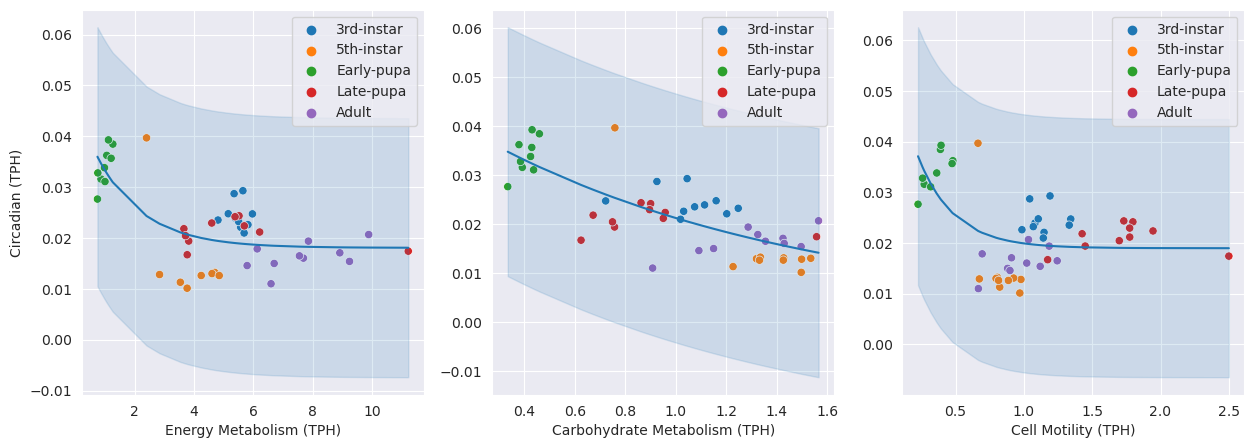

In [305]:
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(15, 5))

#plot immunity vs energy metabolism
sns.scatterplot(data=circadian_data, y="Circadian", x="Energy_metabolism", hue="stage", ax=ax1)
sns.lineplot(x=circadian_vs_energy_exp_decay_model['x_values'], 
             y=circadian_vs_energy_exp_decay_model['y_pred'], ax=ax1)
ax1.fill_between(immunity_vs_energy_exp_decay_model['x_values'], 
                 (circadian_vs_energy_exp_decay_model['y_pred']-circadian_vs_energy_exp_decay_model['ci']), 
                 (circadian_vs_energy_exp_decay_model['y_pred']+circadian_vs_energy_exp_decay_model['ci']), 
                 color='tab:blue', alpha=0.15)
ax1.set_xlabel('Energy Metabolism (TPH)')
ax1.set_ylabel('Circadian (TPH)')

#plot immunity vs carbohydrate metabolism
sns.scatterplot(data=circadian_data, y="Circadian", x="Carbohydrate_metabolism", hue="stage", ax=ax2)
sns.lineplot(x=circadian_vs_carb_exp_decay_model['x_values'], 
             y=circadian_vs_carb_exp_decay_model['y_pred'], ax=ax2)
ax2.fill_between(circadian_vs_carb_exp_decay_model['x_values'], 
                 (circadian_vs_carb_exp_decay_model['y_pred']-circadian_vs_energy_exp_decay_model['ci']), 
                 (circadian_vs_carb_exp_decay_model['y_pred']+circadian_vs_energy_exp_decay_model['ci']), 
                 color='tab:blue', alpha=0.15)
ax2.set_xlabel('Carbohydrate Metabolism (TPH)')
ax2.set_ylabel('')

#plot immunity vs cell motility
sns.scatterplot(data=circadian_data, y="Circadian", x="Cell_motility", hue="stage", ax=ax3)
sns.lineplot(x=circadian_vs_cell_exp_decay_model['x_values'], 
             y=circadian_vs_cell_exp_decay_model['y_pred'], ax=ax3)
ax3.fill_between(circadian_vs_cell_exp_decay_model['x_values'], 
                 (circadian_vs_cell_exp_decay_model['y_pred']-circadian_vs_energy_exp_decay_model['ci']), 
                 (circadian_vs_cell_exp_decay_model['y_pred']+circadian_vs_energy_exp_decay_model['ci']), 
                 color='tab:blue', alpha=0.15)
ax3.set_xlabel('Cell Motility (TPH)')
ax3.set_ylabel('')

Well that doesn't really work well. I don't understand why my CIs are so huge. Anyway, it also looks like Circidian genes and immunity are correlated. So we'll see what that looks like. 

In [367]:
samples = list(organismal_df.index)
circadian_immunity_data = pd.DataFrame(index=samples)

plant = list(organismal_df["plant"])
stage = list(organismal_df["developmental_stage"])

circadian_expression = list(organismal_df["Environmental adaptation"])
immune_expression = list(organismal_df["Immune system"])

circadian_immunity_data['Circadian'] = circadian_expression
circadian_immunity_data['Immunity'] = immune_expression

circadian_immunity_data['stage']= stage
circadian_immunity_data['plant']= plant

Text(0.5, 0, 'Circadian (TPM)')

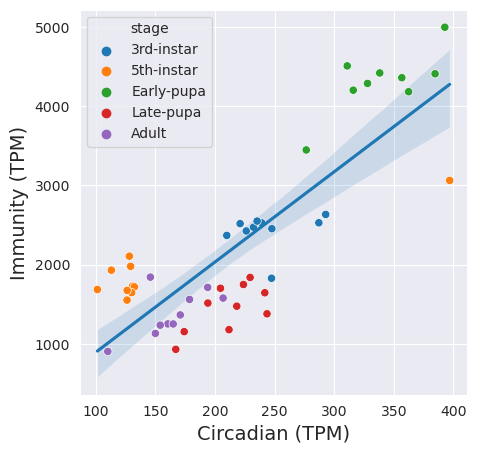

In [359]:
fig, ax1 = plt.subplots(1, 1, figsize=(5, 5))
sns.set_style('darkgrid')

sns.regplot(data=circadian_immunity_data, y="Immunity", x="Circadian", scatter=False, ax=ax1)
sns.scatterplot(data=circadian_immunity_data, y="Immunity", x="Circadian", hue="stage", ax=ax1)
ax1.set_ylabel('Immunity (TPM)', size=14)
ax1.set_xlabel('Circadian (TPM)', size=14)

In [368]:
#divide everyting by 10K so the computer can exponentiate it
circadian_immunity_data['Circadian'] = circadian_immunity_data['Circadian'] / 10000
circadian_immunity_data['Immunity'] = circadian_immunity_data['Immunity'] / 10000

In [384]:
#I think exponential growth would fit better
#immunty vs energy metabolism model
immunity_vs_circadian_exp_growth_model = fit_exponential_growth(data = circadian_immunity_data, 
                                                x_col = 'Circadian', 
                                                y_col = 'Immunity')

immunity_vs_circadian_linear_model = fit_linear_model(data = circadian_immunity_data, 
                                                x_col = 'Circadian', 
                                                y_col = 'Immunity')


Exponential Growth Model Fit Summary:

Fitted Parameters:
a = -1259.6210243518785 (SE = nan)
b = -0.009033890167588028 (SE = nan)
c = 1259.596831409239 (SE = nan)
Sum of squared residuals: 0.1773758931228101

Linear Model Fit Summary:

Fitted Parameters:
m = 11.377134759470724 (SE = 1.0947698478574102)
b = -0.02417112657507394 (SE = 0.025594031058303244)

Sum of squared residuals: 0.17736705775143663


/tmp/ipykernel_86098/594348068.py:14: RuntimeWarning: invalid value encountered in sqrt
  sigma_a, sigma_b, sigma_c = np.sqrt(np.diag(covariance))


Text(0, 0.5, 'Immunity (TPH)')

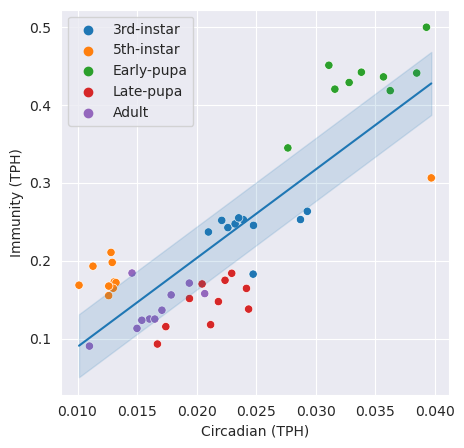

In [385]:
fig, ax1 = plt.subplots(1, 1, figsize=(5, 5))

#plot immunity vs energy metabolism
sns.scatterplot(data=circadian_immunity_data, y="Immunity", x="Circadian", hue="stage", ax=ax1)
sns.lineplot(x=immunity_vs_circadian_exp_growth_model['x_values'], 
             y=immunity_vs_circadian_exp_growth_model['y_pred'], ax=ax1)
ax1.fill_between(immunity_vs_circadian_exp_growth_model['x_values'], 
                 (immunity_vs_circadian_exp_growth_model['y_pred']-immunity_vs_circadian_exp_growth_model['ci']), 
                 (immunity_vs_circadian_exp_growth_model['y_pred']+immunity_vs_circadian_exp_growth_model['ci']), 
                 color='tab:blue', alpha=0.15)
ax1.set_xlabel('Circadian (TPH)')
ax1.set_ylabel('Immunity (TPH)')

Really qucik, I want to look at carbohydrate metabolism vs lipid metabolism

In [387]:
samples = list(organismal_df.index)
metabolism_data = pd.DataFrame(index=samples)

plant = list(organismal_df["plant"])
stage = list(organismal_df["developmental_stage"])

energy_metabolism = list(metabolism_df["Energy metabolism"])
carbohydrate_metabolism = list(metabolism_df["Carbohydrate metabolism"])
lipid_metabolsim = list(metabolism_df["Lipid metabolism"])

metabolism_data['Lipid_metabolism'] = lipid_metabolsim
metabolism_data['Energy_metabolism'] = energy_metabolism
metabolism_data['Carbohydrate_metabolism'] = carbohydrate_metabolism

metabolism_data['stage']= stage
metabolism_data['plant']= plant

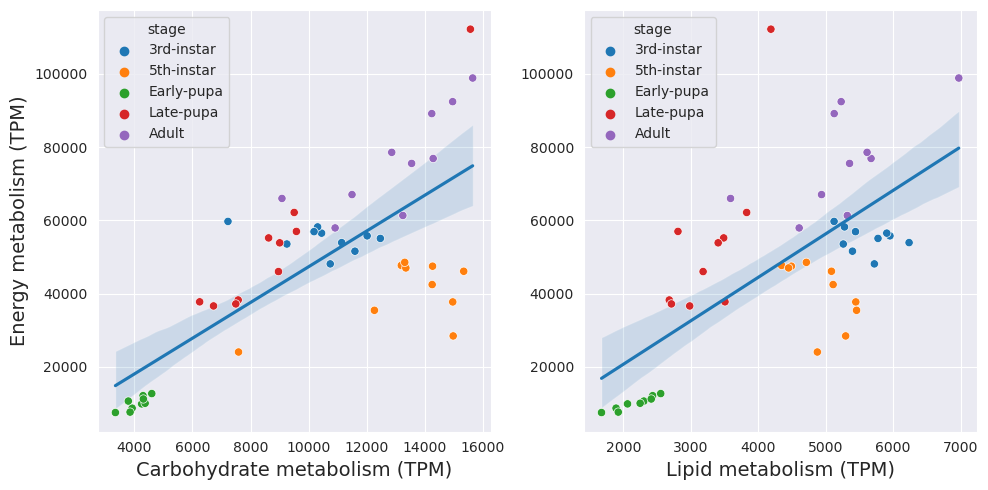

In [391]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 5))
sns.set_style('darkgrid')

sns.regplot(data=metabolism_data, y="Energy_metabolism", x="Carbohydrate_metabolism", scatter=False, ax=ax1)
sns.scatterplot(data=metabolism_data, y="Energy_metabolism", x="Carbohydrate_metabolism", hue="stage", ax=ax1)
ax1.set_ylabel('Energy metabolism (TPM)', size=14)
ax1.set_xlabel('Carbohydrate metabolism (TPM)', size=14)

sns.regplot(data=metabolism_data, y="Energy_metabolism", x="Lipid_metabolism", scatter=False, ax=ax2)
sns.scatterplot(data=metabolism_data, y="Energy_metabolism", x="Lipid_metabolism", hue="stage", ax=ax2)
ax2.set_ylabel('')
ax2.set_xlabel('Lipid metabolism (TPM)', size=14)

plt.tight_layout()

Now for some highly correlated clusters

In [264]:
#there seems to be a big chunk of things that are positively correlated. I'll look at these

#Transcription
#Cell growth and death
#Chromosome
#Information processing in viruses
#Development and regeneration
#Replication and repair

#it looks like energy metabolism and immunity are pretty heavily negatively correlated
#I'll try to plot these directly

samples = list(organismal_df.index)
high_cor_data = pd.DataFrame(index=samples)

plant = list(organismal_df["plant"])
stage = list(organismal_df["developmental_stage"])

transcription = list(genetic_df["Transcription"])
cell_growth_death = list(cellular_df["Cell growth and death"])
chromosome = list(genetic_df["Chromosome"])
development = list(organismal_df["Development and regeneration"])
replication_and_repair = list(genetic_df["Replication and repair"])

high_cor_data['Transcription'] = transcription
high_cor_data['Cell_growth_death'] = cell_growth_death
high_cor_data['Chromosome'] = chromosome
high_cor_data['Development'] = development
high_cor_data['Replication_repair'] = replication_and_repair

high_cor_data['stage']= stage
high_cor_data['plant']= plant

In [269]:
#immunty vs energy metabolism model
print("Dorso-ventral axis formation vs Transcription")
dva_vs_transcription_linear_model = fit_linear_model(data = high_cor_data, 
                                                x_col = 'Transcription', 
                                                y_col = 'Development')

Dorso-ventral axis formation vs Transcription

Linear Model Fit Summary:

Fitted Parameters:
m = 0.18505211334940572 (SE = 0.007022303318286105)
b = 44.6258209895515 (SE = 25.026994180677924)

Sum of squared residuals: 239138.16360891846


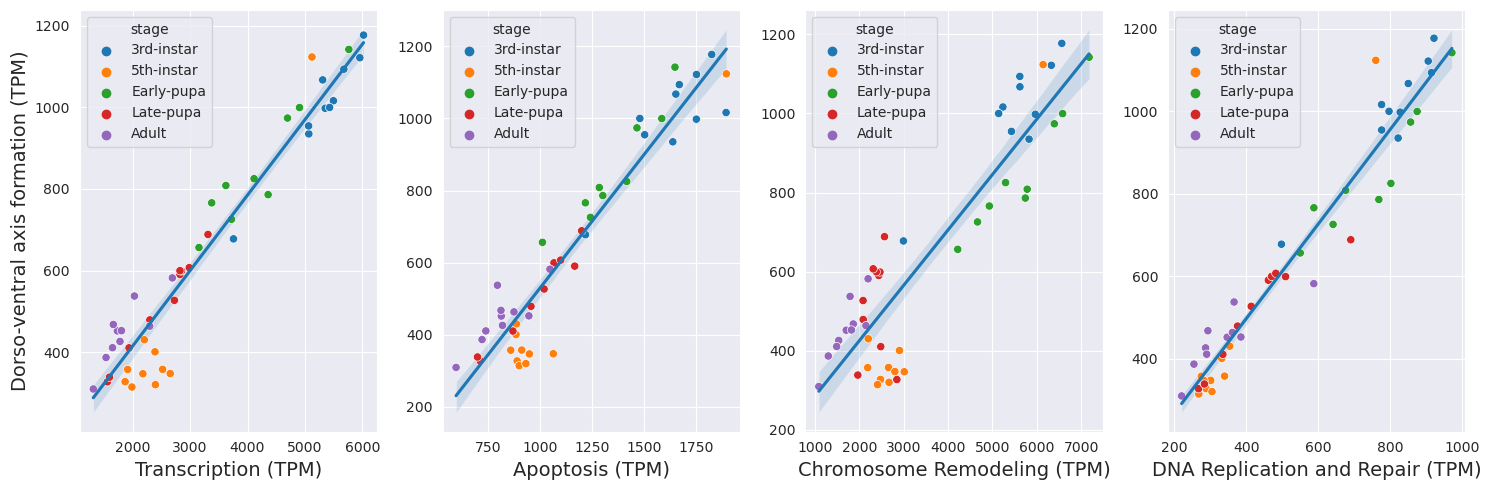

In [265]:
fig, [ax1, ax2, ax3, ax4] = plt.subplots(1, 4, figsize=(15, 5))
sns.set_style('darkgrid')

sns.regplot(data=high_cor_data, y="Development", x="Transcription", scatter=False, ax=ax1)
sns.scatterplot(data=high_cor_data, y="Development", x="Transcription", hue="stage", ax=ax1)
ax1.set_ylabel('Dorso-ventral axis formation (TPM)', size=14)
ax1.set_xlabel('Transcription (TPM)', size=14)

sns.regplot(data=high_cor_data, y="Development", x="Cell_growth_death", scatter=False, ax=ax2)
sns.scatterplot(data=high_cor_data, y="Development", x="Cell_growth_death", hue="stage", ax=ax2)
ax2.set_ylabel('')
ax2.set_xlabel('Apoptosis (TPM)', size=14)

sns.regplot(data=high_cor_data, y="Development", x="Chromosome", scatter=False, ax=ax3)
sns.scatterplot(data=high_cor_data, y="Development", x="Chromosome", hue="stage", ax=ax3)
ax3.set_ylabel('')
ax3.set_xlabel('Chromosome Remodeling (TPM)', size=14)

sns.regplot(data=high_cor_data, y="Development", x="Replication_repair", scatter=False, ax=ax4)
sns.scatterplot(data=high_cor_data, y="Development", x="Replication_repair", hue="stage", ax=ax4)
ax4.set_ylabel('')
ax4.set_xlabel('DNA Replication and Repair (TPM)', size=14)

plt.tight_layout()

There's one more super highly correlated cluster that needs to be looked at

In [280]:
#there seems to be a big chunk of things that are positively correlated. I'll look at these

#Glycan biosynthesis and metabolism
#Translation
#Metabolism of terpenoids and polyketides
#Metabolism of other amino acids
#Folding, sorting and degradation
#Transport and catabolism

samples = list(organismal_df.index)
high_cor_data2 = pd.DataFrame(index=samples)

plant = list(organismal_df["plant"])
stage = list(organismal_df["developmental_stage"])

glycan_biosynth = list(metabolism_df["Glycan biosynthesis and metabolism"])
translation = list(genetic_df["Translation"])
terp_poly_metab = list(metabolism_df["Metabolism of terpenoids and polyketides"])
other_aa_metab = list(metabolism_df["Metabolism of other amino acids"])
folding_sort_deg = list(genetic_df["Folding, sorting and degradation"])
transport_catab = list(cellular_df["Transport and catabolism"])

high_cor_data2['Glycan_biosynthesis'] = glycan_biosynth
high_cor_data2['Translation'] = translation
high_cor_data2['terp_poly_metab'] = terp_poly_metab
high_cor_data2['other_aa_metab'] = other_aa_metab
high_cor_data2['folding_sort_deg'] = folding_sort_deg
high_cor_data2['transport_catab'] = transport_catab

high_cor_data2['stage']= stage
high_cor_data2['plant']= plant

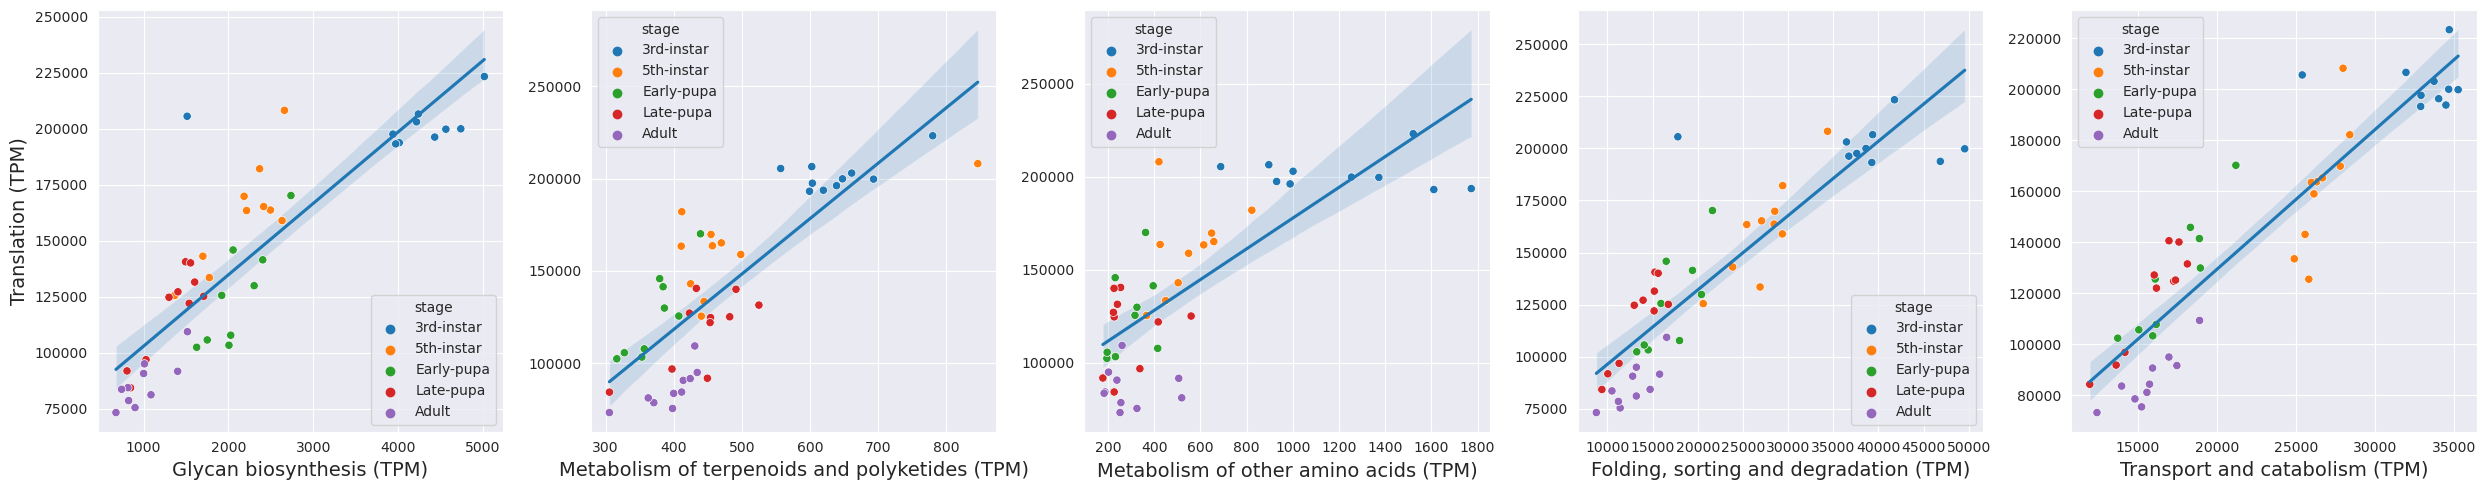

In [289]:
fig, [ax1, ax2, ax3, ax4, ax5] = plt.subplots(1, 5, figsize=(25, 5))
sns.set_style('darkgrid')

sns.regplot(data=high_cor_data2, y="Translation", x="Glycan_biosynthesis", scatter=False, ax=ax1)
sns.scatterplot(data=high_cor_data2, y="Translation", x="Glycan_biosynthesis", hue="stage", ax=ax1)
ax1.set_ylabel('Translation (TPM)', size=14)
ax1.set_xlabel('Glycan biosynthesis (TPM)', size=14)

sns.regplot(data=high_cor_data2, y="Translation", x="terp_poly_metab", scatter=False, ax=ax2)
sns.scatterplot(data=high_cor_data2, y="Translation", x="terp_poly_metab", hue="stage", ax=ax2)
ax2.set_ylabel('')
ax2.set_xlabel('Metabolism of terpenoids and polyketides (TPM)', size=14)

sns.regplot(data=high_cor_data2, y="Translation", x="other_aa_metab", scatter=False, ax=ax3)
sns.scatterplot(data=high_cor_data2, y="Translation", x="other_aa_metab", hue="stage", ax=ax3)
ax3.set_ylabel('')
ax3.set_xlabel('Metabolism of other amino acids (TPM)', size=14)

sns.regplot(data=high_cor_data2, y="Translation", x="folding_sort_deg", scatter=False, ax=ax4)
sns.scatterplot(data=high_cor_data2, y="Translation", x="folding_sort_deg", hue="stage", ax=ax4)
ax4.set_ylabel('')
ax4.set_xlabel('Folding, sorting and degradation (TPM)', size=14)

sns.regplot(data=high_cor_data2, y="Translation", x="transport_catab", scatter=False, ax=ax5)
sns.scatterplot(data=high_cor_data2, y="Translation", x="transport_catab", hue="stage", ax=ax5)
ax5.set_ylabel('')
ax5.set_xlabel('Transport and catabolism (TPM)', size=14)

plt.tight_layout()

### Analysis: Coloration case study


In [220]:
#Now I'll need to get the protein id for each differentially expressed gene, and then get the gene id.
#Here's a function to do that
def replace_gene_ids(dataframe, protein_to_gene_map):
    #initialize list to store gene ids
    gene_ids = []
    for id in list(dataframe.columns):
        protein_id = id.split('_')[2]
        gene_id = protein_to_gene_map[protein_id]
        gene_ids.append(gene_id)
    
    #add gene id to dataframe
    dataframe.columns = gene_ids

#now add gb gene ids to dataframe
replace_gene_ids(uninfected_data, protein_to_gene_dict)

In [221]:
uninfected_data

KGM_206960A  KGM_206960B  KGM_206959  KGM_206961  KGM_206962  \
sample-id                                                                   
mtstp5iu98     40.307900    56.571700   1108.7200  161.260000    3.714120   
mtstp3cu2     117.197000   158.977000    473.1770   50.214300   51.896000   
mtstp5cu17     53.580300    72.488100    847.3960  143.629000    6.129130   
mtstpLiu130     0.036026     0.000000    750.5200    3.536750    3.418260   
mtstpLiu133     0.025680     0.091779    439.9790    8.929790    2.229130   
mtstpEcu38      0.000000     0.011409    205.2790    0.678483    4.695950   
mtstpAiu148    20.759100    32.852500    879.6510    6.046150    6.695500   
mtstp5iu100    32.551700    40.219300   1100.9300  173.425000    5.561670   
mtstpLiu131     1.578640     1.649300   1298.7200    9.646060    0.334944   
mtstpAiu147     2.604970     6.297790    944.9610    2.818230    3.877800   
mtstpEiu115     0.000000     0.000000     92.4997    1.105660    1.275820   
mtstp3cu8      29.974400    40.601000    440.5440   37.705100   36.748000   
mtstp3iu83     98.823300   132.963000    500.1870   53.850700   38.772500   
mtstpLcu53      0.359256     0.396010    448.2530    9.491590    6.636560   
mtstpAcu66      2.011540     6.906670   1035.2700    3.490830    9.866980   
mtstp5cu18     15.945100    21.193000   1014.5300  112.720000    2.501850   
mtstpEcu36      0.000000     0.034802    131.0240    1.220510    4.470420   
mtstp5cu21     63.247600    68.294400    811.0290  128.363000    9.675900   
mtstp3iu84     86.734200   121.443000    544.0660   31.014100   65.009200   
mtstp3iu82    111.970000   150.068000    491.1760   50.272400   26.798400   
mtstpAiu146    32.254300    39.683100    858.5360    5.245170    2.527810   
mtstp3cu3      96.000300   127.566000    456.1150   57.058900   33.312200   
mtstpAcu69      2.906280     5.415690    960.3170    2.009900    6.174350   
mtstpAcu68      7.294400    15.827300    960.4610    3.947520   11.504600   
mtstp3iu81    121.609000   144.497000    548.5520   58.968800   40.048800   
mtstpEiu117     0.015341     0.056988    188.8970    1.347410    3.749560   
mtstpLcu49      0.089929     0.084084    553.9710    9.195610   20.706300   
mtstpAcu67      1.999000     6.472130    584.6950    1.422900    2.125880   
mtstpEiu114     0.032319     0.051407     85.9620    0.790691    0.645967   
mtstpLcu56      0.014319     0.039896    579.0130    4.265990    1.249480   
mtstpAiu145    11.655100    14.818700    752.6260    2.352190    1.944360   
mtstp3cu4      76.693100   114.822000    430.6750   48.165300   61.012000   
mtstpLcu50      0.657602     0.515515    751.2580   20.267600    3.651930   
mtstp3cu5      98.160300   124.615000    461.6830   44.827500   25.179100   
mtstpLiu135     0.122114     0.195979    407.6920   23.313300    8.234270   
mtstpAiu149     3.837900     6.630940   1030.9100    4.576090    5.008540   
mtstp3iu85     75.919800    94.491300    172.1650   16.406500    5.050140   
mtstpEcu34      0.012480     0.000000     88.2051    0.882785    3.869270   
mtstp5cu19     30.339000    37.577300   1145.4300  140.809000    4.071260   
mtstpEcu33      0.029435     0.120144    103.1130    1.762800    1.370100   
mtstp5cu20     14.333500    17.915000    711.8970  168.999000    2.644620   
mtstp5iu97      2.715540     3.191940    443.1140    2.260260    0.839470   
mtstpLiu129     0.134982     0.040984    540.7630   11.377800   10.848000   
mtstp5iu99     38.043600    53.893300   1097.3600  136.360000    0.443186   
mtstp5iu101    37.617100    51.494600   1325.7000  110.882000    1.728280   
mtstpAcu65      1.946100     7.246220    666.0700    5.692300   14.249300   
mtstpEcu35      0.019743     0.054945    131.5180    1.323140    5.910750   
mtstpEiu116     0.031047     0.092303    141.1160    0.989605    3.219800   
mtstpLcu52      0.043105     0.010688    565.6320   11.630800    0.677640   

             KGM_206963  KGM_206964  KGM_206965  KGM_206958  KGM_206966  ...  \
sampl

In [ ]:
#First I need a function that will generate a dataframe that sums the relativized counts from a gene of interest
def get_gene_counts(data, kegg_dict, level, target):
    #initialize dataframe to store information
    function_df = pd.DataFrame(index=list(data.index), columns=[target])
    #replace the NaNs with 0s
    function_df[target] = function_df[target].fillna(0)
    #iterate through each gene anc check if it is a gene of interest
    for gene_id in list(data.columns):
        #use try becuase not all genes will have ids
        try:
            functional_annotations = kegg_dict[gene_id]
            for entry in functional_annotations:
                functional_heirarchy = entry['functional_heirarcy']
                #check if target is in heirarchy
                if functional_heirarchy[level] == target:
                    #add column to dataframe
                    function_df[target] = function_df[target] + data[gene_id]
                
        except:
            pass
        
    return function_df

In [234]:
#now to get data for coloration genes
xanthine_dehydrogenases = ['KGM_205814', 'KGM_205813', 'KGM_205480', 'KGM_204714', 'KGM_208006', 'KGM_200223', 'KGM_210883']
yellow_family = ['KGM_215143A', 'KGM_215143B', 'KGM_211366', 'KGM_215837']

xanthine_dehydrogenase_data = uninfected_data
yellow_family_data = uninfected_data

genes = list(uninfected_data.columns)

#get xanthine dehydrogenase genes
for gene in genes:
    if gene not in xanthine_dehydrogenases:
        xanthine_dehydrogenase_data = xanthine_dehydrogenase_data.drop(gene, axis=1)

#get yellow family genes
for gene in genes:
    if gene not in yellow_family:
        yellow_family_data = yellow_family_data.drop(gene, axis=1)

In [245]:
#add metadata (should be the same for both dataframes)
plant = []
stage = []

for sample in list(xanthine_dehydrogenase_data.index):
    if sample[6] == 'i':
        plant.append('A. incarnata')
    elif sample[6] == 'c':
        plant.append('A. curassavica')
        
    if sample[5] == '3':
        stage.append('third-instar')
    elif sample[5] == '5':
        stage.append('fifth-instar')
    elif sample[5] == 'E':
        stage.append('early-pupa')
    elif sample[5] == 'L':
        stage.append('late-pupa')
    elif sample[5] == 'A':
        stage.append('adult')

yellow_family_data['plant'] = plant
xanthine_dehydrogenase_data['plant'] = plant

yellow_family_data['stage'] = stage
xanthine_dehydrogenase_data['stage'] = stage

In [246]:
yellow_family_data 

KGM_215837  KGM_211366  KGM_215143A  KGM_215143B           plant  \
sample-id                                                                       
mtstp5iu98      34.5662     2.86790     16.91660    16.830600    A. incarnata   
mtstp3cu2      110.9080     7.28588     30.98400     6.550430  A. curassavica   
mtstp5cu17      39.9395     2.35194     32.20870     7.411420  A. curassavica   
mtstpLiu130     91.3938     5.31393      5.09877     1.095580    A. incarnata   
mtstpLiu133     83.5506     5.33156      6.78065     1.591090    A. incarnata   
mtstpEcu38     135.4760    10.10180     62.74680    44.203500  A. curassavica   
mtstpAiu148     47.6347     3.79001     35.79020     8.351130    A. incarnata   
mtstp5iu100     41.3008     2.93576     32.58130    26.832800    A. incarnata   
mtstpLiu131     55.2687     3.50349      4.56842     1.451770    A. incarnata   
mtstpAiu147     34.2683     2.72923     35.87910     7.966390    A. incarnata   
mtstpEiu115     89.3094     7.44305     86.00020    18.239200    A. incarnata   
mtstp3cu8      132.0390     8.36478     30.37210     7.497540  A. curassavica   
mtstp3iu83     109.5870     7.93179     29.13430     6.775430    A. incarnata   
mtstpLcu53      50.8665     3.08720      1.70120     0.791901  A. curassavica   
mtstpAcu66      35.0215     2.25291     20.95610     5.014190  A. curassavica   
mtstp5cu18      38.3646     2.71437     40.16750     9.204770  A. curassavica   
mtstpEcu36     129.3970     9.05940     64.87560    16.669100  A. curassavica   
mtstp5cu21      35.9701     2.28985     29.90210     7.651920  A. curassavica   
mtstp3iu84      92.5111     6.33358     28.77830     6.830380    A. incarnata   
mtstp3iu82     102.7360     7.49469     29.62100     7.173190    A. incarnata   
mtstpAiu146     37.9954     3.19507     15.72410    17.167000    A. incarnata   
mtstp3cu3      107.2720     5.49913     29.76630     7.917970  A. curassavica   
mtstpAcu69      29.6723     3.12108      5.52990     7.447700  A. curassavica   
mtstpAcu68      58.4839     3.78402      4.78174     6.880360  A. curassavica   
mtstp3iu81     123.1150     7.07186     28.53160     4.915320    A. incarnata   
mtstpEiu117     94.9673     9.26815     51.74690    46.234900    A. incarnata   
mtstpLcu49      87.8911     5.10653      4.45926     1.145100  A. curassavica   
mtstpAcu67      26.3962     1.68925     16.73600     4.941470  A. curassavica   
mtstpEiu114     58.6786     6.48489     59.25220    13.502300    A. incarnata   
mtstpLcu56      71.7657     6.25326      5.31684     1.569380  A. curassavica   
mtstpAiu145     25.8351     2.72875      8.20789     1.880690    A. incarnata   
mtstp3cu4       89.7375     5.93239     29.02030     7.145520  A. curassavica   
mtstpLcu50      55.9637     3.77163      4.98880     1.054110  A. curassavica   
mtstp3cu5      123.7750     5.77374     18.88620     5.412760  A. curassavica   
mtstpLiu135     70.0502     6.10306      5.95882     1.750410    A. incarnata   
mtstpAiu149     27.1110     2.98555     15.30280     3.893700    A. incarnata   
mtstp3iu85      64.9937     3.65552      5.91563     5.225220    A. incarnata   
mtstpEcu34      62.5930     7.51374     63.43470    15.374400  A. curassavica   
mtstp5cu19      35.2974     2.60541     16.39730    19.099400  A. curassavica   
mtstpEcu33      90.9939     8.09147     37.18830    44.102100  A. curassavica   
mtstp5cu20      37.7384     2.10849     24.41140     4.678300  A. curassavica   
mtstp5iu97     122.5990     7.33051     41.98360     7.269550    A. incarnata   
mtstpLiu129     68.3768     5.46611      5.94381     0.980010    A. incarnata   
mtstp5iu99      46.8468     3.20095     30.03150     6.412470    A. incarnata   
mtstp5iu101     52.1030     2.87146     29.63310    32.023100    A. incarnata   
mtstpAcu65      36.3097     2.36259     20.22470     5.573710  A. curassavica   
mtstpEcu35      72.2919     7.06659     67.90300    15.092400  A. curassavica   
mtstpEiu116     97.5170     8.82465     44.2

In [247]:
xanthine_dehydrogenase_data

KGM_205813  KGM_205814  KGM_205480  KGM_204714  KGM_208006  \
sample-id                                                                 
mtstp5iu98     4.718180    53.14120    5.706710    0.000000    1.345010   
mtstp3cu2      1.118520    30.42190    8.303270    0.033138    3.665760   
mtstp5cu17     2.834340    41.37230    2.267650    0.006918    0.412323   
mtstpLiu130    2.052650    13.05270    6.388690    0.067346    0.000000   
mtstpLiu133    0.543858     7.49229    9.569620    0.418353    0.000000   
mtstpEcu38     1.448850     6.61868    0.093169    0.006821    0.000000   
mtstpAiu148    4.468250     5.03682    1.059230    0.011656    0.000000   
mtstp5iu100    5.048560    51.93880    3.956450    0.011881    0.924197   
mtstpLiu131   10.544600    15.18270    4.531920    0.000000    0.000000   
mtstpAiu147    4.312320     4.01270    1.047460    0.000000    0.000000   
mtstpEiu115    1.969000     6.32955    0.036925    0.005858    0.000000   
mtstp3cu8      1.185210    25.38610   10.231200    0.008597    8.910160   
mtstp3iu83     1.057530    27.93030    4.483420    0.007620    5.342570   
mtstpLcu53     7.228430     7.36376    5.690760    0.000000    0.000000   
mtstpAcu66     3.997180     2.73742    0.379690    0.019804    0.000000   
mtstp5cu18     7.519550    61.93560    5.402330    0.000000    0.987289   
mtstpEcu36     1.725510     5.27328    0.357694    0.048640    0.000000   
mtstp5cu21     6.586100    65.26740    1.636950    0.022261    0.134930   
mtstp3iu84     0.767820    35.53730    2.845880    0.087140    3.961530   
mtstp3iu82     1.080510    32.25100    5.135200    0.007948    3.861950   
mtstpAiu146    6.367190    11.71530    0.083119    0.045215    0.000000   
mtstp3cu3      1.493780    27.35140    5.160700    0.000000    3.311280   
mtstpAcu69     4.196420     3.36174    0.521270    0.048918    0.000000   
mtstpAcu68     3.243260     4.85388    1.443370    0.040410    0.000000   
mtstp3iu81     0.872352    39.19170    6.887740    0.000000    6.623150   
mtstpEiu117    1.449760     5.68779    0.028678    0.006824    0.000000   
mtstpLcu49     2.496870    16.44070    9.252580    0.075721    0.000000   
mtstpAcu67     3.737570     2.30929    0.374471    0.009259    0.000000   
mtstpEiu114    2.634820     4.93337    0.414161    0.024640    0.018669   
mtstpLcu56     0.938209    11.43730    6.022850    0.625834    0.000000   
mtstpAiu145    3.569380     2.01341    0.114103    0.056483    0.000000   
mtstp3cu4      0.611870    35.24440    2.664450    0.000000    3.593930   
mtstpLcu50     4.579350    14.49110    6.392980    0.000000    0.000000   
mtstp3cu5      0.585283    36.43160    4.532360    0.006458    6.276090   
mtstpLiu135    1.163240    21.48870    6.451220    0.065186    0.000000   
mtstpAiu149    3.284540     5.74986    0.167266    0.000000    0.000000   
mtstp3iu85     0.452118    45.11950    5.468790    0.000000    0.072223   
mtstpEcu34     2.065380     5.46069    0.163328    0.000000    0.005609   
mtstp5cu19     9.351050    61.95730    4.422090    0.000000    1.944470   
mtstpEcu33     1.161830     6.66358    0.295651    0.013090    0.000000   
mtstp5cu20     2.424410    65.68780    2.902970    0.013411    0.013549   
mtstp5iu97     2.774940     9.22954   28.058600    0.000000    2.426050   
mtstpLiu129    3.076210    19.64450    5.426170    0.049114    0.000000   
mtstp5iu99     3.426420    53.20160    4.408140    0.023929    0.241747   
mtstp5iu101    6.480820    51.56260    8.974440    0.000000    0.928917   
mtstpAcu65     5.738590     3.56013    0.110810    0.016653    0.000000   
mtstpEcu35     1.927500     5.20014    0.608752    0.039510    0.019957   
mtstpEiu116    1.404060     5.48107    0.116091    0.055249    0.000000   
mtstpLcu52     0.893376     8.33232    8.531350    0.402805    0.000000   

             KGM_200223  KGM_210883           plant         stage  
sample-id                                                          
mtstp5iu98     1.478420    1.812200    A. incarnata

In [248]:
#sort data by stage
#sort data by developmental stage
dev_stages = ['third-instar', 'fifth-instar', 'early-pupa', 'late-pupa', 'adult']


xanthine_dehydrogenase_data['stage'] = pd.Categorical(xanthine_dehydrogenase_data['stage'], categories = dev_stages)
xanthine_dehydrogenase_data = xanthine_dehydrogenase_data.sort_values(by='stage')

yellow_family_data['stage'] = pd.Categorical(yellow_family_data['stage'], categories = dev_stages)
yellow_family_data  = yellow_family_data .sort_values(by='stage')

In [254]:
yellow_family_data

KGM_215837  KGM_211366  KGM_215143A  KGM_215143B           plant  \
sample-id                                                                       
mtstp3iu81     123.1150     7.07186     28.53160     4.915320    A. incarnata   
mtstp3cu2      110.9080     7.28588     30.98400     6.550430  A. curassavica   
mtstp3iu85      64.9937     3.65552      5.91563     5.225220    A. incarnata   
mtstp3cu5      123.7750     5.77374     18.88620     5.412760  A. curassavica   
mtstp3cu4       89.7375     5.93239     29.02030     7.145520  A. curassavica   
mtstp3cu3      107.2720     5.49913     29.76630     7.917970  A. curassavica   
mtstp3cu8      132.0390     8.36478     30.37210     7.497540  A. curassavica   
mtstp3iu83     109.5870     7.93179     29.13430     6.775430    A. incarnata   
mtstp3iu82     102.7360     7.49469     29.62100     7.173190    A. incarnata   
mtstp3iu84      92.5111     6.33358     28.77830     6.830380    A. incarnata   
mtstp5iu101     52.1030     2.87146     29.63310    32.023100    A. incarnata   
mtstp5iu99      46.8468     3.20095     30.03150     6.412470    A. incarnata   
mtstp5iu97     122.5990     7.33051     41.98360     7.269550    A. incarnata   
mtstp5cu20      37.7384     2.10849     24.41140     4.678300  A. curassavica   
mtstp5cu19      35.2974     2.60541     16.39730    19.099400  A. curassavica   
mtstp5cu21      35.9701     2.28985     29.90210     7.651920  A. curassavica   
mtstp5iu98      34.5662     2.86790     16.91660    16.830600    A. incarnata   
mtstp5cu18      38.3646     2.71437     40.16750     9.204770  A. curassavica   
mtstp5cu17      39.9395     2.35194     32.20870     7.411420  A. curassavica   
mtstp5iu100     41.3008     2.93576     32.58130    26.832800    A. incarnata   
mtstpEcu35      72.2919     7.06659     67.90300    15.092400  A. curassavica   
mtstpEiu115     89.3094     7.44305     86.00020    18.239200    A. incarnata   
mtstpEiu116     97.5170     8.82465     44.25060    35.814900    A. incarnata   
mtstpEiu117     94.9673     9.26815     51.74690    46.234900    A. incarnata   
mtstpEcu38     135.4760    10.10180     62.74680    44.203500  A. curassavica   
mtstpEcu33      90.9939     8.09147     37.18830    44.102100  A. curassavica   
mtstpEiu114     58.6786     6.48489     59.25220    13.502300    A. incarnata   
mtstpEcu34      62.5930     7.51374     63.43470    15.374400  A. curassavica   
mtstpEcu36     129.3970     9.05940     64.87560    16.669100  A. curassavica   
mtstpLiu130     91.3938     5.31393      5.09877     1.095580    A. incarnata   
mtstpLiu129     68.3768     5.46611      5.94381     0.980010    A. incarnata   
mtstpLiu133     83.5506     5.33156      6.78065     1.591090    A. incarnata   
mtstpLiu135     70.0502     6.10306      5.95882     1.750410    A. incarnata   
mtstpLcu50      55.9637     3.77163      4.98880     1.054110  A. curassavica   
mtstpLcu56      71.7657     6.25326      5.31684     1.569380  A. curassavica   
mtstpLcu49      87.8911     5.10653      4.45926     1.145100  A. curassavica   
mtstpLcu53      50.8665     3.08720      1.70120     0.791901  A. curassavica   
mtstpLiu131     55.2687     3.50349      4.56842     1.451770    A. incarnata   
mtstpLcu52      91.6215     5.32570      6.98964     5.129730  A. curassavica   
mtstpAiu147     34.2683     2.72923     35.87910     7.966390    A. incarnata   
mtstpAiu149     27.1110     2.98555     15.30280     3.893700    A. incarnata   
mtstpAiu145     25.8351     2.72875      8.20789     1.880690    A. incarnata   
mtstpAiu148     47.6347     3.79001     35.79020     8.351130    A. incarnata   
mtstpAcu67      26.3962     1.68925     16.73600     4.941470  A. curassavica   
mtstpAcu68      58.4839     3.78402      4.78174     6.880360  A. curassavica   
mtstpAcu69      29.6723     3.12108      5.52990     7.447700  A. curassavica   
mtstpAiu146     37.9954     3.19507     15.72410    17.167000    A. incarnata   
mtstpAcu65      36.3097     2.36259     20.2

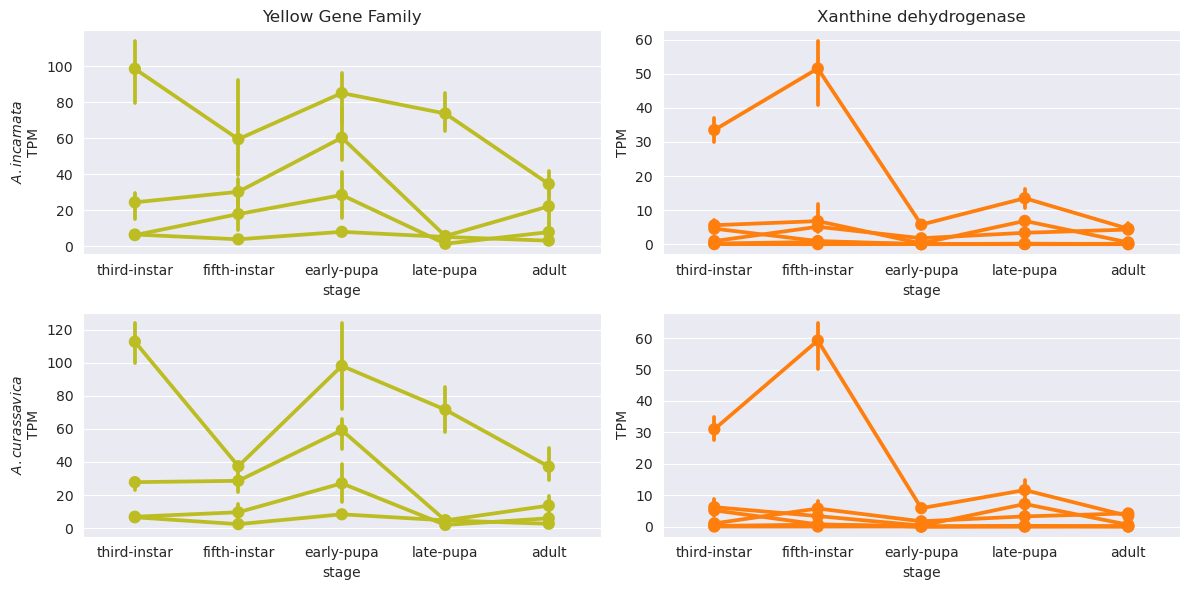

In [299]:
#plot 

#Make expression plots
sns.set_style('darkgrid')

#plot inc
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(12, 6))

for gene in list(yellow_family_data.columns)[0:4]:
    y_data = yellow_family_data[gene]
    y_data = yellow_family_data.loc[yellow_family_data['plant'] == 'A. incarnata']
    sns.pointplot(data=y_data, x='stage', y=gene, ax=ax1, color='tab:olive')
ax1.set_ylabel('$A. incarnata$\nTPM')
ax1.set_title('Yellow Gene Family')

for gene in list(xanthine_dehydrogenase_data.columns)[0:6]:
    x_data = xanthine_dehydrogenase_data[gene]
    x_data = xanthine_dehydrogenase_data.loc[xanthine_dehydrogenase_data['plant'] == 'A. incarnata']
    sns.pointplot(data=xanthine_dehydrogenase_data, x='stage', y=gene, ax=ax2, color='tab:orange')    
ax2.set_ylabel('TPM')
ax2.set_title('Xanthine dehydrogenase')

for gene in list(yellow_family_data.columns)[0:4]:
    y_data = yellow_family_data[gene]
    y_data = yellow_family_data.loc[yellow_family_data['plant'] == 'A. curassavica']
    sns.pointplot(data=y_data, x='stage', y=gene, ax=ax3, color='tab:olive')
ax3.set_ylabel('$A. curassavica$\nTPM')

for gene in list(xanthine_dehydrogenase_data.columns)[0:6]:
    x_data = xanthine_dehydrogenase_data[gene]
    x_data = xanthine_dehydrogenase_data.loc[xanthine_dehydrogenase_data['plant'] == 'A. curassavica']
    sns.pointplot(data=x_data, x='stage', y=gene, ax=ax4, color='tab:orange')
ax4.set_ylabel('TPM')

plt.tight_layout()
plt.savefig('../figures/coloration.pdf')